In [ ]:
###关于数据的保存：在bash运行——./save.sh "这里写修改说明"###

#===========================================================#
#####################总体思路梳理############################
#===========================================================#
##################模块一：得到目标论文序列####################
#STEP1————匹配
#将论文引用关系原始数据与撤稿论文序列进行匹配，目的是得到所有引用了撤稿论文的论文




# 前期准备模块

## 库的导入

In [1]:
###########################这一单元模块专门用于导入需要用到的库####################################

import pandas as pd #基础的数据处理
import os 
#Python 中的一条指令，用于导入内置的os模块。
#os模块提供了与操作系统交互的功能，允许你执行文件和目录的操作
#如路径管理、文件创建、删除等
import json #用于处理json数据的库
from tqdm import tqdm
import math # 用于检测 NaN
from collections import Counter #Python标准库collections里的的工具，用来统计元素出现的次数
from collections import defaultdict 
'''
collections 是 Python 自带的一个模块，
里面提供了许多有用的容器数据类型，比如 Counter、deque、namedtuple、defaultdict 等。
defaultdict 是一个字典的子类，它和普通字典类似，
但当你访问一个不存在的键时，它会自动帮你创建一个默认值，而不是抛出 KeyError。
'''
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

## 查看大体量数据的前十行（CSV/EXCEL/JSON）

In [ ]:
###########数据前10行展示##############
######用来判断太大数据的数据结构########
#CSV文件：
file_csv = '/Data1/DATA/Dimensions2024/20240101/Papers.csv'
df_csv = pd.read_csv(file_csv, nrows=10)
df_csv

In [ ]:
#EXCEL文件：
file_excel = ''
df_excel = pd.read_excel(file_excel, nrows=10)
df_excel

In [ ]:
#JSON文件：
file_json = 'JSON文件路径.json'
df_json = pd.read_json(file_json)
df_json

## 查看CSV文件列名

In [ ]:
#看df文件的列名
print(NewE_C_10_10 .columns)

# 模块（一）：得到目标论文序列

## STEP1——匹配所有引用了撤稿论文的文献序列df_containretra

In [ ]:
#这个部分需要两个原始数据
#（1）原始数据1：论文与其参考文献的对应关系（/Data1/DATA/Dimensions2024/20240101/PaperReferences.csv）
'''
df数据结构：
    id	            reference_ids
0	pub.1038660625	pub.1043519304
1	pub.1038660625	pub.1012015875
2	pub.1038660625	pub.1031233780
3	pub.1038660625	pub.1027495706
'''
#（2）原始数据2：4w篇撤稿论文的原始数据（/Data4/yutao_wen/matched_output2.csv）
'''
df数据结构（列名与数据类型）
Index(['UT', 'Paper_doi', 'Note_doi', 'Title', 'Journal', 'ISOAbbr',
       'Publisher', 'Article', 'Review', 'Institute', 'City', 'Country',
       'First', 'RP', 'Micro_topics', 'Meso_topics', 'Macro_topics', '3Years',
       '5Years', 'Total', 'Fund', 'Year', 'RYear', 'publish_date',
       'retraction_date', 'Open Access', 'Tags', 'Type', 'note_URL', 'Authors',
       'Addresses', 'Affiliations', 'PaperID', 'id', 'title', 'doi', 'date',
       'journal.id'],
      dtype='object')
'''


### 原始数据1与2的导入——30MIN

In [2]:
#先将两个原始文件都导入内核中
original_file1 = '/Data1/DATA/Dimensions2024/20240101/PaperReferences.csv'
df_references = pd.read_csv(original_file1)
original_file2 = '/Data4/yutao_wen/matched_output2.csv'
df_retrapapers = pd.read_csv(original_file2)
#time约30min

### 使用布尔索引匹配2个df——12MIN

In [3]:
# 保证reference_ids和撤稿论文id列的数据类型一致（通常为字符串）
df_references['reference_ids'] = df_references['reference_ids'].astype(str)
df_retrapapers['id'] = df_retrapapers['id'].astype(str)

# 使用布尔索引保留reference_ids出现在撤稿论文id中的行
df_containretra = df_references[df_references['reference_ids'].isin(df_retrapapers['id'])].copy()
#time约12min

### 匹配产出文件df_containretra预览

In [5]:
df_containretra

id   reference_ids
0       pub.1148484199  pub.1013663776
1       pub.1128687208  pub.1003140261
2       pub.1148009542  pub.1146057724
3       pub.1114696738  pub.1026667060
4       pub.1114902564  pub.1028915017
...                ...             ...
765834  pub.1134201694  pub.1113603600
765835  pub.1016972058  pub.1008362454
765836  pub.1085464507  pub.1039593849
765837  pub.1124870274  pub.1124369222
765838  pub.1022784437  pub.1037698336

[765839 rows x 2 columns]

### 匹配文件保存备份

In [6]:
output_path = '/Data4/yutao_wen/25.9.17/df_containretra.csv'
# 保存为 CSV 文件
df_containretra.to_csv(output_path, index=False)

### 导入df_containretra文件

In [29]:
df_containretra = pd.read_csv("/Data4/yutao_wen/25.9.17/df_containretra.csv")

## STEP2——匹配撤稿论文/目标论文原始信息

In [ ]:
#撤稿论文主要是两个关键年份（发表/撤稿）以及期刊id较为重要————来源于matched_output2
#（1）RPYear：被引用的撤稿论文的发表年份
#（2）RYear：被引用的撤稿论文的撤稿年份
#（3）RJournal_id：被引用的撤稿论文的期刊ID
#目标论文主要是发表年份与期刊id较为重要————来源于Papers.csv
#（1）Year：目标论文的发表年份
#（2）Journal_id：目标论文的期刊ID

### 原始数据2导入

In [30]:
original_file2 = '/Data4/yutao_wen/matched_output2.csv'
df_retrapapers = pd.read_csv(original_file2)

### 匹配撤稿论文RPYear、RYear、RJournal_id

In [31]:
#从 df_retrapapers 中选择需要匹配的列，并改列名
df_retra_subset = df_retrapapers[['id', 'Year', 'RYear', 'journal.id']].copy()
df_retra_subset = df_retra_subset.rename(columns={
    'id': 'reference_ids',
    'Year': 'RPYear',
    'RYear': 'RYear',
    'journal.id': 'RJournal_id'
})

# 第三步：将信息 merge 到 df_containretra 中
df_containretra = df_containretra.merge(df_retra_subset, on='reference_ids', how='left')

### 原始数据3导入——10min

In [11]:
# 此时需要第三个原始文件：Papers.csv文件
# 其蕴含了数据库所有论文的各种信息
original_file3 = '/Data1/DATA/Dimensions2024/20240101/Papers.csv'
'''
数据结构：
Index(['id', 'title', 'doi', 'date', 'date_inserted', 'date_normal',
       'date_online', 'date_print', 'type', 'journal.id', 'journal.title',
       'times_cited', 'num_funds', 'num_authors', 'num_references', 'field_l0',
       'field_l1', 'resulting_publication_doi'],
      dtype='object')

'''
#获取目标论文的Year与Journal.id
df_papers = pd.read_csv(original_file3,usecols=['id', 'date_normal','journal.id'])
#time约10min

### 详细年月日date提取年份Year

In [12]:
# 提取年份（ date 格式如 '2019-03-15'）
df_papers['Year'] = pd.to_datetime(df_papers['date_normal'], errors='coerce').dt.year

### 匹配目标论文Year、Journal.id——4MIN

In [32]:
# 只选择需要的列，重命名 'journal.id' 为 'Journal_id'
df_papers_subset = df_papers[['id', 'Year','journal.id']].rename(columns={'journal.id': 'Journal_id'})

# 合并，添加 Journal_id 列
df_containretra = df_containretra.merge(df_papers_subset, on='id', how='left')

In [36]:
# 调整列顺序
df_containretra = df_containretra[['id', 'reference_ids', 'Year', 'Journal_id', 'RPYear', 'RYear', 'RJournal_id']]


In [37]:
df_containretra

id   reference_ids    Year    Journal_id  RPYear   RYear  \
0       pub.1148484199  pub.1013663776  2019.0           NaN  2014.0  2022.0   
1       pub.1128687208  pub.1003140261  2012.0           NaN  2000.0  2012.0   
2       pub.1148009542  pub.1146057724  2022.0  jour.1115238  2022.0  2023.0   
3       pub.1114696738  pub.1026667060  2015.0  jour.1050605  2015.0  2016.0   
4       pub.1114902564  pub.1028915017  2012.0  jour.1038288  1992.0  2016.0   
...                ...             ...     ...           ...     ...     ...   
766248  pub.1134201694  pub.1113603600  2020.0  jour.1041030  2019.0  2023.0   
766249  pub.1016972058  pub.1008362454  2016.0  jour.1046517  2013.0  2018.0   
766250  pub.1085464507  pub.1039593849  2017.0  jour.1454776  2011.0  2018.0   
766251  pub.1124870274  pub.1124369222  2020.0  jour.1319730  2020.0  2020.0   
766252  pub.1022784437  pub.1037698336  2012.0           NaN  1994.0  2013.0   

         RJournal_id  
0       jour.1044393  
1       jour.1412991  
2       jour.1043255  
3       jour.1084523  
4       jour.1077219  
...              ...  
766248  jour.1036281  
766249  jour.1327387  
766250  jour.1082971  
766251  jour.1095007  
766252  jour.1018957  

[766253 rows x 7 columns]

### 检查每列NaN情况

In [38]:
# 计算每列的 NaN 数量
nan_counts = df_containretra.isna().sum()

# 输出每列 NaN 的数量
print("每列 NaN 的数量：")
print(nan_counts)


每列 NaN 的数量：
id                   0
reference_ids        0
Year                84
Journal_id       71649
RPYear            3985
RYear             4786
RJournal_id      25646
dtype: int64


### 保留不含NaN的行

In [39]:
# 计算删除前 DataFrame 的总行数
total_rows_before = len(df_containretra)

# 删除含有 NaN 的行
df_containretra_cleaned = df_containretra.dropna(axis=0, how='any')

# 计算删除后每列的 NaN 数量
nan_counts_after = df_containretra_cleaned.isna().sum()

# 计算删除后的 DataFrame 的总行数
total_rows_after = len(df_containretra_cleaned)

# 计算删除的行数
rows_deleted = total_rows_before - total_rows_after

# 输出结果
print("\n删除了多少行（含有 NaN 的行）：", rows_deleted)
print("\n删除后每列 NaN 的数量：")
print(nan_counts_after)
print("\n删除前的行数：", total_rows_before)
print("删除后的行数：", total_rows_after)


删除了多少行（含有 NaN 的行）： 96608

删除后每列 NaN 的数量：
id               0
reference_ids    0
Year             0
Journal_id       0
RPYear           0
RYear            0
RJournal_id      0
dtype: int64

删除前的行数： 766253
删除后的行数： 669645


In [40]:
df_containretra_cleaned

id   reference_ids    Year    Journal_id  RPYear   RYear  \
2       pub.1148009542  pub.1146057724  2022.0  jour.1115238  2022.0  2023.0   
3       pub.1114696738  pub.1026667060  2015.0  jour.1050605  2015.0  2016.0   
4       pub.1114902564  pub.1028915017  2012.0  jour.1038288  1992.0  2016.0   
7       pub.1107325835  pub.1003143127  2018.0  jour.1030157  2006.0  2018.0   
8       pub.1011260253  pub.1032808220  2008.0  jour.1013016  2005.0  2007.0   
...                ...             ...     ...           ...     ...     ...   
766247  pub.1130857724  pub.1117049318  2020.0  jour.1136301  2019.0  2023.0   
766248  pub.1134201694  pub.1113603600  2020.0  jour.1041030  2019.0  2023.0   
766249  pub.1016972058  pub.1008362454  2016.0  jour.1046517  2013.0  2018.0   
766250  pub.1085464507  pub.1039593849  2017.0  jour.1454776  2011.0  2018.0   
766251  pub.1124870274  pub.1124369222  2020.0  jour.1319730  2020.0  2020.0   

         RJournal_id  
2       jour.1043255  
3       jour.1084523  
4       jour.1077219  
7       jour.1030157  
8       jour.1013016  
...              ...  
766247  jour.1138382  
766248  jour.1036281  
766249  jour.1327387  
766250  jour.1082971  
766251  jour.1095007  

[669645 rows x 7 columns]

### 匹配文件保存与备份

In [41]:
output_path = '/Data4/yutao_wen/25.9.17/df_containretra2.csv'
# 保存为 CSV 文件
df_containretra_cleaned.to_csv(output_path, index=False)
'''
数据结构为：
	            id	reference_ids	Year	 Journal_id	    RPYear	RYear	RJournal_id
2	pub.1148009542	pub.1146057724	2022.0	jour.1115238	2022.0	2023.0	jour.1043255
3	pub.1114696738	pub.1026667060	2015.0	jour.1050605	2015.0	2016.0	jour.1084523
4	pub.1114902564	pub.1028915017	2012.0	jour.1038288	1992.0	2016.0	jour.1077219
7	pub.1107325835	pub.1003143127	2018.0	jour.1030157	2006.0	2018.0	jour.1030157
8	pub.1011260253	pub.1032808220	2008.0	jour.1013016	2005.0	2007.0	jour.1013016
...	...	...	...	...	...	...	...
'''

'\n数据结构为：\n\t            id\treference_ids\tYear\t Journal_id\t    RPYear\tRYear\tRJournal_id\n2\tpub.1148009542\tpub.1146057724\t2022.0\tjour.1115238\t2022.0\t2023.0\tjour.1043255\n3\tpub.1114696738\tpub.1026667060\t2015.0\tjour.1050605\t2015.0\t2016.0\tjour.1084523\n4\tpub.1114902564\tpub.1028915017\t2012.0\tjour.1038288\t1992.0\t2016.0\tjour.1077219\n7\tpub.1107325835\tpub.1003143127\t2018.0\tjour.1030157\t2006.0\t2018.0\tjour.1030157\n8\tpub.1011260253\tpub.1032808220\t2008.0\tjour.1013016\t2005.0\t2007.0\tjour.1013016\n...\t...\t...\t...\t...\t...\t...\t...\n'

## STEP3——筛选出合理目标论文

In [42]:
#主要是对STEP2的数据进行无关对象清除
#因为我们关注的目标论文是：
# （1）参考文献仅仅有一篇被撤稿
# （2）而且撤稿时间在2023年之前
# （3）引用论文的时候该被引论文尚未被撤稿
# （4）自己本身没被撤稿
#Exclude data ————— 主要有四部分被去掉
#(1) cited more than one retracted paper
#(2) retracted in 2023 or 2024
#(3) citing papers that were themselves retracted
#(4) The paper itself was retracted

### 导入STEP2终文件df_containretra2

In [43]:
df_containretra2 = '/Data4/yutao_wen/25.9.17/df_containretra2.csv'
df_containretra2 = pd.read_csv(df_containretra2)

### ①删除参考文献有一篇以上被撤稿的

In [44]:
#(1)cited more than one retracted paper
#需要先去掉参考文献被撤稿了2篇及以上的目标论文，因为这部分的撤稿冲击存在多个时间点，分析复杂，暂不考虑
df_containretra_copy = df_containretra2.copy()

# 统计原始行数
original_count = len(df_containretra_copy)

# 删除所有出现两次及以上的 id 的行
df_containretra_copy = df_containretra_copy[~df_containretra_copy['id'].duplicated(keep=False)]

# 统计删减后行数
filtered_count = len(df_containretra_copy)

# 输出对比信息
print(f"原来有 {original_count} 行")
print(f"去除重复 id 后有 {filtered_count} 行")
print(f"共删除了 {original_count - filtered_count} 行")

原来有 669645 行
去除重复 id 后有 499051 行
共删除了 170594 行


### ②删除参考文献在2023、2024被撤稿的

In [45]:
#(2)retracted in 2023 or 2024
#去掉2023年、2024年被撤稿的参考文献部分
#因为需要研究撤稿后的趋势，这两年撤稿的文章后续时期的数据太少了，不便于分析
# 创建副本，避免修改原始数据

# 记录原始行数
original_count = len(df_containretra_copy)

# 去掉 RPYear 为 2023 或 2024 的行
df_containretra_copy = df_containretra_copy[~df_containretra_copy['RYear'].isin([2023.0, 2024.0])]

# 记录删减后行数
filtered_count = len(df_containretra_copy)

# 输出行数信息
print(f"原来有 {original_count} 行")
print(f"删减后有 {filtered_count} 行")
print(f"共删除了 {original_count - filtered_count} 行")

原来有 499051 行
删减后有 363465 行
共删除了 135586 行


### ③删除引用参考文献时就已被撤稿的

In [46]:
#(3)citing papers that were themselves retracted
#发现存在有的论文引用了已经被撤稿的论文，数学表现形式即———— RYear-Year < 0，需要删除
# 创建新列 RYear-Year
df_containretra_copy['RYear-Year'] = df_containretra_copy['RYear'] - df_containretra_copy['Year']

# 记录原始行数
original_count = len(df_containretra_copy)

# 删除 RYear-Year 小于 0 的行
df_containretra_copy = df_containretra_copy[df_containretra_copy['RYear-Year'] >= 0]

# 删除后行数
remaining_count = len(df_containretra_copy)

# 打印统计信息
print(f"原来有 {original_count} 行")
print(f"删除 RYear-Year < 0 的行数：{original_count - remaining_count}")
print(f"剩余 {remaining_count} 行")

原来有 363465 行
删除 RYear-Year < 0 的行数：143452
剩余 220013 行


### ④删除自己本身也被撤稿的论文

In [47]:
#(4)The paper itself was retracted
#还有本身自己就被撤稿的论文
#检查 df_containretra_copy的id列中的id是否有出现在那4w篇撤稿文章id（df_retrapapers）中
#如果出现了就需要删除这些行
# 统计原始行数
original_count = len(df_containretra_copy)

# 删除df_containretra_copy中id在撤稿论文id列表中的行
df_containretra_copy = df_containretra_copy[~df_containretra_copy['id'].isin(df_retrapapers['id'])]

# 统计删减后行数
filtered_count = len(df_containretra_copy)

# 输出统计信息
print(f"原来有 {original_count} 行")
print(f"删除本身被撤稿的论文后，剩余 {filtered_count} 行")
print(f"共删除了 {original_count - filtered_count} 行")

原来有 220013 行
删除本身被撤稿的论文后，剩余 217296 行
共删除了 2717 行


### 检查每列NaN情况

In [48]:
# 计算每列的 NaN 数量
nan_counts = df_containretra_copy.isna().sum()

# 输出每列 NaN 的数量
print("每列 NaN 的数量：")
print(nan_counts)

每列 NaN 的数量：
id               0
reference_ids    0
Year             0
Journal_id       0
RPYear           0
RYear            0
RJournal_id      0
RYear-Year       0
dtype: int64


In [49]:
df_containretra3 = df_containretra_copy

### 保存清理后的df_containretra3

In [ ]:
output_path = '/Data4/yutao_wen/25.9.17/df_containretra3.csv'
# 保存为 CSV 文件
df_containretra3.to_csv(output_path, index=False)
'''
数据结构：
               id	reference_ids	Year	Journal_id	    RPYear	RYear	RJournal_id	RYear-Year
1	pub.1114696738	pub.1026667060	2015.0	jour.1050605	2015.0	2016.0	jour.1084523	1.0
2	pub.1114902564	pub.1028915017	2012.0	jour.1038288	1992.0	2016.0	jour.1077219	4.0
3	pub.1107325835	pub.1003143127	2018.0	jour.1030157	2006.0	2018.0	jour.1030157	0.0
10	pub.1134554602	pub.1106943956	2021.0	jour.1096497	2018.0	2021.0	jour.1115743	0.0
16	pub.1044393419	pub.1033427872	1998.0	jour.1082971	1997.0	1998.0	jour.1019114	0.0
...	...	...	...	...	...	...	...	... 
'''


In [8]:
df_containretra3 = pd.read_csv("/Data4/yutao_wen/25.9.17/df_containretra3.csv")

# 模块（二）：Match四维度相同的对照组

## STEP1——创建四维度字典

### 读取原始字典文件

In [4]:
#Matching Variables ———— 构建四个维度的字典用于match
#(1)Year of publication 
#(2)Journal
#(3)Number of authors
#(4)Number of references

#这四个层面的字典数据有两个原始数据的字典
#字典一：papers_year_dic
#字典二：papers_journal_numA_numR_dic

#字典一位于路径“/Data4/yutao_wen/2part_Dic/total/papers_year_dic.json”
#字典二位于路径“/Data4/yutao_wen/2part_Dic/total/papers_journal_numA_numR_dic.json”


# 定义字典的文件路径
dic1_path = "/Data4/yutao_wen/2part_Dic/total/papers_year_dic.json"
dic2_path = "/Data4/yutao_wen/2part_Dic/total/papers_journal_numA_numR_dic.json"

In [5]:
# 读取字典1字典2
with open(dic1_path, "r", encoding="utf-8") as f:
    papers_year_dic = json.load(f)
with open(dic2_path, "r", encoding="utf-8") as f:
    papers_journal_numA_numR_dic = json.load(f)

### 检查两字典NaN数量

In [6]:
papers_year_dic

{'pub.1016604843': 2014.0,
 'pub.1116377458': 2006.0,
 'pub.1104981304': 2018.0,
 'pub.1081444315': 1966.0,
 'pub.1081455025': 1966.0,
 'pub.1149673930': 2019.0,
 'pub.1080136881': 1971.0,
 'pub.1089910710': 2004.0,
 'pub.1038660625': 2014.0,
 'pub.1031546016': 2014.0,
 'pub.1099400486': 2011.0,
 'pub.1128477735': 2011.0,
 'pub.1157607493': 2023.0,
 'pub.1147734828': 2022.0,
 'pub.1071656986': 2006.0,
 'pub.1127036348': 2019.0,
 'pub.1079912615': 1986.0,
 'pub.1079870344': 1986.0,
 'pub.1079814219': 1986.0,
 'pub.1079869103': 1986.0,
 'pub.1165742706': 2013.0,
 'pub.1125217894': 2008.0,
 'pub.1090249665': 2012.0,
 'pub.1103460844': 2012.0,
 'pub.1164701891': 2012.0,
 'pub.1075464740': 1953.0,
 'pub.1106873613': 2013.0,
 'pub.1101443626': 2013.0,
 'pub.1088522032': 2013.0,
 'pub.1117320944': 2018.0,
 'pub.1087354902': 2012.0,
 'pub.1046148457': 2012.0,
 'pub.1080957968': 1971.0,
 'pub.1080955749': 1971.0,
 'pub.1166093180': 2018.0,
 'pub.1154984190': 2018.0,
 'pub.1115092042': 1993.0,
 

In [7]:
# 统计 NaN 的数量
nan_count = sum(1 for year in papers_year_dic.values() if isinstance(year, float) and math.isnan(year))

print(f"papers_year_dic 中 NaN 的数量是: {nan_count}")

papers_year_dic 中 NaN 的数量是: 65868


In [8]:
papers_journal_numA_numR_dic

{'pub.1016604843': {'journal.id': nan, 'num_authors': 1, 'num_references': 0},
 'pub.1116377458': {'journal.id': 'jour.1368412',
  'num_authors': 1,
  'num_references': 0},
 'pub.1104981304': {'journal.id': nan, 'num_authors': 3, 'num_references': 0},
 'pub.1081444315': {'journal.id': 'jour.1398054',
  'num_authors': 4,
  'num_references': 0},
 'pub.1081455025': {'journal.id': 'jour.1399687',
  'num_authors': 1,
  'num_references': 0},
 'pub.1149673930': {'journal.id': nan, 'num_authors': 11, 'num_references': 0},
 'pub.1080136881': {'journal.id': 'jour.1081660',
  'num_authors': 4,
  'num_references': 0},
 'pub.1089910710': {'journal.id': nan, 'num_authors': 0, 'num_references': 0},
 'pub.1038660625': {'journal.id': nan,
  'num_authors': 0,
  'num_references': 253},
 'pub.1031546016': {'journal.id': nan, 'num_authors': 0, 'num_references': 2},
 'pub.1099400486': {'journal.id': nan, 'num_authors': 0, 'num_references': 0},
 'pub.1128477735': {'journal.id': nan, 'num_authors': 1, 'num_re

In [9]:
# 初始化 NaN 计数
nan_counts = {
    'journal.id': 0,
    'num_authors': 0,
    'num_references': 0
}

# 遍历 papers_journal_numA_numR_dic 进行 NaN 检查
for paper_id, info in papers_journal_numA_numR_dic.items():
    # 检查 journal.id 是否为 NaN
    if isinstance(info['journal.id'], float) and math.isnan(info['journal.id']):
        nan_counts['journal.id'] += 1
    
    # 检查 num_authors 是否为 NaN
    if isinstance(info['num_authors'], float) and math.isnan(info['num_authors']):
        nan_counts['num_authors'] += 1
    
    # 检查 num_references 是否为 NaN
    if isinstance(info['num_references'], float) and math.isnan(info['num_references']):
        nan_counts['num_references'] += 1

# 输出每个维度的 NaN 数量
print(f"journal.id 中 NaN 的数量: {nan_counts['journal.id']}")
print(f"num_authors 中 NaN 的数量: {nan_counts['num_authors']}")
print(f"num_references 中 NaN 的数量: {nan_counts['num_references']}")

journal.id 中 NaN 的数量: 24919078
num_authors 中 NaN 的数量: 0
num_references 中 NaN 的数量: 0


### 合并成四维度字典——9MIN

In [10]:
# 整合数据
merged_dic = {}

for paper_id in papers_year_dic:  # 以 papers_year_dic 为基准
    year_value = papers_year_dic.get(paper_id, 0)  # 先获取 year，可能是 NaN
    if isinstance(year_value, float) and math.isnan(year_value):  # 检测 NaN
        year_value = 0  # 将 NaN 转换为 0

    merged_dic[paper_id] = {
        "year": int(year_value),  # 确保 year 是整数
        "journal": papers_journal_numA_numR_dic.get(paper_id, {}).get('journal.id', 'Unknown'),
        "NumA": papers_journal_numA_numR_dic.get(paper_id, {}).get('num_authors', 0),
        "NumR": papers_journal_numA_numR_dic.get(paper_id, {}).get('num_references', 0),
    }

In [11]:
#命名为Contr_total_dic（作为匹配对照组的样本池）
Contr_total_dic = merged_dic

### 确认合并字典的NaN值与0值数量——4MIN

In [12]:
# 需要统计的键
keys_to_check = ['year', 'journal', 'NumA', 'NumR']

# 初始化计数器
nan_counts = Counter({key: 0 for key in keys_to_check})
zero_counts = Counter({key: 0 for key in keys_to_check})
#Contr_total_dic 是要遍历的字典
# 统计 NaN 和 0 值
for entry in Contr_total_dic.values():
    for key in keys_to_check:
        if key in entry:
            value = entry[key]
            
            # 检查 NaN 值
            if value is None or (isinstance(value, float) and math.isnan(value)):
                nan_counts[key] += 1
            
            # 检查 0 值（排除 NaN）
            elif value == 0:
                zero_counts[key] += 1

# 输出统计结果
for key in keys_to_check:
    print(f"{key} 中 NaN 的数量: {nan_counts[key]}")
    print(f"{key} 中 0 的数量: {zero_counts[key]}")

year 中 NaN 的数量: 0
year 中 0 的数量: 65868
journal 中 NaN 的数量: 24919078
journal 中 0 的数量: 0
NumA 中 NaN 的数量: 0
NumA 中 0 的数量: 12577964
NumR 中 NaN 的数量: 0
NumR 中 0 的数量: 70327440


### 排除数据残缺的部分（NaN与0）——4MIN

In [13]:
# 过滤掉包含 NaN 或 0 值的条目
Contr_total_dic = {
    k: v for k, v in Contr_total_dic.items()
    if all(
        v.get(key) is not None and
        not (isinstance(v[key], float) and math.isnan(v[key])) and  # 不为 NaN
        v[key] != 0  # 不为 0
        for key in ['year', 'journal', 'NumA', 'NumR']  # 只检查这四个维度
    )
}

### 剩余数据量展示

In [ ]:
#最后剩余的完整的数据数量
len(Contr_total_dic)

60326267

### 改进字典格式优化运算——14MIN

In [16]:
#现在我的字典形如：
"""
{"pub.1148484199": 
            {"year": 2020, 
             "journal": "jour.1047907",
             "NumA": 5, 
             "NumR": 50,},
 "pub.1148484455": 
            {"year": 2020, 
             "journal": "jour.1047907",
             "NumA": 5, 
             "NumR": 50,},...
 "pub.1148485584": 
            {"year": 2021, 
             "journal": "jour.1047955",
             "NumA": 3, 
             "NumR": 21,}
 "pub.1148485577": 
            {"year": 2021, 
             "journal": "jour.1047955",
             "NumA": 3, 
             "NumR": 21,}
                                        } """
#我希望将键值对进行互换，将year，journal，NumA，NumR相同的论文整合在一起，变成新的字典，
#即变成为：
'''
{{"year": 2020, "journal": "jour.1047907","NumA": 5, "NumR": 50,}:{pub.1148484199,pub.1148484455},
{"year": 2021, "journal": "jour.1047955","NumA": 3, "NumR": 21,}:{1148485584:1148485577}...}
'''

'\n{{"year": 2020, "journal": "jour.1047907","NumA": 5, "NumR": 50,}:{pub.1148484199,pub.1148484455},\n{"year": 2021, "journal": "jour.1047955","NumA": 3, "NumR": 21,}:{1148485584:1148485577}...}\n'

In [17]:
# 创建 defaultdict 来存储分组数据
grouped_data = defaultdict(set)

for pub_id, attributes in Contr_total_dic.items():
    key = tuple(sorted(attributes.items()))  # 关键修改：使用元组作为 key
    grouped_data[key].add(pub_id)

In [18]:
#数据展示
grouped_data

defaultdict(set,
            {(('NumA', 2),
              ('NumR', 2),
              ('journal', 'jour.1399801'),
              ('year', 2006)): {'pub.1071656983', 'pub.1071656986'},
             (('NumA', 2),
              ('NumR', 8),
              ('journal', 'jour.1453176'),
              ('year', 2013)): {'pub.1165742706'},
             (('NumA', 8),
              ('NumR', 2),
              ('journal', 'jour.1368781'),
              ('year', 2013)): {'pub.1114843554', 'pub.1114891884'},
             (('NumA', 6),
              ('NumR', 1),
              ('journal', 'jour.1142333'),
              ('year', 2013)): {'pub.1074030152'},
             (('NumA', 1),
              ('NumR', 3),
              ('journal', 'jour.1409145'),
              ('year', 2022)): {'pub.1153894014',
              'pub.1153894017',
              'pub.1153894020',
              'pub.1153894024'},
             (('NumA', 1),
              ('NumR', 1),
              ('journal', 'jour.1366435'),
              

## STEP2——匹配

### 获取目标论文ID列

In [ ]:
#现在总体的字典已经整理出来了，需要获取目标论文的id序列
#目标论文序列来源于文件：/Data4/yutao_wen/25.9.17/df_containretra3.csv
# 读取 CSV 文件
file_path = '/Data4/yutao_wen/25.9.17/df_containretra3.csv'
df = pd.read_csv(file_path)
# 提取 'id' 列并转换为列表
id_sequence = df['id'].tolist()


In [25]:
len(id_sequence)

217296

### 4维度Exactly匹配对照组

In [22]:
# 假设 id_sequence 是一个包含实验组 ID 的列表
id_sequence_set = set(id_sequence)  # 将 id_sequence 转换为集合

# 存储匹配结果
matched_data = []

# 遍历 grouped_data
for attributes, control_ids in grouped_data.items():
    # 还原元组为字典
    attributes_dict = dict(attributes)

    # 查找实验组 ID 是否存在
    common_ids = id_sequence_set.intersection(control_ids)
    if common_ids:
        for exp_id in common_ids:
            for control_id in control_ids:
                if exp_id != control_id:  # 过滤掉相同 ID
                    matched_data.append([
                        exp_id, attributes_dict["year"], attributes_dict["journal"], attributes_dict["NumA"], attributes_dict["NumR"],
                        control_id, attributes_dict["year"], attributes_dict["journal"], attributes_dict["NumA"], attributes_dict["NumR"]
                    ])

### 转换为Dataframe格式

In [23]:
# 转换为 DataFrame
df = pd.DataFrame(matched_data, columns=[
    "实验组ID", "year", "journal", "NumA", "NumR",
    "对照组ID", "year", "journal", "NumA", "NumR"
])

In [24]:
df

实验组ID  year       journal  NumA  NumR           对照组ID  year  \
0        pub.1114696738  2015  jour.1050605     1     7  pub.1114588196  2015   
1        pub.1002883431  2011  jour.1136657     1     2  pub.1008326753  2011   
2        pub.1002883431  2011  jour.1136657     1     2  pub.1009940677  2011   
3        pub.1002883431  2011  jour.1136657     1     2  pub.1026617007  2011   
4        pub.1002883431  2011  jour.1136657     1     2  pub.1042881218  2011   
...                 ...   ...           ...   ...   ...             ...   ...   
1185726  pub.1041669049  2012  jour.1319913     5    40  pub.1010777462  2012   
1185727  pub.1103407823  2018  jour.1016375     3    57  pub.1106101540  2018   
1185728  pub.1028114604  2004  jour.1017523     3    38  pub.1032639142  2004   
1185729  pub.1041820780  2010  jour.1044317     3    13  pub.1041983066  2010   
1185730  pub.1041876328  2012  jour.1100063     4    27  pub.1045344777  2012   

              journal  NumA  NumR  
0        jour.1050605     1     7  
1        jour.1136657     1     2  
2        jour.1136657     1     2  
3        jour.1136657     1     2  
4        jour.1136657     1     2  
...               ...   ...   ...  
1185726  jour.1319913     5    40  
1185727  jour.1016375     3    57  
1185728  jour.1017523     3    38  
1185729  jour.1044317     3    13  
1185730  jour.1100063     4    27  

[1185731 rows x 10 columns]

In [22]:
#名称统一化
# 重命名
df = df.rename(columns={
    '实验组ID': 'id',
    'year': 'PYear',
    'journal': 'Journal_id',
    '对照组ID': 'Cid'
})

# 删除不需要的列
df = df.drop(columns=['year.1', 'journal.1', 'NumA.1', 'NumR.1'])

### 匹配文件保存

In [23]:
# 指定保存路径
save_path = "/Data4/yutao_wen/25.9.17/df_match.csv"

# 保存为 CSV 文件（不包含索引）
df.to_csv(save_path, index=False, encoding="utf-8")

# 模块（三）：Match事前事后citation

## STEP1——完善ECR三合一df文件

### 读取模块二匹配文件

In [24]:
df = pd.read_csv("/Data4/yutao_wen/25.9.17/df_match.csv")

In [25]:
df

id  PYear    Journal_id  NumA  NumR             Cid
0        pub.1114696738   2015  jour.1050605     1     7  pub.1114588196
1        pub.1002883431   2011  jour.1136657     1     2  pub.1008326753
2        pub.1002883431   2011  jour.1136657     1     2  pub.1009940677
3        pub.1002883431   2011  jour.1136657     1     2  pub.1026617007
4        pub.1002883431   2011  jour.1136657     1     2  pub.1042881218
...                 ...    ...           ...   ...   ...             ...
1185726  pub.1041669049   2012  jour.1319913     5    40  pub.1010777462
1185727  pub.1103407823   2018  jour.1016375     3    57  pub.1106101540
1185728  pub.1028114604   2004  jour.1017523     3    38  pub.1032639142
1185729  pub.1041820780   2010  jour.1044317     3    13  pub.1041983066
1185730  pub.1041876328   2012  jour.1100063     4    27  pub.1045344777

[1185731 rows x 6 columns]

### 匹配文件描述性统计检查

In [26]:
# 设置 pandas 显示选项
pd.set_option('display.float_format', '{:.2f}'.format)
# 查看 describe()
df.describe()
#结果均显示正常

PYear       NumA       NumR
count 1185731.00 1185731.00 1185731.00
mean     2015.00       4.06      22.46
std         6.55       2.59      25.50
min      1960.00       1.00       1.00
25%      2012.00       2.00       1.00
50%      2016.00       4.00      18.00
75%      2020.00       6.00      39.00
max      2022.00      58.00     809.00

### 完善匹配对信息（添加撤稿论文信息）

In [62]:
#需要一些撤稿论文的原始信息
#这些信息来自于模块二STEP3：/Data4/yutao_wen/25.9.17/df_containretra3.csv
df_containretra3 = pd.read_csv("/Data4/yutao_wen/25.9.17/df_containretra3.csv")

In [ ]:
#撤稿论文信息dataframe文件
df_containretra3

id   reference_ids    Year    Journal_id  RPYear   RYear  \
0       pub.1114696738  pub.1026667060 2015.00  jour.1050605 2015.00 2016.00   
1       pub.1114902564  pub.1028915017 2012.00  jour.1038288 1992.00 2016.00   
2       pub.1107325835  pub.1003143127 2018.00  jour.1030157 2006.00 2018.00   
3       pub.1134554602  pub.1106943956 2021.00  jour.1096497 2018.00 2021.00   
4       pub.1044393419  pub.1033427872 1998.00  jour.1082971 1997.00 1998.00   
...                ...             ...     ...           ...     ...     ...   
217291  pub.1092297051  pub.1015000895 2018.00  jour.1031133 2016.00 2019.00   
217292  pub.1013229134  pub.1003326122 2011.00  jour.1047723 2009.00 2016.00   
217293  pub.1016972058  pub.1008362454 2016.00  jour.1046517 2013.00 2018.00   
217294  pub.1085464507  pub.1039593849 2017.00  jour.1454776 2011.00 2018.00   
217295  pub.1124870274  pub.1124369222 2020.00  jour.1319730 2020.00 2020.00   

         RJournal_id  RYear-Year  
0       jour.1084523        1.00  
1       jour.1077219        4.00  
2       jour.1030157        0.00  
3       jour.1115743        0.00  
4       jour.1019114        0.00  
...              ...         ...  
217291  jour.1116728        1.00  
217292  jour.1121878        5.00  
217293  jour.1327387        2.00  
217294  jour.1082971        1.00  
217295  jour.1095007        0.00  

[217296 rows x 8 columns]

In [64]:
#实验组对照组配对信息dataframe文件
df

id  PYear    Journal_id  NumA  NumR             Cid
0        pub.1114696738   2015  jour.1050605     1     7  pub.1114588196
1        pub.1002883431   2011  jour.1136657     1     2  pub.1008326753
2        pub.1002883431   2011  jour.1136657     1     2  pub.1009940677
3        pub.1002883431   2011  jour.1136657     1     2  pub.1026617007
4        pub.1002883431   2011  jour.1136657     1     2  pub.1042881218
...                 ...    ...           ...   ...   ...             ...
1185726  pub.1041669049   2012  jour.1319913     5    40  pub.1010777462
1185727  pub.1103407823   2018  jour.1016375     3    57  pub.1106101540
1185728  pub.1028114604   2004  jour.1017523     3    38  pub.1032639142
1185729  pub.1041820780   2010  jour.1044317     3    13  pub.1041983066
1185730  pub.1041876328   2012  jour.1100063     4    27  pub.1045344777

[1185731 rows x 6 columns]

In [65]:
#把 df_containretra3里的 reference_ids, RPYear, RYear, RJournal_id 按照id合并到df里
# 选择需要合并的几列
cols_to_merge = ['id', 'reference_ids', 'RPYear', 'RYear', 'RJournal_id']

# 执行合并
df_merged = df.merge(
    df_containretra3[cols_to_merge],
    on='id',
    how='left'   # 保留 df 的所有行
)


In [ ]:
#现在这个文件包含了
# （1）目标论文与控制组的一一对应关系
# （2）目标论文参考文献中被撤稿论文的：发表年份RPYear、撤稿年份RYear、来源期刊RJournal_id
df_merged

id  PYear    Journal_id  NumA  NumR             Cid  \
0        pub.1114696738   2015  jour.1050605     1     7  pub.1114588196   
1        pub.1002883431   2011  jour.1136657     1     2  pub.1008326753   
2        pub.1002883431   2011  jour.1136657     1     2  pub.1009940677   
3        pub.1002883431   2011  jour.1136657     1     2  pub.1026617007   
4        pub.1002883431   2011  jour.1136657     1     2  pub.1042881218   
...                 ...    ...           ...   ...   ...             ...   
1185726  pub.1041669049   2012  jour.1319913     5    40  pub.1010777462   
1185727  pub.1103407823   2018  jour.1016375     3    57  pub.1106101540   
1185728  pub.1028114604   2004  jour.1017523     3    38  pub.1032639142   
1185729  pub.1041820780   2010  jour.1044317     3    13  pub.1041983066   
1185730  pub.1041876328   2012  jour.1100063     4    27  pub.1045344777   

          reference_ids  RPYear   RYear   RJournal_id  
0        pub.1026667060 2015.00 2016.00  jour.1084523  
1        pub.1000478466 2011.00 2018.00  jour.1018957  
2        pub.1000478466 2011.00 2018.00  jour.1018957  
3        pub.1000478466 2011.00 2018.00  jour.1018957  
4        pub.1000478466 2011.00 2018.00  jour.1018957  
...                 ...     ...     ...           ...  
1185726  pub.1053707765 2010.00 2015.00  jour.1017016  
1185727  pub.1006346538 2012.00 2019.00  jour.1042966  
1185728  pub.1053211457 2001.00 2019.00  jour.1077138  
1185729  pub.1023364708 2008.00 2012.00  jour.1138886  
1185730  pub.1027934362 2008.00 2014.00  jour.1034535  

[1185731 rows x 10 columns]

### 界定Now、T_PtoR、T_RtoN


In [ ]:
# 添加新列
df_merged = df_merged.assign(
    Now=2023,#为研究的截至点
    T_PtoR=df_merged['RYear'] - df_merged['PYear'],
    #目标论文发表到参考文献撤稿时间区间T
    T_RtoN=2023 - df_merged['RYear']
    #参考文献撤稿到2023时间区间T
)


In [69]:
#命名为df_merged_ECR
#Experimental Group---Control Group---Retratepapers
df_merged_ECR = df_merged

In [70]:
df_merged_ECR

id  PYear    Journal_id  NumA  NumR             Cid  \
0        pub.1114696738   2015  jour.1050605     1     7  pub.1114588196   
1        pub.1002883431   2011  jour.1136657     1     2  pub.1008326753   
2        pub.1002883431   2011  jour.1136657     1     2  pub.1009940677   
3        pub.1002883431   2011  jour.1136657     1     2  pub.1026617007   
4        pub.1002883431   2011  jour.1136657     1     2  pub.1042881218   
...                 ...    ...           ...   ...   ...             ...   
1185726  pub.1041669049   2012  jour.1319913     5    40  pub.1010777462   
1185727  pub.1103407823   2018  jour.1016375     3    57  pub.1106101540   
1185728  pub.1028114604   2004  jour.1017523     3    38  pub.1032639142   
1185729  pub.1041820780   2010  jour.1044317     3    13  pub.1041983066   
1185730  pub.1041876328   2012  jour.1100063     4    27  pub.1045344777   

          reference_ids  RPYear   RYear   RJournal_id   Now  T_PtoR  T_RtoN  
0        pub.1026667060 2015.00 2016.00  jour.1084523  2023    1.00    7.00  
1        pub.1000478466 2011.00 2018.00  jour.1018957  2023    7.00    5.00  
2        pub.1000478466 2011.00 2018.00  jour.1018957  2023    7.00    5.00  
3        pub.1000478466 2011.00 2018.00  jour.1018957  2023    7.00    5.00  
4        pub.1000478466 2011.00 2018.00  jour.1018957  2023    7.00    5.00  
...                 ...     ...     ...           ...   ...     ...     ...  
1185726  pub.1053707765 2010.00 2015.00  jour.1017016  2023    3.00    8.00  
1185727  pub.1006346538 2012.00 2019.00  jour.1042966  2023    1.00    4.00  
1185728  pub.1053211457 2001.00 2019.00  jour.1077138  2023   15.00    4.00  
1185729  pub.1023364708 2008.00 2012.00  jour.1138886  2023    2.00   11.00  
1185730  pub.1027934362 2008.00 2014.00  jour.1034535  2023    2.00    9.00  

[1185731 rows x 13 columns]

### 添加实验组控制组对应编号

In [71]:
# 1. 生成实验组编号 E000001, E000002, ...
df_merged_ECR['orderE'] = 'E' + (df_merged_ECR['id'].astype('category').cat.codes + 1).astype(str).str.zfill(6)

# 2. 创建对照组编号 E000001_1, E000001_2, ...
df_merged_ECR['orderC'] = df_merged_ECR.groupby('id').cumcount() + 1
df_merged_ECR['orderC'] = df_merged_ECR['orderE'] + '_' + df_merged_ECR['orderC'].astype(str)


In [ ]:
#将orderE放在id前，orderC放在Cid前方便观察
# 指定新顺序
new_order = [
    'orderE', 'id', 'PYear', 'Journal_id', 'NumA', 'NumR',
    'orderC', 'Cid', 'reference_ids', 'RPYear', 'RYear',
    'RJournal_id', 'Now', 'T_PtoR', 'T_RtoN'
]
# 重新排列列顺序
df_merged_ECR = df_merged_ECR[new_order]

# 按照 orderE 升序排序，并重置索引
df_merged_ECR = df_merged_ECR.sort_values(by='orderE').reset_index(drop=True)


In [74]:
df_merged_ECR

orderE              id  PYear    Journal_id  NumA  NumR     orderC  \
0        E000001  pub.1000002908   2008  jour.1092102     7    50  E000001_2   
1        E000001  pub.1000002908   2008  jour.1092102     7    50  E000001_1   
2        E000002  pub.1000005181   2013  jour.1077138     2    54  E000002_1   
3        E000002  pub.1000005181   2013  jour.1077138     2    54  E000002_2   
4        E000002  pub.1000005181   2013  jour.1077138     2    54  E000002_3   
...          ...             ...    ...           ...   ...   ...        ...   
1185726  E095414  pub.1164912181   1995  jour.1023000     2     3  E095414_1   
1185727  E095415  pub.1164948030   2020  jour.1320609    11    37  E095415_1   
1185728  E095416  pub.1166136474   2001  jour.1086802     4    42  E095416_2   
1185729  E095416  pub.1166136474   2001  jour.1086802     4    42  E095416_1   
1185730  E095417  pub.1166220733   2022  jour.1159814     4    22  E095417_1   

                    Cid   reference_ids  RPYear   RYear   RJournal_id   Now  \
0        pub.1037416417  pub.1007764568 2002.00 2015.00  jour.1017574  2023   
1        pub.1022133001  pub.1007764568 2002.00 2015.00  jour.1017574  2023   
2        pub.1027543414  pub.1004718702 2007.00 2017.00  jour.1099159  2023   
3        pub.1022003078  pub.1004718702 2007.00 2017.00  jour.1099159  2023   
4        pub.1021379269  pub.1004718702 2007.00 2017.00  jour.1099159  2023   
...                 ...             ...     ...     ...           ...   ...   
1185726  pub.1070561906  pub.1033569250 1991.00 1996.00  jour.1312259  2023   
1185727  pub.1129351535  pub.1126668311 2020.00 2020.00  jour.1297452  2023   
1185728  pub.1032595242  pub.1070819411 1995.00 2020.00  jour.1017902  2023   
1185729  pub.1047614739  pub.1070819411 1995.00 2020.00  jour.1017902  2023   
1185730  pub.1166219210  pub.1138169865 2023.00 2022.00  jour.1050238  2023   

         T_PtoR  T_RtoN  
0          7.00    8.00  
1          7.00    8.00  
2          4.00    6.00  
3          4.00    6.00  
4          4.00    6.00  
...         ...     ...  
1185726    1.00   27.00  
1185727    0.00    3.00  
1185728   19.00    3.00  
1185729   19.00    3.00  
1185730    0.00    1.00  

[1185731 rows x 15 columns]

### 保存备份文件df_merged_ECR


In [75]:
output_path = '/Data4/yutao_wen/25.9.17/df_merged_ECR.csv'
# 保存为 CSV 文件
df_merged_ECR.to_csv(output_path, index=False)

In [27]:
df_merged_ECR = pd.read_csv("/Data4/yutao_wen/25.9.17/df_merged_ECR.csv")

## STEP2——事前YearlyCitation计算

### 拆分实验组对照组

In [3]:
#选择实验组的列
df_exper = df_merged_ECR[["orderE","id", "PYear", "Journal_id", "NumA", "NumR","RYear","Now","T_PtoR","T_RtoN"]].copy()
df_contr = df_merged_ECR[["orderC","Cid", "PYear", "Journal_id", "NumA", "NumR","RYear","Now","T_PtoR","T_RtoN"]].copy()

In [4]:
# 去除 df_exper 中的重复行减小后续运算量
df_exper = df_exper.drop_duplicates()

In [5]:
df_exper

orderE              id  PYear    Journal_id  NumA  NumR   RYear  \
0        E000001  pub.1000002908   2008  jour.1092102     7    50  2015.0   
2        E000002  pub.1000005181   2013  jour.1077138     2    54  2017.0   
8        E000003  pub.1000005249   2012  jour.1037553    10    90  2012.0   
9        E000004  pub.1000005788   2002  jour.1014075     2   101  2011.0   
10       E000005  pub.1000005995   2013  jour.1135213     5    34  2022.0   
...          ...             ...    ...           ...   ...   ...     ...   
1185724  E095413  pub.1164807166   2005  jour.1096580     8    40  2016.0   
1185726  E095414  pub.1164912181   1995  jour.1023000     2     3  1996.0   
1185727  E095415  pub.1164948030   2020  jour.1320609    11    37  2020.0   
1185728  E095416  pub.1166136474   2001  jour.1086802     4    42  2020.0   
1185730  E095417  pub.1166220733   2022  jour.1159814     4    22  2022.0   

          Now  T_PtoR  T_RtoN  
0        2023     7.0     8.0  
2        2023     4.0     6.0  
8        2023     0.0    11.0  
9        2023     9.0    12.0  
10       2023     9.0     1.0  
...       ...     ...     ...  
1185724  2023    11.0     7.0  
1185726  2023     1.0    27.0  
1185727  2023     0.0     3.0  
1185728  2023    19.0     3.0  
1185730  2023     0.0     1.0  

[95417 rows x 10 columns]

In [6]:
df_contr

orderC             Cid  PYear    Journal_id  NumA  NumR   RYear  \
0        E000001_2  pub.1037416417   2008  jour.1092102     7    50  2015.0   
1        E000001_1  pub.1022133001   2008  jour.1092102     7    50  2015.0   
2        E000002_1  pub.1027543414   2013  jour.1077138     2    54  2017.0   
3        E000002_2  pub.1022003078   2013  jour.1077138     2    54  2017.0   
4        E000002_3  pub.1021379269   2013  jour.1077138     2    54  2017.0   
...            ...             ...    ...           ...   ...   ...     ...   
1185726  E095414_1  pub.1070561906   1995  jour.1023000     2     3  1996.0   
1185727  E095415_1  pub.1129351535   2020  jour.1320609    11    37  2020.0   
1185728  E095416_2  pub.1032595242   2001  jour.1086802     4    42  2020.0   
1185729  E095416_1  pub.1047614739   2001  jour.1086802     4    42  2020.0   
1185730  E095417_1  pub.1166219210   2022  jour.1159814     4    22  2022.0   

          Now  T_PtoR  T_RtoN  
0        2023     7.0     8.0  
1        2023     7.0     8.0  
2        2023     4.0     6.0  
3        2023     4.0     6.0  
4        2023     4.0     6.0  
...       ...     ...     ...  
1185726  2023     1.0    27.0  
1185727  2023     0.0     3.0  
1185728  2023    19.0     3.0  
1185729  2023    19.0     3.0  
1185730  2023     0.0     1.0  

[1185731 rows x 10 columns]

### 拆分为Tdiff形式(撤稿前)


In [7]:
# 实验组E撤稿前的expanded_df
# 新建一个空列表，用来存放拆分后的数据行
expanded_rows_E = []

# 遍历原始 DataFrame 的每一行
for _, row in df_exper.iterrows():
    # 获取起始年份 PYear 和 终止年份 RYear（转换为 int）
    start_year = int(row['PYear'])
    end_year = int(row['RYear'])
    
    # 遍历区间，每年生成一行
    for y in range(start_year, end_year):
        # 生成 intervalB 列的值，如 [2006,2007]
        intervalB = f"[{y},{y + 1}]"
        # 计算 Tdiff 列的值（区间上界 - RYear）
        Tdiff = y - end_year
        
        # 创建新行，复制原有行数据，并插入 intervalB 和 Tdiff
        new_row = row.copy()
        new_row['intervalB'] = intervalB
        new_row['Tdiff'] = Tdiff
        
        # 将新行加入 expanded_rows 列表
        expanded_rows_E.append(new_row)

# 将拆分后的数据转换为新的 DataFrame
expanded_df_EB = pd.DataFrame(expanded_rows_E)

# 重置索引，保持整洁
expanded_df_EB.reset_index(drop=True, inplace=True)


In [11]:
# 控制组c撤稿前的expanded_df
# 新建一个空列表，用来存放拆分后的数据行
expanded_rows_C = []

# 遍历原始 DataFrame 的每一行
for _, row in df_contr.iterrows():
    # 获取起始年份 PYear 和 终止年份 RYear（转换为 int）
    start_year = int(row['PYear'])
    end_year = int(row['RYear'])
    
    # 遍历区间，每年生成一行
    for y in range(start_year, end_year):
        # 生成 intervalB 列的值，如 [2006,2007]
        intervalB = f"[{y},{y + 1}]"
        # 计算 Tdiff 列的值（区间上界 - RYear）
        Tdiff = y - end_year
        
        # 创建新行，复制原有行数据，并插入 intervalB 和 Tdiff
        new_row = row.copy()
        new_row['intervalB'] = intervalB
        new_row['Tdiff'] = Tdiff
        
        # 将新行加入 expanded_rows 列表
        expanded_rows_C.append(new_row)

# 将拆分后的数据转换为新的 DataFrame
expanded_df_CB = pd.DataFrame(expanded_rows_C)

# 重置索引，保持整洁
expanded_df_CB.reset_index(drop=True, inplace=True)


### 读取全年份引用关系字典

In [8]:
dic2_path = "/Data4/yutao_wen/ALLyear_paper_refs.json"
# 读取字典2
with open(dic2_path, "r", encoding="utf-8") as f:
    ALLyear_paper_refs = json.load(f)

### yearly字典序列创建

In [9]:
# 实验组E：
# 创建一个空字典来存放键值对
interval_dict_E = {}

# 遍历实验组expanded_df_EB 的每一行，提取id、Tdiff 和 intervalB 列
for _, row in expanded_df_EB.iterrows():
    # 创建键：id + '_' + Tdiff
    key = f"{row['id']}_{row['Tdiff']}"
    # 将 intervalB 作为值存入字典
    interval_dict_E[key] = row['intervalB']


In [12]:
# 控制组C：
# 创建一个空字典来存放键值对
interval_dict_C = {}

# 遍历控制组expanded_df_CB 的每一行，提取Cid、Tdiff 和 intervalB 列
for _, row in expanded_df_CB.iterrows():
    # 创建键：id + '_' + Tdiff
    key = f"{row['Cid']}_{row['Tdiff']}"
    # 将 intervalB 作为值存入字典
    interval_dict_C[key] = row['intervalB']

### 实验组撤稿前yearlycitation匹配+保存

In [10]:
# 实验组E:
# 构造：纯ID -> [(完整键, (lower, upper)), ...]
paper_intervals = {}
for full_key, value in interval_dict_E.items():
    # full_key 形如 'pub.1000000694_-4'
    # 提取纯ID：先按 "_" 分割，再去除前缀 "pub."
    pure_id = full_key.split('_')[0][4:]
    
    # 解析 value 字符串，如 '[2006,2007]' 去掉中括号后按逗号分割
    lower_str, upper_str = value.strip('[]').split(',')
    lower = float(lower_str)
    upper = float(upper_str)
    
    # 将数据存入字典
    if pure_id not in paper_intervals:
        paper_intervals[pure_id] = []
    paper_intervals[pure_id].append((full_key, (lower, upper)))

# 初始化统计字典，key 为 interval_dict_E 中的完整键，值初始化为 0
Ecitation_count_BeforeRe = {key: 0 for key in interval_dict_E.keys()}

# 遍历 ALLyear_paper_refs 进行引用统计
for citing_paper, refs in tqdm(ALLyear_paper_refs.items(), desc="Processing citations"):
    try:
        # 从引用论文ID中提取年份（格式如 "1013225891_1900"）
        _, year_str = citing_paper.split('_', 1)
        year = float(year_str)
    except Exception:
        continue  # 跳过格式错误的数据

    # 对每个参考文献进行处理
    for ref in refs:
        # 提取被引用论文的纯ID。假设格式为 "1005974208" 或 "1005974208_其他信息"
        ref_id = ref.partition('_')[0]
        
        if ref_id in paper_intervals:
            # 检查该论文所有的区间是否满足引用年份条件
            for full_key, (lower, upper) in paper_intervals[ref_id]:
                if lower <= year <= upper:
                    Ecitation_count_BeforeRe[full_key] += 1

Processing citations: 100%|██████████| 71184251/71184251 [10:42<00:00, 110870.36it/s]


In [15]:
#保存结果
output_path = '/Data4/yutao_wen/25.9.17/Ecitation_count_BeforeRe.json'
# 保存字典
with open(output_path, 'w') as f:
    json.dump(Ecitation_count_BeforeRe, f, indent=4)

### 控制组撤稿前yearlycitation匹配+保存

In [13]:
# 实验组C:
# 构造：纯ID -> [(完整键, (lower, upper)), ...]
paper_intervals = {}
for full_key, value in interval_dict_C.items():
    # full_key 形如 'pub.1000000694_-4'
    # 提取纯ID：先按 "_" 分割，再去除前缀 "pub."
    pure_id = full_key.split('_')[0][4:]
    
    # 解析 value 字符串，如 '[2006,2007]' 去掉中括号后按逗号分割
    lower_str, upper_str = value.strip('[]').split(',')
    lower = float(lower_str)
    upper = float(upper_str)
    
    # 将数据存入字典
    if pure_id not in paper_intervals:
        paper_intervals[pure_id] = []
    paper_intervals[pure_id].append((full_key, (lower, upper)))

# 初始化统计字典，key 为 interval_dict_C 中的完整键，值初始化为 0
Ccitation_count_BeforeRe = {key: 0 for key in interval_dict_C.keys()}

# 遍历 ALLyear_paper_refs 进行引用统计
for citing_paper, refs in tqdm(ALLyear_paper_refs.items(), desc="Processing citations"):
    try:
        # 从引用论文ID中提取年份（格式如 "1013225891_1900"）
        _, year_str = citing_paper.split('_', 1)
        year = float(year_str)
    except Exception:
        continue  # 跳过格式错误的数据

    # 对每个参考文献进行处理
    for ref in refs:
        # 提取被引用论文的纯ID。假设格式为 "1005974208" 或 "1005974208_其他信息"
        ref_id = ref.partition('_')[0]
        
        if ref_id in paper_intervals:
            # 检查该论文所有的区间是否满足引用年份条件
            for full_key, (lower, upper) in paper_intervals[ref_id]:
                if lower <= year <= upper:
                    Ccitation_count_BeforeRe[full_key] += 1

Processing citations: 100%|██████████| 71184251/71184251 [12:21<00:00, 96056.87it/s] 


In [16]:
#保存结果
output_path = '/Data4/yutao_wen/25.9.17/Ccitation_count_BeforeRe.json'
# 保存字典
with open(output_path, 'w') as f:
    json.dump(Ccitation_count_BeforeRe, f, indent=4)

In [18]:
#导入保存的数据
Ecitation_count_BeforeRe_path = "/Data4/yutao_wen/25.9.17/Ecitation_count_BeforeRe.json"
Ccitation_count_BeforeRe_path = "/Data4/yutao_wen/25.9.17/Ccitation_count_BeforeRe.json"
with open(Ecitation_count_BeforeRe_path, "r", encoding="utf-8") as f:
    Ecitation_count_BeforeRe = json.load(f)
with open(Ccitation_count_BeforeRe_path, "r", encoding="utf-8") as f:
    Ccitation_count_BeforeRe = json.load(f)

## STEP3——事后YearlyCitation计算

### 拆分为Tdiff形式(撤稿后)

In [22]:
# 实验组E撤稿后的expanded_df
# 新建一个空列表，用来存放拆分后的数据行
expanded_rows_E = []

# 遍历原始 DataFrame 的每一行
for _, row in df_exper.iterrows():
    # 获取起始年份 RYear 和 终止年份 Now（转换为 int）
    start_year = int(row['RYear'])
    end_year = int(row['Now'])
    
    # 遍历区间，每年生成一行
    for y in range(start_year, end_year):
        # 生成 intervalA 列的值，如 [2006,2007]
        intervalA = f"[{y},{y + 1}]"
        # 计算 Tdiff 列的值（区间上界 - RYear）
        Tdiff = y - end_year
        
        # 创建新行，复制原有行数据，并插入 intervalA 和 Tdiff
        new_row = row.copy()
        new_row['intervalA'] = intervalA
        new_row['Tdiff'] = Tdiff
        
        # 将新行加入 expanded_rows 列表
        expanded_rows_E.append(new_row)

# 将拆分后的数据转换为新的 DataFrame
expanded_df_EA = pd.DataFrame(expanded_rows_E)

# 重置索引，保持整洁
expanded_df_EA.reset_index(drop=True, inplace=True)


In [26]:
# 控制组c撤稿后的expanded_df
# 新建一个空列表，用来存放拆分后的数据行
expanded_rows_C = []

# 遍历原始 DataFrame 的每一行
for _, row in df_contr.iterrows():
    # 获取起始年份 RYear 和 终止年份 Now（转换为 int）
    start_year = int(row['RYear'])
    end_year = int(row['Now'])
    
    # 遍历区间，每年生成一行
    for y in range(start_year, end_year):
        # 生成 intervalA 列的值，如 [2006,2007]
        intervalA = f"[{y},{y + 1}]"
        # 计算 Tdiff 列的值（区间上界 - RYear）
        Tdiff = y - end_year
        
        # 创建新行，复制原有行数据，并插入 intervalA 和 Tdiff
        new_row = row.copy()
        new_row['intervalA'] = intervalA
        new_row['Tdiff'] = Tdiff
        
        # 将新行加入 expanded_rows 列表
        expanded_rows_C.append(new_row)

# 将拆分后的数据转换为新的 DataFrame
expanded_df_CA = pd.DataFrame(expanded_rows_C)

# 重置索引，保持整洁
expanded_df_CA.reset_index(drop=True, inplace=True)


### yearly字典序列创建

In [23]:
# 实验组E：
# 创建一个空字典来存放键值对
interval_dict_E = {}

# 遍历实验组expanded_df_EA 的每一行，提取id、Tdiff 和 intervalA 列
for _, row in expanded_df_EA.iterrows():
    # 创建键：id + '_' + Tdiff
    key = f"{row['id']}_{row['Tdiff']}"
    # 将 intervalA 作为值存入字典
    interval_dict_E[key] = row['intervalA']

In [27]:
# 控制组C：
# 创建一个空字典来存放键值对
interval_dict_C = {}

# 遍历控制组expanded_df_CA 的每一行，提取Cid、Tdiff 和 intervalA 列
for _, row in expanded_df_CA.iterrows():
    # 创建键：id + '_' + Tdiff
    key = f"{row['Cid']}_{row['Tdiff']}"
    # 将 intervalA 作为值存入字典
    interval_dict_C[key] = row['intervalA']

### 实验组撤稿后yearlycitation匹配+保存

In [24]:
# 实验组E:
# 构造：纯ID -> [(完整键, (lower, upper)), ...]
paper_intervals = {}
for full_key, value in interval_dict_E.items():
    # full_key 形如 'pub.1000000694_-4'
    # 提取纯ID：先按 "_" 分割，再去除前缀 "pub."
    pure_id = full_key.split('_')[0][4:]
    
    # 解析 value 字符串，如 '[2006,2007]' 去掉中括号后按逗号分割
    lower_str, upper_str = value.strip('[]').split(',')
    lower = float(lower_str)
    upper = float(upper_str)
    
    # 将数据存入字典
    if pure_id not in paper_intervals:
        paper_intervals[pure_id] = []
    paper_intervals[pure_id].append((full_key, (lower, upper)))

# 初始化统计字典，key 为 interval_dict_E 中的完整键，值初始化为 0
Ecitation_count_AfterRe = {key: 0 for key in interval_dict_E.keys()}

# 遍历 ALLyear_paper_refs 进行引用统计
for citing_paper, refs in tqdm(ALLyear_paper_refs.items(), desc="Processing citations"):
    try:
        # 从引用论文ID中提取年份（格式如 "1013225891_1900"）
        _, year_str = citing_paper.split('_', 1)
        year = float(year_str)
    except Exception:
        continue  # 跳过格式错误的数据

    # 对每个参考文献进行处理
    for ref in refs:
        # 提取被引用论文的纯ID。假设格式为 "1005974208" 或 "1005974208_其他信息"
        ref_id = ref.partition('_')[0]
        
        if ref_id in paper_intervals:
            # 检查该论文所有的区间是否满足引用年份条件
            for full_key, (lower, upper) in paper_intervals[ref_id]:
                if lower <= year <= upper:
                    Ecitation_count_AfterRe[full_key] += 1

Processing citations: 100%|██████████| 71184251/71184251 [09:56<00:00, 119290.31it/s]


In [25]:
#保存结果
output_path = '/Data4/yutao_wen/25.9.17/Ecitation_count_AfterRe.json'
# 保存字典
with open(output_path, 'w') as f:
    json.dump(Ecitation_count_AfterRe, f, indent=4)

### 控制组撤稿后yearlycitation匹配+保存

In [28]:
# 实验组C:
# 构造：纯ID -> [(完整键, (lower, upper)), ...]
paper_intervals = {}
for full_key, value in interval_dict_C.items():
    # full_key 形如 'pub.1000000694_-4'
    # 提取纯ID：先按 "_" 分割，再去除前缀 "pub."
    pure_id = full_key.split('_')[0][4:]
    
    # 解析 value 字符串，如 '[2006,2007]' 去掉中括号后按逗号分割
    lower_str, upper_str = value.strip('[]').split(',')
    lower = float(lower_str)
    upper = float(upper_str)
    
    # 将数据存入字典
    if pure_id not in paper_intervals:
        paper_intervals[pure_id] = []
    paper_intervals[pure_id].append((full_key, (lower, upper)))

# 初始化统计字典，key 为 interval_dict_C 中的完整键，值初始化为 0
Ccitation_count_AfterRe = {key: 0 for key in interval_dict_C.keys()}

# 遍历 ALLyear_paper_refs 进行引用统计
for citing_paper, refs in tqdm(ALLyear_paper_refs.items(), desc="Processing citations"):
    try:
        # 从引用论文ID中提取年份（格式如 "1013225891_1900"）
        _, year_str = citing_paper.split('_', 1)
        year = float(year_str)
    except Exception:
        continue  # 跳过格式错误的数据

    # 对每个参考文献进行处理
    for ref in refs:
        # 提取被引用论文的纯ID。假设格式为 "1005974208" 或 "1005974208_其他信息"
        ref_id = ref.partition('_')[0]
        
        if ref_id in paper_intervals:
            # 检查该论文所有的区间是否满足引用年份条件
            for full_key, (lower, upper) in paper_intervals[ref_id]:
                if lower <= year <= upper:
                    Ccitation_count_AfterRe[full_key] += 1

Processing citations: 100%|██████████| 71184251/71184251 [13:19<00:00, 88987.25it/s] 


In [29]:
#保存结果
output_path = '/Data4/yutao_wen/25.9.17/Ccitation_count_AfterRe.json'
# 保存字典
with open(output_path, 'w') as f:
    json.dump(Ccitation_count_AfterRe, f, indent=4)

## STEP4——整合事前事后数据为df文件

### 导入STEP2\STEP3的yearlycitation数据

In [3]:
#实验组对照组事前yearlycitation
Ecitation_count_BeforeRe_path = "/Data4/yutao_wen/25.9.17/Ecitation_count_BeforeRe.json"
Ccitation_count_BeforeRe_path = "/Data4/yutao_wen/25.9.17/Ccitation_count_BeforeRe.json"
with open(Ecitation_count_BeforeRe_path, "r", encoding="utf-8") as f:
    Ecitation_count_BeforeRe = json.load(f)
with open(Ccitation_count_BeforeRe_path, "r", encoding="utf-8") as f:
    Ccitation_count_BeforeRe = json.load(f)

In [4]:
#实验组对照组事前yearlycitation
Ecitation_count_AfterRe_path = "/Data4/yutao_wen/25.9.17/Ecitation_count_AfterRe.json"
Ccitation_count_AfterRe_path = "/Data4/yutao_wen/25.9.17/Ccitation_count_AfterRe.json"
with open(Ecitation_count_AfterRe_path, "r", encoding="utf-8") as f:
    Ecitation_count_AfterRe = json.load(f)
with open(Ccitation_count_AfterRe_path, "r", encoding="utf-8") as f:
    Ccitation_count_AfterRe = json.load(f)

### yearlycitation数据整合为df结构

In [ ]:
# 实验组撤稿前
# 初始化实验组合并后的字典
merged_Ecitation_count_BeforeRe = defaultdict(list)

# 遍历原始字典，按pub分组
for key, value in Ecitation_count_BeforeRe.items():
    pub, year = key.rsplit('_', 1)  # 分割字符串，提取pub和年份
    merged_Ecitation_count_BeforeRe[pub].append((int(year), value))

# 按年份排序，并转换为元组形式
for pub in merged_Ecitation_count_BeforeRe:
    merged_Ecitation_count_BeforeRe[pub].sort(key=lambda x: x[0])  # 根据年份排序
    merged_Ecitation_count_BeforeRe[pub] = tuple(val for _, val in merged_Ecitation_count_BeforeRe[pub])

In [ ]:
# 控制组+撤稿前
# 初始化控制组合并后的字典
merged_Ccitation_count_BeforeRe = defaultdict(list)

# 遍历原始字典，按pub分组
for key, value in Ccitation_count_BeforeRe.items():
    pub, year = key.rsplit('_', 1)  # 分割字符串，提取pub和年份
    merged_Ccitation_count_BeforeRe[pub].append((int(year), value))

# 按年份排序，并转换为元组形式
for pub in merged_Ccitation_count_BeforeRe:
    merged_Ccitation_count_BeforeRe[pub].sort(key=lambda x: x[0])  # 根据年份排序
    merged_Ccitation_count_BeforeRe[pub] = tuple(val for _, val in merged_Ccitation_count_BeforeRe[pub])

In [ ]:
# 实验组+撤稿后
# 初始化实验组合并后的字典
merged_Ecitation_count_AfterRe = defaultdict(list)

# 遍历原始字典，按pub分组
for key, value in Ecitation_count_AfterRe.items():
    pub, year = key.rsplit('_', 1)  # 分割字符串，提取pub和年份
    merged_Ecitation_count_AfterRe[pub].append((int(year), value))

# 按年份排序，并转换为元组形式
for pub in merged_Ecitation_count_AfterRe:
    merged_Ecitation_count_AfterRe[pub].sort(key=lambda x: x[0])  # 根据年份排序
    merged_Ecitation_count_AfterRe[pub] = tuple(val for _, val in merged_Ecitation_count_AfterRe[pub])

In [ ]:
# 控制组+撤稿前
# 初始化控制组合并后的字典
merged_Ccitation_count_AfterRe = defaultdict(list)

# 遍历原始字典，按pub分组
for key, value in Ccitation_count_AfterRe.items():
    pub, year = key.rsplit('_', 1)  # 分割字符串，提取pub和年份
    merged_Ccitation_count_AfterRe[pub].append((int(year), value))

# 按年份排序，并转换为元组形式
for pub in merged_Ccitation_count_AfterRe:
    merged_Ccitation_count_AfterRe[pub].sort(key=lambda x: x[0])  # 根据年份排序
    merged_Ccitation_count_AfterRe[pub] = tuple(val for _, val in merged_Ccitation_count_AfterRe[pub])

### 合并4维度exactly匹配关系与yearlycitation

In [27]:
#导入四维度exactly相等文件
#模块二最终的四维度相同文件
df_match = pd.read_csv("/Data4/yutao_wen/25.9.17/df_match.csv")

In [28]:
df_match

id  PYear    Journal_id  NumA  NumR             Cid
0        pub.1114696738   2015  jour.1050605     1     7  pub.1114588196
1        pub.1002883431   2011  jour.1136657     1     2  pub.1008326753
2        pub.1002883431   2011  jour.1136657     1     2  pub.1009940677
3        pub.1002883431   2011  jour.1136657     1     2  pub.1026617007
4        pub.1002883431   2011  jour.1136657     1     2  pub.1042881218
...                 ...    ...           ...   ...   ...             ...
1185726  pub.1041669049   2012  jour.1319913     5    40  pub.1010777462
1185727  pub.1103407823   2018  jour.1016375     3    57  pub.1106101540
1185728  pub.1028114604   2004  jour.1017523     3    38  pub.1032639142
1185729  pub.1041820780   2010  jour.1044317     3    13  pub.1041983066
1185730  pub.1041876328   2012  jour.1100063     4    27  pub.1045344777

[1185731 rows x 6 columns]

In [ ]:
#提取出对应关系列
E_C_df = df_match[["id", "Cid"]]

In [30]:
#添加撤稿前后的yearlycitation数据
E_C_df["Ecitation_Before"] = E_C_df["id"].map(merged_Ecitation_count_BeforeRe)
E_C_df["Ccitation_Before"] = E_C_df["Cid"].map(merged_Ccitation_count_BeforeRe)
E_C_df["Ecitation_After"] = E_C_df["id"].map(merged_Ecitation_count_AfterRe)
E_C_df["Ccitation_After"] = E_C_df["Cid"].map(merged_Ccitation_count_AfterRe)

/tmp/ipykernel_2001055/2034632421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E_C_df["Ecitation_Before"] = E_C_df["id"].map(merged_Ecitation_count_BeforeRe)
/tmp/ipykernel_2001055/2034632421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E_C_df["Ccitation_Before"] = E_C_df["Cid"].map(merged_Ccitation_count_BeforeRe)
/tmp/ipykernel_2001055/2034632421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [ ]:
#该数据即整合了4exactly对应关系以及事前事后yearlycitation
E_C_df

id             Cid  \
0        pub.1114696738  pub.1114588196   
1        pub.1002883431  pub.1008326753   
2        pub.1002883431  pub.1009940677   
3        pub.1002883431  pub.1026617007   
4        pub.1002883431  pub.1042881218   
...                 ...             ...   
1185726  pub.1041669049  pub.1010777462   
1185727  pub.1103407823  pub.1106101540   
1185728  pub.1028114604  pub.1032639142   
1185729  pub.1041820780  pub.1041983066   
1185730  pub.1041876328  pub.1045344777   

                                      Ecitation_Before  \
0                                                 (0,)   
1                                (0, 0, 0, 0, 0, 0, 0)   
2                                (0, 0, 0, 0, 0, 0, 0)   
3                                (0, 0, 0, 0, 0, 0, 0)   
4                                (0, 0, 0, 0, 0, 0, 0)   
...                                                ...   
1185726                                     (3, 10, 9)   
1185727                                           (4,)   
1185728  (2, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1)   
1185729                                         (1, 0)   
1185730                                         (3, 2)   

                                          Ccitation_Before  \
0                                                     (0,)   
1                                    (0, 0, 0, 0, 0, 0, 0)   
2                                    (0, 0, 0, 0, 0, 0, 0)   
3                                    (0, 0, 0, 0, 0, 1, 1)   
4                                    (0, 0, 1, 1, 0, 0, 0)   
...                                                    ...   
1185726                                       (10, 18, 15)   
1185727                                               (2,)   
1185728  (10, 7, 5, 8, 9, 5, 2, 7, 8, 10, 12, 6, 7, 14,...   
1185729                                             (0, 0)   
1185730                                             (3, 8)   

                           Ecitation_After                    Ccitation_After  
0                    (0, 0, 0, 0, 0, 0, 0)              (0, 0, 0, 0, 0, 0, 0)  
1                          (0, 0, 0, 0, 0)                    (0, 0, 0, 0, 0)  
2                          (0, 0, 0, 0, 0)                    (0, 0, 0, 0, 0)  
3                          (0, 0, 0, 0, 0)                    (0, 0, 0, 0, 0)  
4                          (0, 0, 0, 0, 0)                    (0, 0, 0, 0, 0)  
...                                    ...                                ...  
1185726           (5, 4, 2, 2, 3, 3, 3, 3)         (10, 11, 9, 4, 2, 7, 7, 2)  
1185727                   (19, 33, 37, 37)                       (5, 5, 4, 6)  
1185728                       (1, 0, 0, 0)                       (5, 9, 6, 3)  
1185729  (0, 1, 2, 2, 2, 3, 4, 3, 3, 4, 5)  (1, 2, 2, 2, 3, 2, 0, 2, 3, 3, 4)  
1185730        (3, 5, 2, 0, 0, 1, 4, 3, 0)        (8, 5, 6, 5, 3, 3, 2, 3, 3)  

[1185731 rows x 6 columns]

### 备份E_C_df文件

In [32]:
output_path = '/Data4/yutao_wen/25.9.17/E_C_df.csv'
# 保存为 CSV 文件
E_C_df.to_csv(output_path, index=False)

In [2]:
E_C_df = pd.read_csv("/Data4/yutao_wen/25.9.17/E_C_df.csv")

# 模块（四）：根据事前趋势筛选对照组策略

In [4]:
#我现在有E_C_df文件，
#包含有id、Cid、Ecitation_Before、Ccitation_Before、Ecitation_After、Ccitation_After列。
#分别代表实验组id、控制组id、实验组撤稿前每年citation集合、对照组撤稿前每年citation集合、实验组撤稿后每年citation集合、对照组撤稿后每年citation集合
#其结构为：
"""
       id	Cid	Ecitation_Before	Ccitation_Before	Ecitation_After	Ccitation_After
0	pub.1114696738	pub.1114588196	(0,)	(0,)	(0, 0, 0, 0, 0, 0, 0)	(0, 0, 0, 0, 0, 0, 0)
1	pub.1002883431	pub.1008326753	(0, 0, 0, 0, 0, 0, 0)	(0, 0, 0, 0, 0, 0, 0)	(0, 0, 0, 0, 0)	(0, 0, 0, 0, 0)
2	pub.1002883431	pub.1009940677	(0, 0, 0, 0, 0, 0, 0)	(0, 0, 0, 0, 0, 0, 0)	(0, 0, 0, 0, 0)	(0, 0, 0, 0, 0)
3	pub.1002883431	pub.1026617007	(0, 0, 0, 0, 0, 0, 0)	(0, 0, 0, 0, 0, 1, 1)	(0, 0, 0, 0, 0)	(0, 0, 0, 0, 0)
4	pub.1002883431	pub.1042881218	(0, 0, 0, 0, 0, 0, 0)	(0, 0, 1, 1, 0, 0, 0)	(0, 0, 0, 0, 0)	(0, 0, 0, 0, 0)
...	...	...	...	...	...	...
1185726	pub.1041669049	pub.1010777462	(3, 10, 9)	(10, 18, 15)	(5, 4, 2, 2, 3, 3, 3, 3)	(10, 11, 9, 4, 2, 7, 7, 2)
1185727	pub.1103407823	pub.1106101540	(4,)	(2,)	(19, 33, 37, 37)	(5, 5, 4, 6)
1185728	pub.1028114604	pub.1032639142	(2, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1)	(10, 7, 5, 8, 9, 5, 2, 7, 8, 10, 12, 6, 7, 14,...	(1, 0, 0, 0)	(5, 9, 6, 3)
1185729	pub.1041820780	pub.1041983066	(1, 0)	(0, 0)	(0, 1, 2, 2, 2, 3, 4, 3, 3, 4, 5)	(1, 2, 2, 2, 3, 2, 0, 2, 3, 3, 4)
1185730	pub.1041876328	pub.1045344777	(3, 2)	(3, 8)	(3, 5, 2, 0, 0, 1, 4, 3, 0)	(8, 5, 6, 5, 3, 3, 2, 3, 3)
"""
#现在我需要再在现在实验组控制组的对应关系基础之上再对控制组进行一遍筛选
#因为我需要实验组与对照组的事前加一取对数后的yearlycitation趋势能够通过平行趋势检验 
#为了能够让我正常地使用CSDID方法
#琢磨有哪些有效的筛选方法能够达到这一效果？操作下熵平衡方法

'\n       id\tCid\tEcitation_Before\tCcitation_Before\tEcitation_After\tCcitation_After\n0\tpub.1114696738\tpub.1114588196\t(0,)\t(0,)\t(0, 0, 0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0, 0, 0)\n1\tpub.1002883431\tpub.1008326753\t(0, 0, 0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0)\n2\tpub.1002883431\tpub.1009940677\t(0, 0, 0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0)\n3\tpub.1002883431\tpub.1026617007\t(0, 0, 0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0, 1, 1)\t(0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0)\n4\tpub.1002883431\tpub.1042881218\t(0, 0, 0, 0, 0, 0, 0)\t(0, 0, 1, 1, 0, 0, 0)\t(0, 0, 0, 0, 0)\t(0, 0, 0, 0, 0)\n...\t...\t...\t...\t...\t...\t...\n1185726\tpub.1041669049\tpub.1010777462\t(3, 10, 9)\t(10, 18, 15)\t(5, 4, 2, 2, 3, 3, 3, 3)\t(10, 11, 9, 4, 2, 7, 7, 2)\n1185727\tpub.1103407823\tpub.1106101540\t(4,)\t(2,)\t(19, 33, 37, 37)\t(5, 5, 4, 6)\n1185728\tpub.1028114604\tpub.1032639142\t(2, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1)\t(10, 7, 5, 8, 9, 5, 2, 7, 8, 

## STEP1——删除不合理行，减小运算量

### ①删除E_C_df无研究意义行

In [3]:
# 先删除E_C_df无研究意义行
# “无研究意义”定义为————Ecitation_Before或者Ccitation_Before任何一个出现全等于0的情况，
# 比如Ecitation_Before为（0，0，1）Ccitation_Before为（0，0，0），则删除这一行；
# 又比如Ecitation_Before（0，1，2）Ccitation_Before（0，2，4）都不存在（0，0，0）
# 则可以不删除
# 定义判断函数：是否全为 0
def is_all_zero(val):
    # 如果是字符串 '(0,0,0)' 先转成 tuple
    if isinstance(val, str):
        val = ast.literal_eval(val)
    return all(x == 0 for x in val)

# 筛选出“合理”的行（即两边都不是全 0）
E_C_df = E_C_df[
    ~(E_C_df["Ecitation_Before"].apply(is_all_zero) | 
      E_C_df["Ccitation_Before"].apply(is_all_zero))
].reset_index(drop=True)

print(f"清理后行数: {len(E_C_df)}")

清理后行数: 377678


### ②删除数据不匹配行

In [4]:
#删除数据不匹配的行
#查明了原因：
#比如有控制组论文C在四个维度上与论文A、B、D都匹配上了
#但是A、B、D的参考文献撤稿时间点又不一样
#这导致算C的撤稿前时间区间的时候与A、B、D的区间并非都一样
#这就导致了这个错位

#定义一个函数，检查两个元组的长度是否一致
def same_length(a, b):
    if isinstance(a, str):
        a = ast.literal_eval(a)
    if isinstance(b, str):
        b = ast.literal_eval(b)
    return len(a) == len(b)

# 删除前的行数
before_len = len(E_C_df)

# 保留前后长度都一致的行
E_C_df = E_C_df[
    E_C_df.apply(
        lambda row: same_length(row["Ecitation_Before"], row["Ccitation_Before"]) 
                    and same_length(row["Ecitation_After"], row["Ccitation_After"]), 
        axis=1
    )
].reset_index(drop=True)

# 删除后的行数
after_len = len(E_C_df)

print(f"原始行数: {before_len}, 清理后行数: {after_len}, 删除行数: {before_len - after_len}")

原始行数: 377678, 清理后行数: 290555, 删除行数: 87123


### ③排查控制组一对多情况

In [5]:
import pandas as pd

# 定义函数：计算元组和
def tuple_sum(x):
    if isinstance(x, (tuple, list)):
        return sum(x)
    elif pd.isna(x):  # 处理缺失
        return 0
    else:
        try:
            return sum(eval(x))  # 如果是字符串 '(0,1,2)'
        except:
            return 0

def resolve_one_to_many(df):
    resolved_rows = []
    dropped_info = []

    for cid, group in df.groupby("Cid"):
        if group["id"].nunique() == 1:  
            # 一对一，直接保留
            resolved_rows.append(group.iloc[0])
        else:
            # 计算 Before 的差值
            group = group.copy()
            group["E_before_sum"] = group["Ecitation_Before"].apply(tuple_sum)
            group["C_before_sum"] = group["Ccitation_Before"].apply(tuple_sum)
            group["diff"] = (group["E_before_sum"] - group["C_before_sum"]).abs()

            # 找到最优行
            best_idx = group["diff"].idxmin()
            best_row = group.loc[best_idx]
            resolved_rows.append(best_row)

            # 记录删除的信息
            dropped = group.drop(best_idx)
            for _, row in dropped.iterrows():
                dropped_info.append((cid, row["id"], row["diff"]))
            
            print(f"⚠️ Cid {cid} 对应多个 id，保留 id {best_row['id']} (diff={best_row['diff']})，删除 {len(dropped)} 个")

    resolved_df = pd.DataFrame(resolved_rows)
    return resolved_df, dropped_info

# 统计
total_before = E_C_df.shape[0]
E_C_df_resolved, dropped_info = resolve_one_to_many(E_C_df)
total_after = E_C_df_resolved.shape[0]
deleted = total_before - total_after

print(f"✅ 原始行数: {total_before}")
print(f"❌ 删除行数: {deleted}")
print(f"📌 剩余行数: {total_after}")


⚠️ Cid pub.1000016458 对应多个 id，保留 id pub.1084133150 (diff=22)，删除 1 个
⚠️ Cid pub.1000082533 对应多个 id，保留 id pub.1027223634 (diff=25)，删除 1 个
⚠️ Cid pub.1000085513 对应多个 id，保留 id pub.1019385520 (diff=7)，删除 1 个
⚠️ Cid pub.1000118024 对应多个 id，保留 id pub.1051621817 (diff=7)，删除 1 个
⚠️ Cid pub.1000145896 对应多个 id，保留 id pub.1003596934 (diff=1)，删除 2 个
⚠️ Cid pub.1000177773 对应多个 id，保留 id pub.1004089461 (diff=1)，删除 1 个
⚠️ Cid pub.1000201469 对应多个 id，保留 id pub.1022505862 (diff=9)，删除 1 个
⚠️ Cid pub.1000244593 对应多个 id，保留 id pub.1040436047 (diff=32)，删除 1 个
⚠️ Cid pub.1000274864 对应多个 id，保留 id pub.1035571447 (diff=2)，删除 1 个
⚠️ Cid pub.1000287942 对应多个 id，保留 id pub.1022610558 (diff=65)，删除 1 个
⚠️ Cid pub.1000291115 对应多个 id，保留 id pub.1030573959 (diff=3)，删除 1 个
⚠️ Cid pub.1000323894 对应多个 id，保留 id pub.1047612351 (diff=3)，删除 1 个
⚠️ Cid pub.1000344407 对应多个 id，保留 id pub.1006211000 (diff=5)，删除 1 个
⚠️ Cid pub.1000349408 对应多个 id，保留 id pub.1048468563 (diff=0)，删除 1 个
⚠️ Cid pub.1000360365 对应多个 id，保留 id pub.1007604678 (diff=4

In [6]:
###清洗筛选后命名为E_C_df_clean
E_C_df_clean = E_C_df_resolved

### ④确保控制组论文没有参考文献被撤稿

In [9]:
# 统计删除前行数
total_before = E_C_df_clean.shape[0]

# 筛选出不在 df_containretra3 的 id 列中的行
E_C_df_clean = E_C_df_clean[~E_C_df_clean["Cid"].isin(df_containretra3["id"])]

# 统计删除后行数
total_after = E_C_df_clean.shape[0]
deleted = total_before - total_after

print(f"✅ 原始行数: {total_before}")
print(f"❌ 删除行数: {deleted}")
print(f"📌 剩余行数: {total_after}")


✅ 原始行数: 282819
❌ 删除行数: 4980
📌 剩余行数: 277839


In [11]:
E_C_df_clean

id             Cid  \
54352   pub.1002168182  pub.1000000415   
54599   pub.1015882513  pub.1000000866   
12350   pub.1045901242  pub.1000000880   
142378  pub.1048460423  pub.1000000904   
287825  pub.1036532857  pub.1000002026   
...                ...             ...   
275622  pub.1160207011  pub.1160206984   
153372  pub.1160117955  pub.1160207207   
262078  pub.1160124941  pub.1160207321   
219228  pub.1160206333  pub.1160207579   
219231  pub.1160206333  pub.1160207611   

                                Ecitation_Before  \
54352                                       (7,)   
54599   (1, 8, 13, 11, 7, 11, 16, 11, 9, 13, 14)   
12350                     (9, 10, 7, 7, 6, 6, 7)   
142378               (0, 3, 3, 1, 1, 1, 3, 2, 1)   
287825                                 (0, 0, 1)   
...                                          ...   
275622   (1, 1, 0, 0, 3, 11, 16, 12, 8, 7, 7, 8)   
153372                        (0, 0, 0, 2, 4, 3)   
262078            (0, 2, 2, 2, 4, 3, 1, 1, 2, 4)   
219228                           (0, 0, 1, 1, 0)   
219231                           (0, 0, 1, 1, 0)   

                               Ccitation_Before  \
54352                                      (2,)   
54599   (7, 19, 26, 18, 15, 12, 11, 9, 6, 9, 4)   
12350                 (4, 5, 9, 15, 14, 13, 11)   
142378              (0, 2, 4, 4, 4, 5, 5, 3, 3)   
287825                                (7, 7, 6)   
...                                         ...   
275622     (0, 1, 2, 2, 4, 3, 3, 6, 5, 3, 2, 3)   
153372                       (0, 0, 0, 1, 1, 0)   
262078          (0, 4, 8, 9, 10, 8, 7, 5, 3, 9)   
219228                          (3, 3, 3, 2, 1)   
219231                          (1, 3, 2, 1, 2)   

                                          Ecitation_After  \
54352                     (9, 10, 15, 20, 17, 18, 17, 14)   
54599                (10, 11, 17, 16, 13, 14, 16, 18, 12)   
12350                                                (6,)   
142378  (1, 1, 1, 3, 4, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, ...   
287825                     (1, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
...                                                   ...   
275622                                     (14, 15, 7, 9)   
153372                                             (1, 0)   
262078                                             (3, 1)   
219228                                 (0, 1, 1, 0, 0, 0)   
219231                                 (0, 1, 1, 0, 0, 0)   

                                          Ccitation_After  E_before_sum  \
54352                            (4, 5, 7, 5, 2, 2, 2, 1)           NaN   
54599                        (0, 5, 10, 8, 4, 1, 2, 6, 6)           NaN   
12350                                                (9,)           NaN   
142378  (4, 4, 3, 5, 8, 7, 9, 10, 8, 7, 4, 4, 4, 2, 4,...           NaN   
287825                     (2, 1, 1, 2, 2, 1, 0, 0, 0, 0)           NaN   
...                                                   ...           ...   
275622                                       (3, 1, 0, 0)           NaN   
153372                                             (0, 0)           NaN   
262078                                           (14, 13)           NaN   
219228                                 (2, 2, 1, 1, 1, 0)           NaN   
219231                                 (2, 1, 1, 4, 4, 2)           NaN   

        C_before_sum  diff  
54352            NaN   NaN  
54599            NaN   NaN  
12350            NaN   NaN  
142378           NaN   NaN  
287825           NaN   NaN  
...              ...   ...  
275622           NaN   NaN  
153372           NaN   NaN  
262078           NaN   NaN  
219228           NaN   NaN  
219231           NaN   NaN  

[277839 rows x 9 columns]

### 数据基本情况描述


In [52]:
# 统计每个 id 对应的 Cid 数量
NumC_of_E = E_C_df_clean.groupby("id")["Cid"].nunique().reset_index()

# 改列名
NumC_of_E.columns = ["id", "NumC"]

In [54]:
NumC_of_E

id  NumC
0      pub.1000002908     2
1      pub.1000005181     6
2      pub.1000005788     1
3      pub.1000005995     3
4      pub.1000006527     4
...               ...   ...
57928  pub.1160125109     3
57929  pub.1160206067     8
57930  pub.1160206333     4
57931  pub.1160206894     1
57932  pub.1160207011     1

[57933 rows x 2 columns]

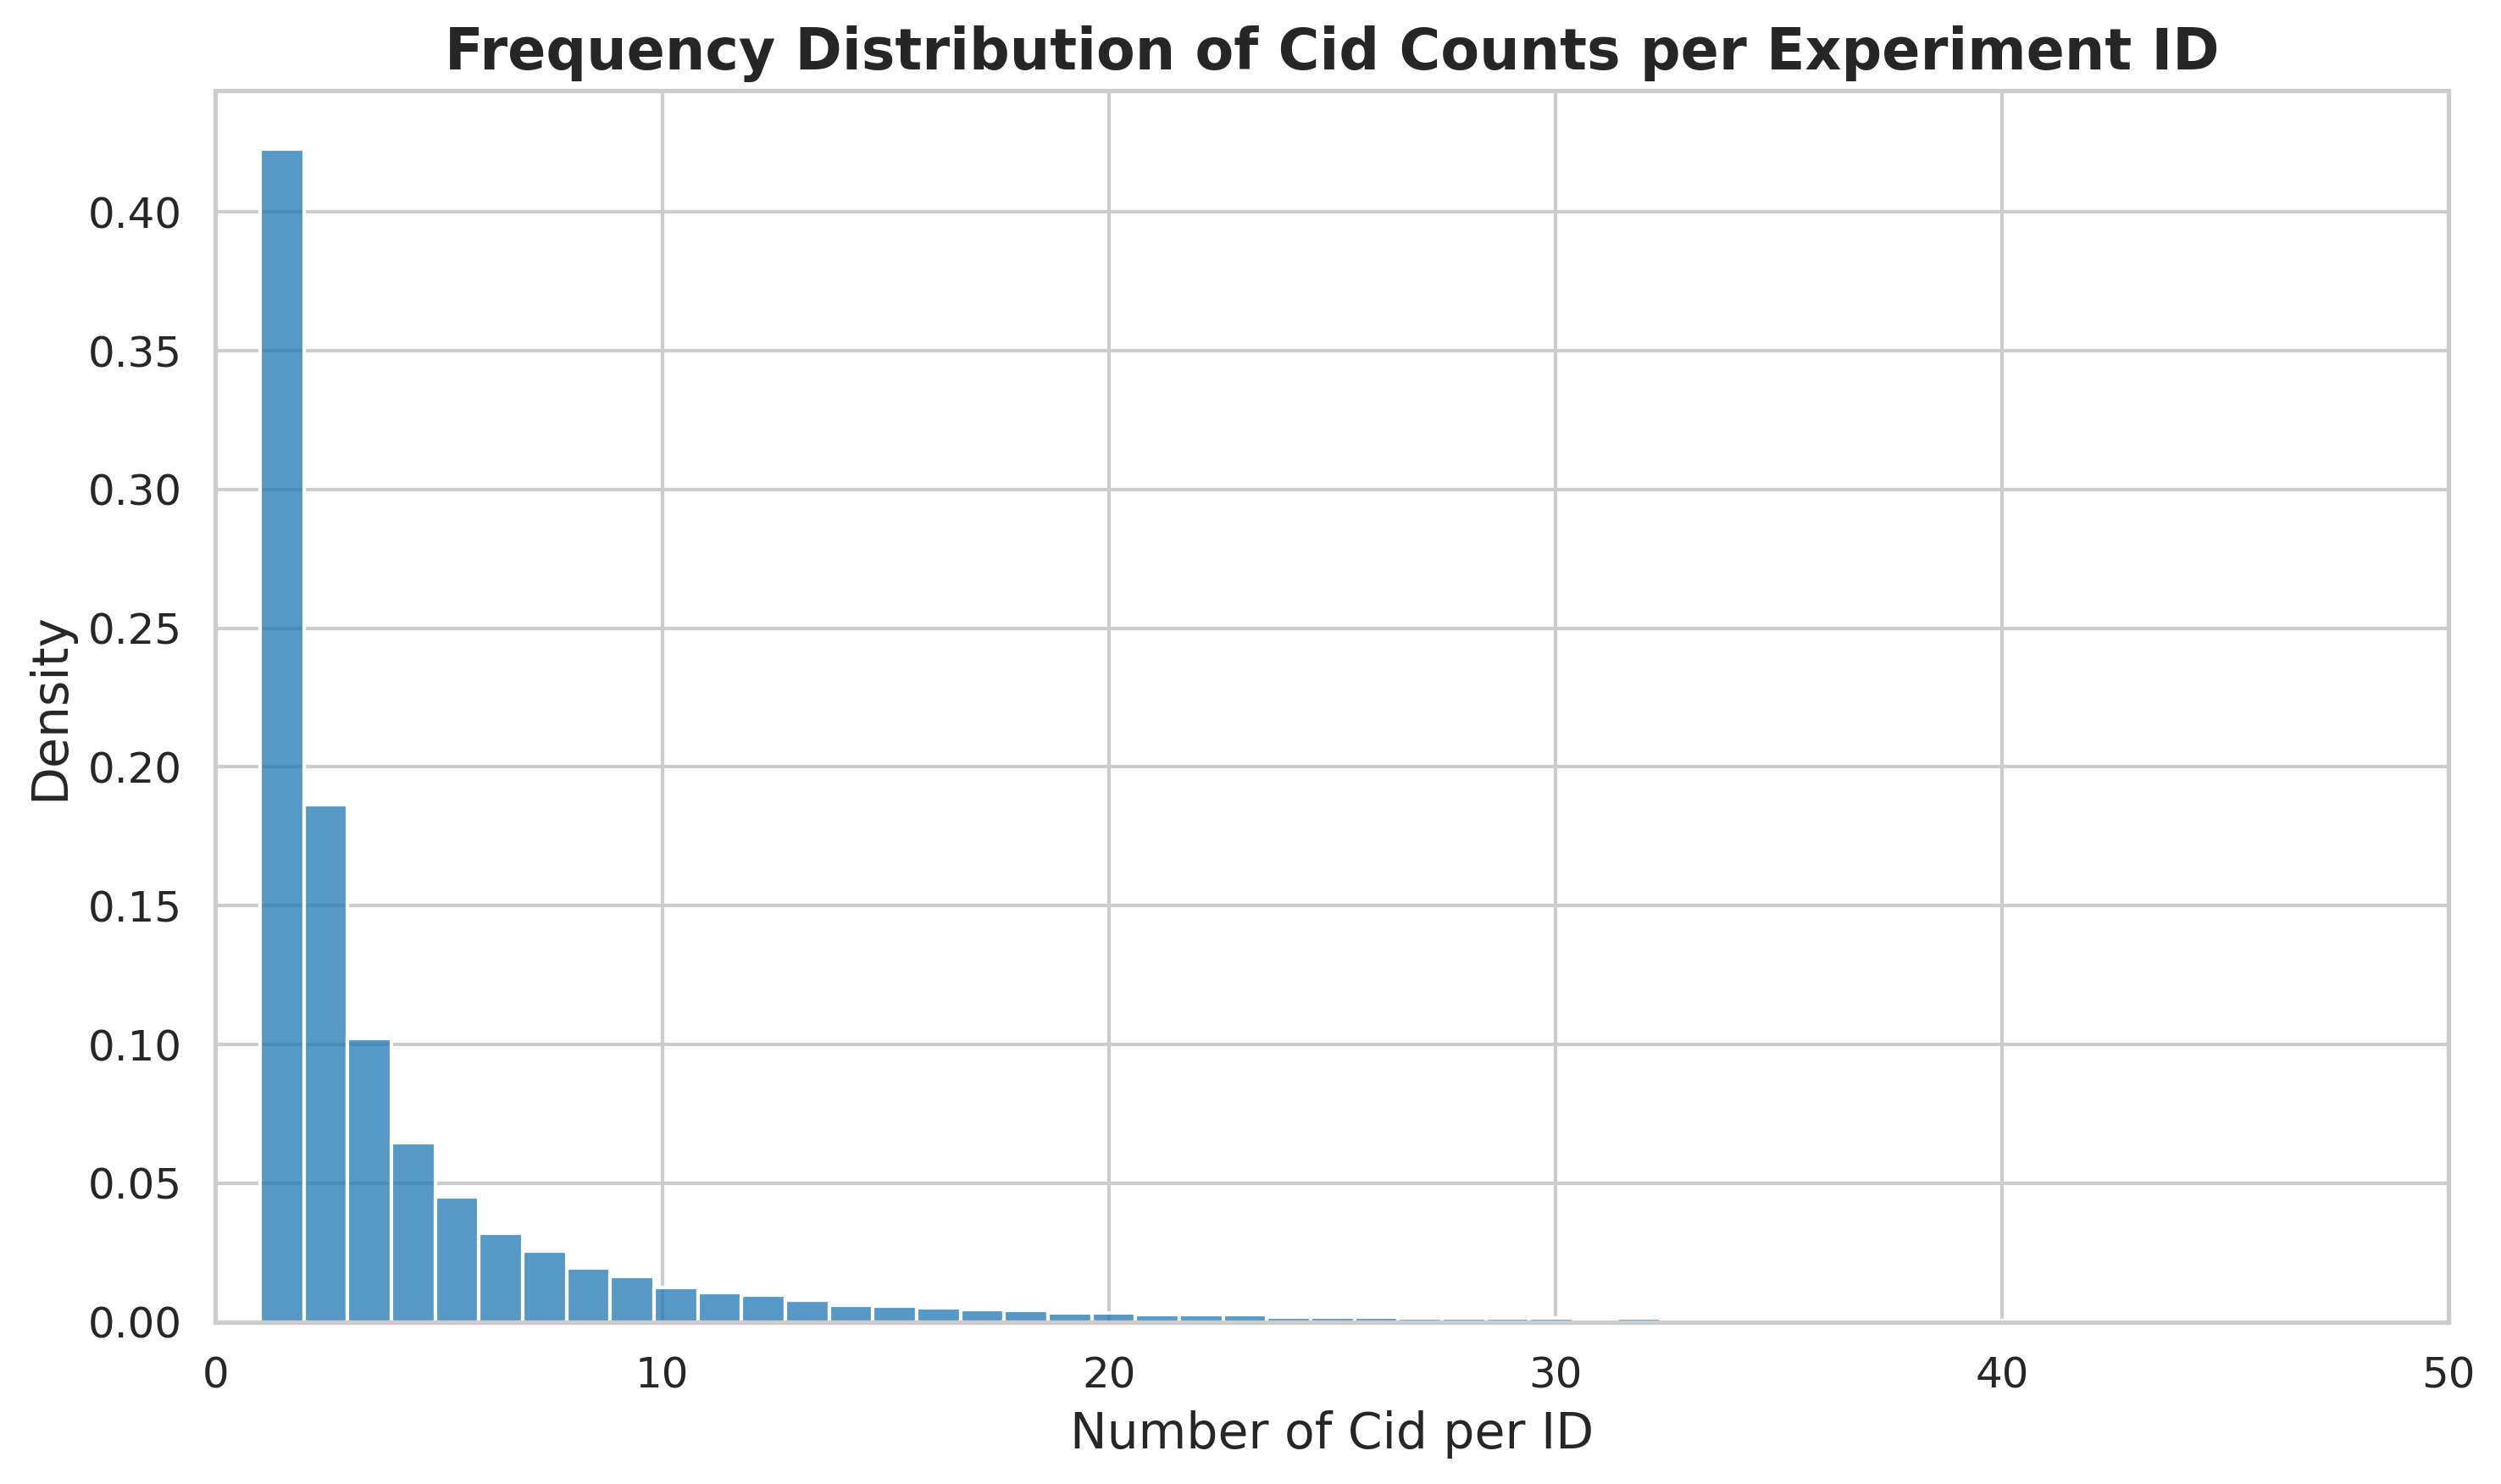

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 去掉极端值 > 50
data = NumC_of_E[NumC_of_E["NumC"] <= 50]

# 设置顶刊风格
sns.set(style="whitegrid")  # 干净网格背景
plt.figure(figsize=(10, 6), dpi=300)  # 高清输出

# 绘制频率分布直方图（去掉曲线）
sns.histplot(data=data, x="NumC", bins=50, stat="density", color="#1f77b4", edgecolor="white")

# 美化图表
plt.title("Frequency Distribution of Cid Counts per Experiment ID", fontsize=16, weight='bold')
plt.xlabel("Number of Cid per ID", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 50)  # 保持一致
plt.tight_layout()

# 保存高清图片
plt.savefig("NumC_of_E_distribution.png", dpi=600)  # 600dpi 高清
plt.show()
##=============================================##
#可以看出实验组控制组1对1的还是占据了大部分（约42%）

## STEP2 ——选择筛选方法

### Choice（1）—— 熵平衡法

### Choice（2）—— 1:1 最近邻匹配筛选法

In [50]:
import ast
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

df = E_C_df_clean.copy()

# 转换 tuple 格式为 list
def ensure_list(x):
    if isinstance(x, str):
        return list(ast.literal_eval(x))
    elif isinstance(x, tuple):
        return list(x)
    return x

df["E_vec"] = df["Ecitation_Before"].apply(ensure_list)
df["C_vec"] = df["Ccitation_Before"].apply(ensure_list)

# 统一长度（填充0到最大长度，避免不同长度报错）
max_len = max(df["E_vec"].map(len).max(), df["C_vec"].map(len).max())
df["E_vec"] = df["E_vec"].apply(lambda x: x + [0]*(max_len-len(x)))
df["C_vec"] = df["C_vec"].apply(lambda x: x + [0]*(max_len-len(x)))

# 构造矩阵
E_matrix = np.vstack(df["E_vec"].to_numpy())
C_matrix = np.vstack(df["C_vec"].to_numpy())

# 计算距离矩阵 (实验组 vs 对照组)
dist_matrix = pairwise_distances(E_matrix, C_matrix, metric="euclidean")

# 对每个实验组选一个最邻近对照组
closest_indices = dist_matrix.argmin(axis=1)

# 构建结果
E_C_df_1_1 = df.iloc[np.arange(len(df))].copy()
E_C_df_1_1["Matched_Cid"] = df.iloc[closest_indices]["Cid"].values
E_C_df_1_1["Matched_Ccitation_Before"] = df.iloc[closest_indices]["Ccitation_Before"].values

print(f"原始数据量：{len(df)}")
print(f"1:1匹配后数据量：{len(E_C_df_1_1)}")


: 

### Choice（3）—— 每年exactly

In [17]:
# 复制一份避免修改原数据
df = E_C_df_clean.copy()

# 如果列是字符串，需要转成 tuple 对象（安全解析）
def ensure_tuple(x):
    if isinstance(x, str):
        return tuple(ast.literal_eval(x))
    return x

df["Ecitation_Before"] = df["Ecitation_Before"].apply(ensure_tuple)
df["Ccitation_Before"] = df["Ccitation_Before"].apply(ensure_tuple)

# 筛选完全相等的行
E_C_df_exactly = df[df["Ecitation_Before"] == df["Ccitation_Before"]].copy()

print(f"原始数据量：{len(E_C_df_clean)}")
print(f"筛选后的数据量：{len(E_C_df_exactly)}")

原始数据量：277839
筛选后的数据量：10799


In [18]:
E_C_df_exactly

id             Cid Ecitation_Before Ccitation_Before  \
209832  pub.1030919255  pub.1000095973             (8,)             (8,)   
20198   pub.1035394167  pub.1000096886           (0, 1)           (0, 1)   
101881  pub.1023846303  pub.1000125211     (0, 1, 1, 0)     (0, 1, 1, 0)   
39470   pub.1027477675  pub.1000137716             (1,)             (1,)   
35941   pub.1030677750  pub.1000151708           (1, 2)           (1, 2)   
...                ...             ...              ...              ...   
32281   pub.1140129799  pub.1145724634             (1,)             (1,)   
32238   pub.1140129799  pub.1145724687             (1,)             (1,)   
286455  pub.1138062831  pub.1147316058             (1,)             (1,)   
88341   pub.1142354819  pub.1151737301             (1,)             (1,)   
227036  pub.1160206067  pub.1160117658           (1, 2)           (1, 2)   

                                          Ecitation_After  \
209832                  (20, 23, 16, 9, 7, 7, 4, 2, 2, 1)   
20198                                     (1, 0, 0, 0, 0)   
101881  (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
39470                              (8, 12, 10, 12, 11, 9)   
35941                               (2, 3, 4, 5, 4, 4, 4)   
...                                                   ...   
32281                                                (1,)   
32238                                                (1,)   
286455                                               (1,)   
88341                                                (0,)   
227036                              (2, 1, 1, 4, 5, 6, 4)   

                                          Ccitation_After  E_before_sum  \
209832           (28, 40, 41, 43, 47, 46, 45, 48, 38, 26)           NaN   
20198                                     (1, 0, 0, 0, 0)           NaN   
101881  (0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0, ...           NaN   
39470                                  (6, 8, 3, 1, 1, 1)           NaN   
35941                               (1, 5, 8, 9, 7, 2, 6)           NaN   
...                                                   ...           ...   
32281                                                (1,)           1.0   
32238                                                (1,)           1.0   
286455                                               (1,)           NaN   
88341                                                (1,)           NaN   
227036                             (3, 4, 8, 7, 4, 7, 11)           NaN   

        C_before_sum  diff  
209832           NaN   NaN  
20198            NaN   NaN  
101881           NaN   NaN  
39470            NaN   NaN  
35941            NaN   NaN  
...              ...   ...  
32281            1.0   0.0  
32238            1.0   0.0  
286455           NaN   NaN  
88341            NaN   NaN  
227036           NaN   NaN  

[10799 rows x 9 columns]

### Choice（4）—— slope3%+欧氏距离筛选

In [51]:
E_C_df_clean

id             Cid  \
54352   pub.1002168182  pub.1000000415   
54599   pub.1015882513  pub.1000000866   
12350   pub.1045901242  pub.1000000880   
142378  pub.1048460423  pub.1000000904   
287825  pub.1036532857  pub.1000002026   
...                ...             ...   
275622  pub.1160207011  pub.1160206984   
153372  pub.1160117955  pub.1160207207   
262078  pub.1160124941  pub.1160207321   
219228  pub.1160206333  pub.1160207579   
219231  pub.1160206333  pub.1160207611   

                                Ecitation_Before  \
54352                                       (7,)   
54599   (1, 8, 13, 11, 7, 11, 16, 11, 9, 13, 14)   
12350                     (9, 10, 7, 7, 6, 6, 7)   
142378               (0, 3, 3, 1, 1, 1, 3, 2, 1)   
287825                                 (0, 0, 1)   
...                                          ...   
275622   (1, 1, 0, 0, 3, 11, 16, 12, 8, 7, 7, 8)   
153372                        (0, 0, 0, 2, 4, 3)   
262078            (0, 2, 2, 2, 4, 3, 1, 1, 2, 4)   
219228                           (0, 0, 1, 1, 0)   
219231                           (0, 0, 1, 1, 0)   

                               Ccitation_Before  \
54352                                      (2,)   
54599   (7, 19, 26, 18, 15, 12, 11, 9, 6, 9, 4)   
12350                 (4, 5, 9, 15, 14, 13, 11)   
142378              (0, 2, 4, 4, 4, 5, 5, 3, 3)   
287825                                (7, 7, 6)   
...                                         ...   
275622     (0, 1, 2, 2, 4, 3, 3, 6, 5, 3, 2, 3)   
153372                       (0, 0, 0, 1, 1, 0)   
262078          (0, 4, 8, 9, 10, 8, 7, 5, 3, 9)   
219228                          (3, 3, 3, 2, 1)   
219231                          (1, 3, 2, 1, 2)   

                                          Ecitation_After  \
54352                     (9, 10, 15, 20, 17, 18, 17, 14)   
54599                (10, 11, 17, 16, 13, 14, 16, 18, 12)   
12350                                                (6,)   
142378  (1, 1, 1, 3, 4, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, ...   
287825                     (1, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
...                                                   ...   
275622                                     (14, 15, 7, 9)   
153372                                             (1, 0)   
262078                                             (3, 1)   
219228                                 (0, 1, 1, 0, 0, 0)   
219231                                 (0, 1, 1, 0, 0, 0)   

                                          Ccitation_After  E_before_sum  \
54352                            (4, 5, 7, 5, 2, 2, 2, 1)           NaN   
54599                        (0, 5, 10, 8, 4, 1, 2, 6, 6)           NaN   
12350                                                (9,)           NaN   
142378  (4, 4, 3, 5, 8, 7, 9, 10, 8, 7, 4, 4, 4, 2, 4,...           NaN   
287825                     (2, 1, 1, 2, 2, 1, 0, 0, 0, 0)           NaN   
...                                                   ...           ...   
275622                                       (3, 1, 0, 0)           NaN   
153372                                             (0, 0)           NaN   
262078                                           (14, 13)           NaN   
219228                                 (2, 2, 1, 1, 1, 0)           NaN   
219231                                 (2, 1, 1, 4, 4, 2)           NaN   

        C_before_sum  diff                                       log_E_Before  \
54352            NaN   NaN                              (2.0794415416798357,)   
54599            NaN   NaN  (0.6931471805599453, 2.197224577336219, 2.6390...   
12350            NaN   NaN  (2.3025850929940455, 2.3978952727983707, 2.079...   
142378           NaN   NaN  (0.0, 1.3862943611198906, 1.3862943611198906, ...   
287825           NaN   NaN                     (0.0, 0.0, 0.6931471805599453)   
...              ...   ...                                                ...   
275622           NaN   NaN  (0.6931471805599453, 0.6931471805599453, 0.0, ..

#### ①筛选代码

In [64]:
import ast 
import numpy as np
import pandas as pd
from scipy.stats import linregress

# ========= Step 1: 解析元组字符串为真正的 tuple =========
def parse_tuple_column(col):
    return col.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

E_C_df_clean['Ecitation_Before'] = parse_tuple_column(E_C_df_clean['Ecitation_Before'])
E_C_df_clean['Ccitation_Before'] = parse_tuple_column(E_C_df_clean['Ccitation_Before'])

# ========= Step 2: log(1+x) 变换 =========
def log_transform_tuple(col):
    return col.apply(lambda tup: tuple(np.log1p(np.array(tup))) if isinstance(tup, (tuple, list)) else tup)

E_C_df_clean['log_E_Before'] = log_transform_tuple(E_C_df_clean['Ecitation_Before'])
E_C_df_clean['log_C_Before'] = log_transform_tuple(E_C_df_clean['Ccitation_Before'])

# ========= Step 3: 定义计算线性回归斜率 =========
def get_slope(tup):
    if isinstance(tup, (tuple, list)) and len(tup) >= 2:
        x = np.arange(len(tup))
        y = np.array(tup)
        if np.all(y == y[0]):  # 所有值都一样，斜率=0
            return 0.0
        return linregress(x, y).slope
    else:
        return None  # 数据不足

E_C_df_clean['E_slope'] = E_C_df_clean['log_E_Before'].apply(get_slope)
E_C_df_clean['C_slope'] = E_C_df_clean['log_C_Before'].apply(get_slope)

# ========= Step 4: 斜率差值筛选 =========
slope_filtered = E_C_df_clean[
    E_C_df_clean['E_slope'].notnull() &
    E_C_df_clean['C_slope'].notnull() &
    ((E_C_df_clean['E_slope'] - E_C_df_clean['C_slope']).abs() < 0.05)
]


# ========= Step 5: 欧式距离函数 =========
def euclidean_distance(t1, t2):
    if not isinstance(t1, (tuple, list)) or not isinstance(t2, (tuple, list)):
        return np.nan
    max_len = max(len(t1), len(t2))
    v1 = np.array(list(t1) + [0] * (max_len - len(t1)))
    v2 = np.array(list(t2) + [0] * (max_len - len(t2)))
    return np.linalg.norm(v1 - v2)

# ========= Step 6: 计算欧式距离 =========
slope_filtered['euclidean_dist'] = slope_filtered.apply(
    lambda row: euclidean_distance(row['log_E_Before'], row['log_C_Before']), axis=1
)
d_filtered = slope_filtered.copy()
print(f"斜率筛选后剩余：{len(d_filtered)} 条")

# 设置阈值，比如 5
slope_filtered = slope_filtered[slope_filtered['euclidean_dist'] < 5]
print(f"欧氏距离阈值筛选后剩余：{len(slope_filtered)} 条")

# ========= Step 7: 每个实验组只保留欧氏距离最小的控制组 =========
# groupby 'id'（实验组），取欧氏距离最小的行
final_filtered = slope_filtered.loc[slope_filtered.groupby('id')['euclidean_dist'].idxmin()]

print(f"最终 1:1 匹配后剩余：{len(final_filtered)} 条")
# final_filtered 就是你要的最终 DataFrame


/tmp/ipykernel_2671689/487312817.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E_C_df_clean['Ecitation_Before'] = parse_tuple_column(E_C_df_clean['Ecitation_Before'])
/tmp/ipykernel_2671689/487312817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E_C_df_clean['Ccitation_Before'] = parse_tuple_column(E_C_df_clean['Ccitation_Before'])
/tmp/ipykernel_2671689/487312817.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

斜率筛选后剩余：34910 条
欧氏距离阈值筛选后剩余：32512 条
最终 1:1 匹配后剩余：15440 条


#### ②筛选欧式距离前的欧氏距离分布

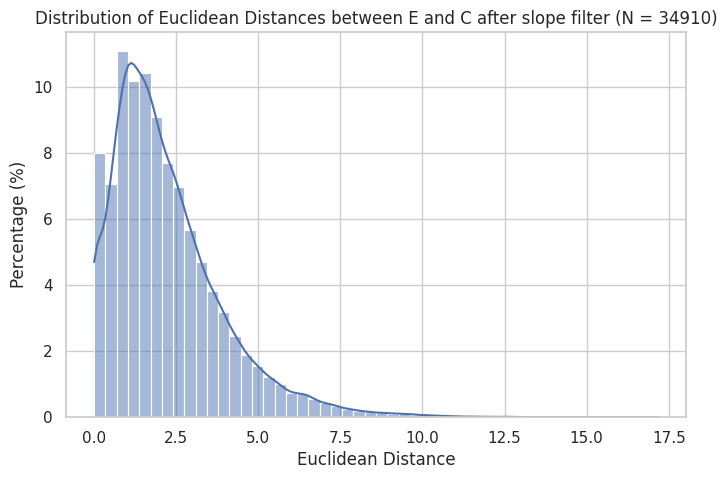

欧氏距离分布统计：
count    34910.000000
mean         2.214424
std          1.704624
min          0.000000
25%          0.985308
50%          1.834380
75%          3.012091
max         17.167974
Name: euclidean_dist, dtype: float64


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# 取斜率筛选后但未进行欧氏距离阈值筛选的欧氏距离
dist_series = d_filtered['euclidean_dist'].dropna()
N = len(dist_series)  # 只统计有效距离数量

plt.figure(figsize=(8, 5))
sns.histplot(dist_series, bins=50, kde=True, stat="percent")
plt.xlabel("Euclidean Distance")
plt.ylabel("Percentage (%)")
plt.title(f"Distribution of Euclidean Distances between E and C after slope filter (N = {N})")
plt.show()

# 打印统计信息
print("欧氏距离分布统计：")
print(dist_series.describe())


#### ③筛选欧氏距离后的欧氏距离分布

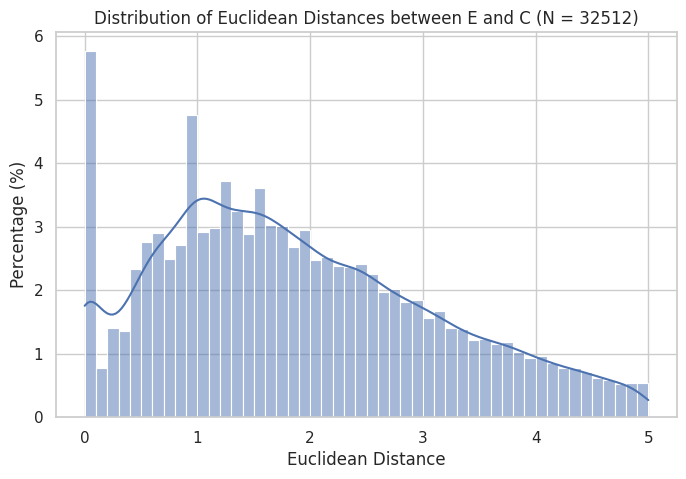

欧氏距离分布统计：
count    32512.000000
mean         1.895731
std          1.218273
min          0.000000
25%          0.980258
50%          1.712080
75%          2.717136
max          4.998925
Name: euclidean_dist, dtype: float64


In [66]:
# 取筛选后的欧氏距离
dist_series = slope_filtered['euclidean_dist'].dropna()
N = len(dist_series)

plt.figure(figsize=(8, 5))
sns.histplot(dist_series, bins=50, kde=True, stat="percent")
plt.xlabel("Euclidean Distance")
plt.ylabel("Percentage (%)")
plt.title(f"Distribution of Euclidean Distances between E and C (N = {N})")
plt.show()

# 打印统计信息
print("欧氏距离分布统计：")
print(dist_series.describe())


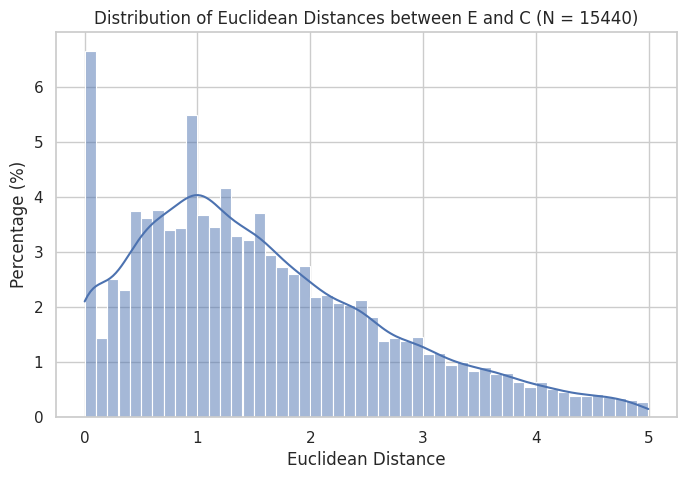

欧氏距离分布统计：
count    15440.000000
mean         1.592394
std          1.134911
min          0.000000
25%          0.724721
50%          1.373129
75%          2.280030
max          4.996955
Name: euclidean_dist, dtype: float64


In [67]:
# 取1:1筛选后的欧氏距离
dist_series = final_filtered['euclidean_dist'].dropna()
N = len(dist_series)

plt.figure(figsize=(8, 5))
sns.histplot(dist_series, bins=50, kde=True, stat="percent")
plt.xlabel("Euclidean Distance")
plt.ylabel("Percentage (%)")
plt.title(f"Distribution of Euclidean Distances between E and C (N = {N})")
plt.show()

# 打印统计信息
print("欧氏距离分布统计：")
print(dist_series.describe())

In [68]:
E_C_df_choice = final_filtered 

# 模块（五）：添加变量/创建面板

In [69]:
#筛选后的对照组：
E_C_df_choice

id             Cid  \
165668  pub.1000005995  pub.1004938182   
172104  pub.1000006527  pub.1037449214   
100885  pub.1000009303  pub.1008080322   
71455   pub.1000010986  pub.1024498716   
234910  pub.1000022002  pub.1015631823   
...                ...             ...   
233354  pub.1151690849  pub.1151692278   
169065  pub.1160114364  pub.1160116134   
153373  pub.1160117955  pub.1160116867   
262078  pub.1160124941  pub.1160207321   
227036  pub.1160206067  pub.1160117658   

                                  Ecitation_Before  \
165668               (4, 14, 11, 5, 8, 6, 8, 8, 8)   
172104                                      (4, 6)   
100885                     (4, 12, 12, 14, 16, 13)   
71455                (3, 12, 12, 3, 1, 2, 2, 3, 6)   
234910  (8, 12, 10, 12, 13, 15, 17, 17, 19, 15, 8)   
...                                            ...   
233354                       (4, 4, 4, 4, 4, 6, 6)   
169065                      (11, 7, 3, 6, 7, 4, 1)   
153373                          (0, 0, 0, 2, 4, 3)   
262078              (0, 2, 2, 2, 4, 3, 1, 1, 2, 4)   
227036                                      (1, 2)   

                           Ccitation_Before  \
165668        (5, 12, 8, 2, 3, 5, 5, 9, 14)   
172104                               (2, 3)   
100885              (2, 14, 16, 10, 13, 13)   
71455         (5, 14, 10, 3, 3, 3, 5, 6, 3)   
234910  (5, 9, 11, 8, 8, 11, 8, 9, 7, 6, 6)   
...                                     ...   
233354                (0, 4, 7, 5, 3, 3, 2)   
169065                (1, 3, 3, 1, 0, 0, 0)   
153373                   (0, 1, 1, 5, 8, 5)   
262078      (0, 4, 8, 9, 10, 8, 7, 5, 3, 9)   
227036                               (1, 2)   

                          Ecitation_After                     Ccitation_After  \
165668                               (8,)                               (10,)   
172104              (4, 2, 0, 0, 0, 1, 2)               (2, 3, 3, 2, 3, 3, 1)   
100885           (14, 13, 8, 3, 6, 10, 7)             (11, 6, 5, 9, 10, 8, 5)   
71455                                (4,)                                (2,)   
234910           (11, 15, 11, 8, 8, 5, 7)               (3, 2, 0, 1, 3, 3, 2)   
...                                   ...                                 ...   
233354  (4, 1, 0, 2, 3, 2, 2, 4, 6, 3, 1)  (0, 5, 6, 2, 2, 1, 3, 4, 3, 8, 13)   
169065                               (0,)                                (1,)   
153373                             (1, 0)                              (4, 3)   
262078                             (3, 1)                            (14, 13)   
227036              (2, 1, 1, 4, 5, 6, 4)              (3, 4, 8, 7, 4, 7, 11)   

        E_before_sum  C_before_sum  diff  \
165668           NaN           NaN   NaN   
172104           NaN           NaN   NaN   
100885           NaN           NaN   NaN   
71455            NaN           NaN   NaN   
234910           NaN           NaN   NaN   
...              ...           ...   ...   
233354           NaN           NaN   NaN   
169065           NaN           NaN   NaN   
153373           NaN           NaN   NaN   
262078           NaN           NaN   NaN   
227036           NaN           NaN   NaN   

                                             log_E_Before  \
165668  (1.6094379124341003, 2.70805020110221, 2.48490...   
172104           (1.6094379124341003, 1.9459101490553132)   
100885  (1.6094379124341003, 2.5649493574615367, 2.564...   
71455   (1.3862943611198906, 2.5649493574615367, 2.564...   
234910  (2.197224577336219, 2.5649493574615367, 2.3978...   
...                                                   ...   
233354  (1.6094379124341003, 1.6094379124341003, 1.609...   
169065  (2.4849066497880004, 2.0794415416798357, 1.386...   
153373  (0.0, 0.0, 0.0, 1.0986122886681096, 1.60943791...   
262078  (0.0, 1.0986122886681096, 1.0986122886681096, ...   
227036           (0.6931471805599453, 1.0986122886681096)   

                                             log_C_Before   E_slop

## STEP1——添加变量

### 一些基础的变量

In [ ]:
#为了能够进一步进行展开面板的操作，我需要增添几个维度的数据
#增添后数据结构如下：
# id————实验组论文唯一标识符
# Cid————控制组论文唯一标识符
# Ecitation_Before	
# Ccitation_Before	
# Ecitation_After	
# Ccitation_After
# PYear
# Journal_id
# NumA、NumR
# reference_ids 
# RPYear
# RYear
# RJournal_id
# Now
# T_PtoR
# T_RtoN

In [70]:
# 需要匹配的列
cols_to_merge = [
    "PYear", "Journal_id", "NumA", "NumR", "reference_ids",
    "RPYear", "RYear", "RJournal_id", "Now", "T_PtoR", "T_RtoN"
]

# 以 E_C_df_choice 为基础，左连接
E_C_df_merged = E_C_df_choice.merge(
    df_merged_ECR[["id"] + cols_to_merge],  # 只取需要的列
    on="id",
    how="left"
)

# 去掉 id + Cid 重复的行
E_C_df_merged = E_C_df_merged.drop_duplicates(subset=["id", "Cid"])

In [71]:
E_C_df_merged

id             Cid  \
0       pub.1000005995  pub.1004938182   
3       pub.1000006527  pub.1037449214   
7       pub.1000009303  pub.1008080322   
21      pub.1000010986  pub.1024498716   
33      pub.1000022002  pub.1015631823   
...                ...             ...   
157883  pub.1151690849  pub.1151692278   
157884  pub.1160114364  pub.1160116134   
157886  pub.1160117955  pub.1160116867   
157889  pub.1160124941  pub.1160207321   
157890  pub.1160206067  pub.1160117658   

                                  Ecitation_Before  \
0                    (4, 14, 11, 5, 8, 6, 8, 8, 8)   
3                                           (4, 6)   
7                          (4, 12, 12, 14, 16, 13)   
21                   (3, 12, 12, 3, 1, 2, 2, 3, 6)   
33      (8, 12, 10, 12, 13, 15, 17, 17, 19, 15, 8)   
...                                            ...   
157883                       (4, 4, 4, 4, 4, 6, 6)   
157884                      (11, 7, 3, 6, 7, 4, 1)   
157886                          (0, 0, 0, 2, 4, 3)   
157889              (0, 2, 2, 2, 4, 3, 1, 1, 2, 4)   
157890                                      (1, 2)   

                           Ccitation_Before  \
0             (5, 12, 8, 2, 3, 5, 5, 9, 14)   
3                                    (2, 3)   
7                   (2, 14, 16, 10, 13, 13)   
21            (5, 14, 10, 3, 3, 3, 5, 6, 3)   
33      (5, 9, 11, 8, 8, 11, 8, 9, 7, 6, 6)   
...                                     ...   
157883                (0, 4, 7, 5, 3, 3, 2)   
157884                (1, 3, 3, 1, 0, 0, 0)   
157886                   (0, 1, 1, 5, 8, 5)   
157889      (0, 4, 8, 9, 10, 8, 7, 5, 3, 9)   
157890                               (1, 2)   

                          Ecitation_After                     Ccitation_After  \
0                                    (8,)                               (10,)   
3                   (4, 2, 0, 0, 0, 1, 2)               (2, 3, 3, 2, 3, 3, 1)   
7                (14, 13, 8, 3, 6, 10, 7)             (11, 6, 5, 9, 10, 8, 5)   
21                                   (4,)                                (2,)   
33               (11, 15, 11, 8, 8, 5, 7)               (3, 2, 0, 1, 3, 3, 2)   
...                                   ...                                 ...   
157883  (4, 1, 0, 2, 3, 2, 2, 4, 6, 3, 1)  (0, 5, 6, 2, 2, 1, 3, 4, 3, 8, 13)   
157884                               (0,)                                (1,)   
157886                             (1, 0)                              (4, 3)   
157889                             (3, 1)                            (14, 13)   
157890              (2, 1, 1, 4, 5, 6, 4)              (3, 4, 8, 7, 4, 7, 11)   

        E_before_sum  C_before_sum  diff  \
0                NaN           NaN   NaN   
3                NaN           NaN   NaN   
7                NaN           NaN   NaN   
21               NaN           NaN   NaN   
33               NaN           NaN   NaN   
...              ...           ...   ...   
157883           NaN           NaN   NaN   
157884           NaN           NaN   NaN   
157886           NaN           NaN   NaN   
157889           NaN           NaN   NaN   
157890           NaN           NaN   NaN   

                                             log_E_Before  ...    Journal_id  \
0       (1.6094379124341003, 2.70805020110221, 2.48490...  ...  jour.1135213   
3                (1.6094379124341003, 1.9459101490553132)  ...  jour.1077138   
7       (1.6094379124341003, 2.5649493574615367, 2.564...  ...  jour.1077138   
21      (1.3862943611198906, 2.5649493574615367, 2.564...  ...  jour.1046724   
33      (2.197224577336219, 2.5649493574615367, 2.3978...  ...  jour.1017523   
...                                                   ...  ...           ...   
157883  (1.6094379124341003, 1.6094379124341003, 1.609...  ...  jour.1430349   
157884  (2.4849066497880004, 2.0794415416798357, 1.386...  ...  jour.1053565   
157886  (0.0, 0.0, 0.0, 1.0986122886681096, 1.60943791...  ...  jour.1053565   

In [72]:
# 检查实验组 id 是否有重复
dup_ids = E_C_df_merged[E_C_df_merged['id'].duplicated(keep=False)]
print(f"重复的实验组 id 数量: {dup_ids['id'].nunique()}")
print(f"涉及的重复行数: {len(dup_ids)}")

# 检查对照组 Cid 是否有重复
dup_cids = E_C_df_merged[E_C_df_merged['Cid'].duplicated(keep=False)]
print(f"重复的对照组 Cid 数量: {dup_cids['Cid'].nunique()}")
print(f"涉及的重复行数: {len(dup_cids)}")


重复的实验组 id 数量: 0
涉及的重复行数: 0
重复的对照组 Cid 数量: 0
涉及的重复行数: 0


### 实验组论文、控制组论文、撤稿论文的JCR分区

In [ ]:
#等到主效应显著了就干

## STEP2——创建面板

In [ ]:
#转化为：
#列名如下：
# group --- 0\1 (0为控制组，1为实验组)
# paper_id --- 即id与Cid
# year --- 观测年份，从PYear开始到2023结束，面板数据形式
# PYear --- 实验组对照组论文发表年份
# RYear --- 实验组参考论文撤稿年份
# yearlycitation --- 对于实验组id，将Ecitation_Before与Ecitation_After依年拆开；对于对照组id，将Ccitation_Before与Ccitation_After依年拆开
# log_yearlycitation --- 即yearlycitation加1取对数
# treated --- RYear前的观测年分为0，RYear后的观测年分为1
# did --- 即group与treated的乘积，同时满足RYear之后以及实验组的身份即为1
# pd --- 观测年分距离RYear的距离，比如观测年分为2014，RYear为2015，则该观测年的pd为-1；观测年分为2016，RYear为2015，则该观测年的pd为1
# numa --- 作者数
# numr --- 参考文献数


### 拆分

In [73]:
# 假设 E_C_df_merged DataFrame，这里先取前两行做示例
df_sample = E_C_df_merged.copy()

panel_rows = []

for _, row in df_sample.iterrows():
    # ----------------------------
    # 先处理实验组
    # ----------------------------
    exp_citations = []
    # 拼接 Before 和 After 引用列表
    for col in ["Ecitation_Before", "Ecitation_After"]:
        val = row[col]
        if isinstance(val, str):
            val = ast.literal_eval(val)
        exp_citations.extend(val)

    years = list(range(int(row["PYear"]), 2022 + 1))  # 年份截至2022
    # 如果引用数长度与年份数不一致，用 NaN 填充
    if len(exp_citations) < len(years):
        exp_citations.extend([np.nan]*(len(years)-len(exp_citations)))

    for y, c in zip(years, exp_citations):
        treated = 1 if y > row["RYear"] else 0
        panel_rows.append({
            "group": 1,
            "paper_id": row["id"],
            "year": y,
            "PYear": row["PYear"],
            "RYear": row["RYear"],
            "yearlycitation": c,
            "log_yearlycitation": np.log1p(c) if pd.notna(c) else np.nan,
            "treated": treated,
            "did": treated * 1,  # group=1 for experiment
            "pd": y - row["RYear"],
            "numa": row["NumA"],
            "numr": row["NumR"]
        })

    # ----------------------------
    # 再处理对照组
    # ----------------------------
    ctrl_citations = []
    for col in ["Ccitation_Before", "Ccitation_After"]:
        val = row[col]
        if isinstance(val, str):
            val = ast.literal_eval(val)
        ctrl_citations.extend(val)

    for y, c in zip(years, ctrl_citations):
        treated = 1 if y > row["RYear"] else 0
        panel_rows.append({
            "group": 0,
            "paper_id": row["Cid"],
            "year": y,
            "PYear": row["PYear"],
            "RYear": row["RYear"],
            "yearlycitation": c,
            "log_yearlycitation": np.log1p(c) if pd.notna(c) else np.nan,
            "treated": treated,
            "did": treated * 0,  # group=0 for control
            "pd": y - row["RYear"],
            "numa": row["NumA"],
            "numr": row["NumR"]
        })

# 生成面板数据 DataFrame
panel_df = pd.DataFrame(panel_rows)
#去重
panel_df = panel_df.drop_duplicates(subset=["paper_id", "year"])

# 给每个 paper_id 编号
paper_id_map = {pid: i for i, pid in enumerate(panel_df["paper_id"].unique(), start=1)}
panel_df["paper_numid"] = panel_df["paper_id"].map(paper_id_map)

In [74]:
panel_df

group        paper_id  year  PYear   RYear  yearlycitation  \
0           1  pub.1000005995  2013   2013  2022.0               4   
1           1  pub.1000005995  2014   2013  2022.0              14   
2           1  pub.1000005995  2015   2013  2022.0              11   
3           1  pub.1000005995  2016   2013  2022.0               5   
4           1  pub.1000005995  2017   2013  2022.0               8   
...       ...             ...   ...    ...     ...             ...   
372959      0  pub.1160117658  2018   2014  2016.0               8   
372960      0  pub.1160117658  2019   2014  2016.0               7   
372961      0  pub.1160117658  2020   2014  2016.0               4   
372962      0  pub.1160117658  2021   2014  2016.0               7   
372963      0  pub.1160117658  2022   2014  2016.0              11   

        log_yearlycitation  treated  did   pd  numa  numr  paper_numid  
0                 1.609438        0    0 -9.0     5    34            1  
1                 2.708050        0    0 -8.0     5    34            1  
2                 2.484907        0    0 -7.0     5    34            1  
3                 1.791759        0    0 -6.0     5    34            1  
4                 2.197225        0    0 -5.0     5    34            1  
...                    ...      ...  ...  ...   ...   ...          ...  
372959            2.197225        1    0  2.0     4    33        30880  
372960            2.079442        1    0  3.0     4    33        30880  
372961            1.609438        1    0  4.0     4    33        30880  
372962            2.079442        1    0  5.0     4    33        30880  
372963            2.484907        1    0  6.0     4    33        30880  

[372964 rows x 13 columns]

### 保存数据

In [75]:
output_path = '/Data4/yutao_wen/25.9.17/panel_df_slope0.3_D5_1_1.csv'
# 保存为 CSV 文件
panel_df.to_csv(output_path, index=False)

# 模块（六）：Stata补充绘图

## 库

In [34]:
import statsmodels.formula.api as smf


## panel_df_slope0.3_D5_1_1基础信息

In [76]:
# 新建两列
panel_df["T_PtoR"] = panel_df["RYear"] - panel_df["PYear"]   # RYear - PYear
panel_df["T_RtoN"] = 2023 - panel_df["RYear"]               # 2023 - RYear

In [126]:
panel_df

group        paper_id  year  PYear   RYear  yearlycitation  \
0           1  pub.1000005995  2013   2013  2022.0               4   
1           1  pub.1000005995  2014   2013  2022.0              14   
2           1  pub.1000005995  2015   2013  2022.0              11   
3           1  pub.1000005995  2016   2013  2022.0               5   
4           1  pub.1000005995  2017   2013  2022.0               8   
...       ...             ...   ...    ...     ...             ...   
372959      0  pub.1160117658  2018   2014  2016.0               8   
372960      0  pub.1160117658  2019   2014  2016.0               7   
372961      0  pub.1160117658  2020   2014  2016.0               4   
372962      0  pub.1160117658  2021   2014  2016.0               7   
372963      0  pub.1160117658  2022   2014  2016.0              11   

        log_yearlycitation  treated  did   pd  numa  numr  paper_numid  \
0                 1.609438        0    0 -9.0     5    34            1   
1                 2.708050        0    0 -8.0     5    34            1   
2                 2.484907        0    0 -7.0     5    34            1   
3                 1.791759        0    0 -6.0     5    34            1   
4                 2.197225        0    0 -5.0     5    34            1   
...                    ...      ...  ...  ...   ...   ...          ...   
372959            2.197225        1    0  2.0     4    33        30880   
372960            2.079442        1    0  3.0     4    33        30880   
372961            1.609438        1    0  4.0     4    33        30880   
372962            2.079442        1    0  5.0     4    33        30880   
372963            2.484907        1    0  6.0     4    33        30880   

        T_PtoR  T_RtoN  
0          9.0     1.0  
1          9.0     1.0  
2          9.0     1.0  
3          9.0     1.0  
4          9.0     1.0  
...        ...     ...  
372959     2.0     7.0  
372960     2.0     7.0  
372961     2.0     7.0  
372962     2.0     7.0  
372963     2.0     7.0  

[372964 rows x 15 columns]

### PYear

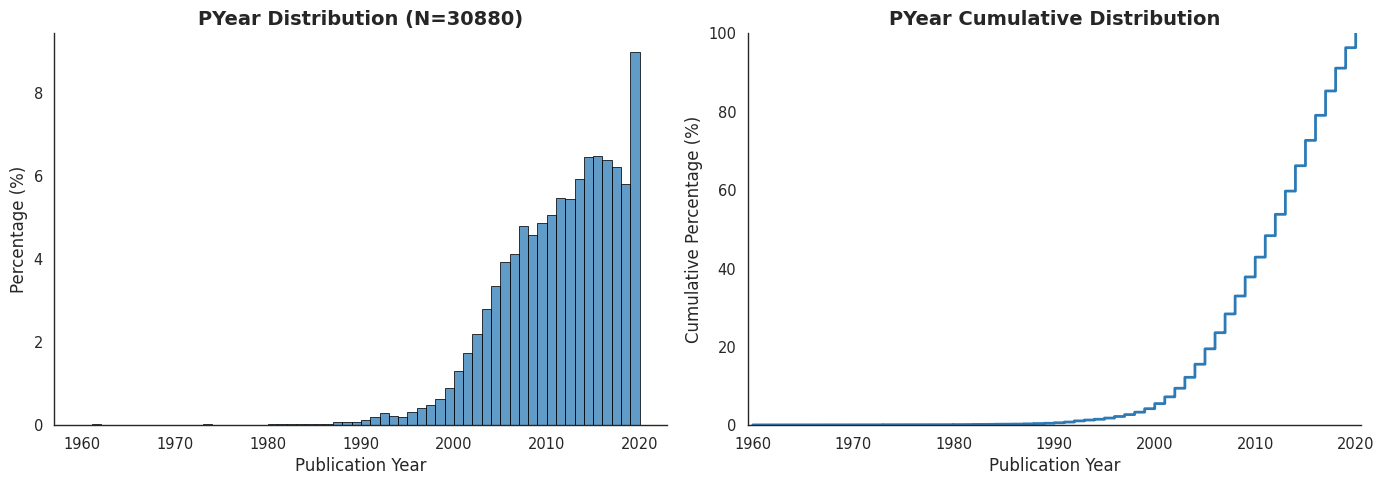

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 按 paper_numid 去重
unique_papers = panel_df.drop_duplicates(subset="paper_numid")

# 样本数量
N = len(unique_papers)

# 设置Nature风格
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# 设置画布：2个图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 横向排列
axes = axes.flatten()

# ---------------- PYear 柱状图 ----------------
sns.histplot(
    unique_papers["PYear"], 
    bins=range(int(unique_papers["PYear"].min()), int(unique_papers["PYear"].max())+1),
    stat="percent",
    kde=False,
    color="#2c7bb6",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title(f"PYear Distribution (N={N})", fontsize=14, weight='bold')
axes[0].set_xlabel("Publication Year", fontsize=12)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# ---------------- PYear 累积分布 ----------------
pyear_sorted = np.sort(unique_papers["PYear"])
cdf_pyear = np.arange(1, len(pyear_sorted)+1) / len(pyear_sorted) * 100
axes[1].step(pyear_sorted, cdf_pyear, where='post', color="#2c7bb6", linewidth=2)
axes[1].set_title("PYear Cumulative Distribution", fontsize=14, weight='bold')
axes[1].set_xlabel("Publication Year", fontsize=12)
axes[1].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[1].set_xlim(pyear_sorted.min()-0.5, pyear_sorted.max()+0.5)
axes[1].set_ylim(0, 100)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### T_PtoR and T_RtoN

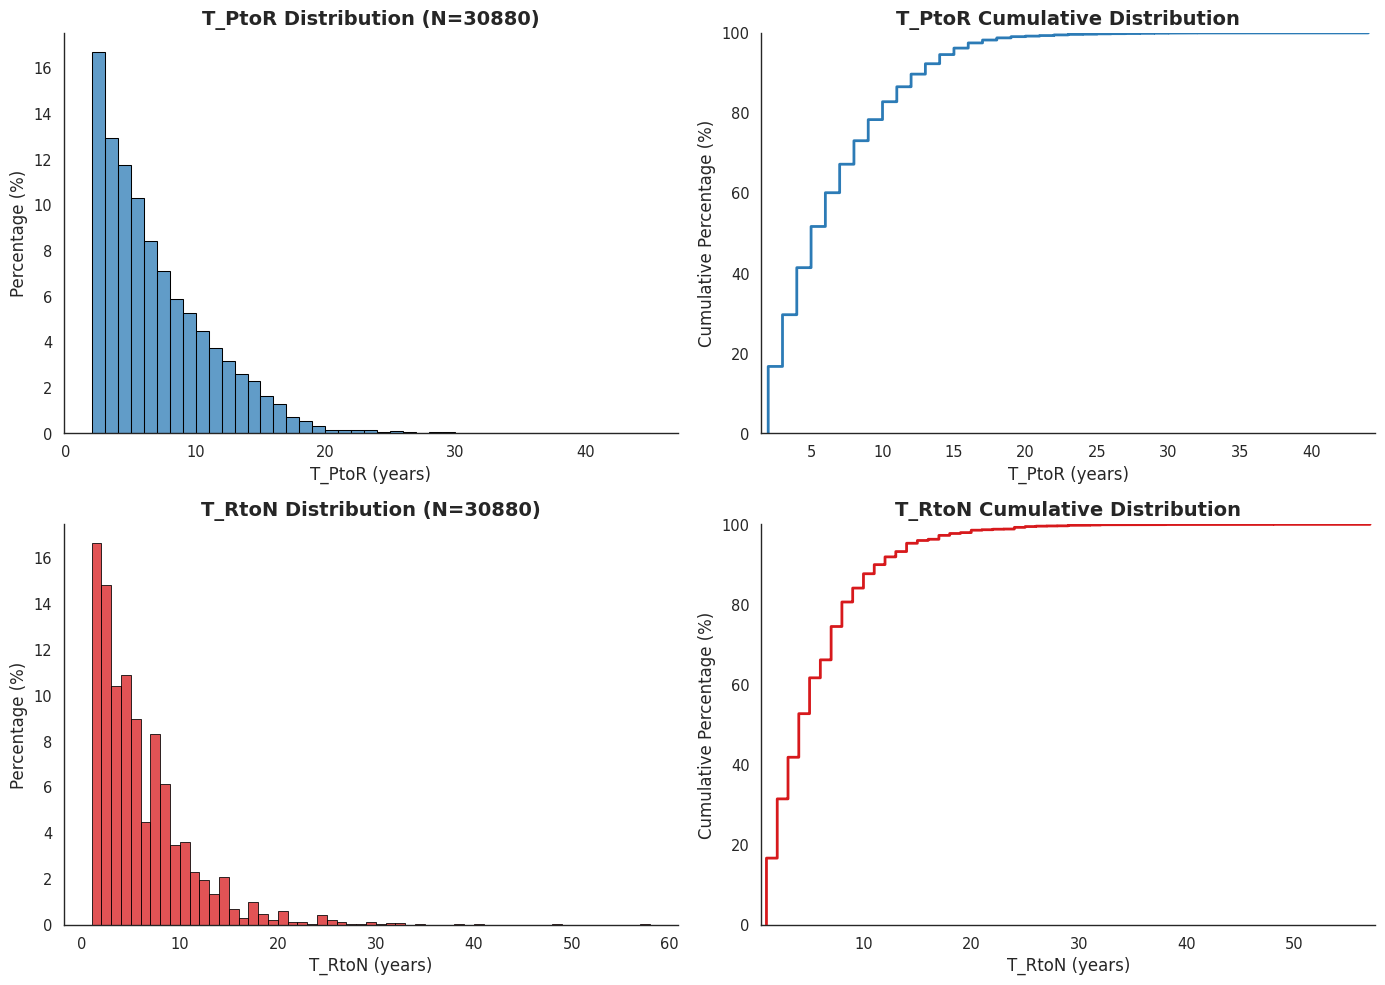

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 按 paper_numid 去重，只保留一条记录
unique_papers = panel_df.drop_duplicates(subset="paper_numid")

# 样本数量
N = len(unique_papers)

# 设置Nature风格
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# 设置画布：两个柱状图 + 两个累积分布曲线
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2布局
axes = axes.flatten()  # 方便索引

# ---------------- T_PtoR 柱状图 ----------------
sns.histplot(
    unique_papers["T_PtoR"], 
    bins=range(int(unique_papers["T_PtoR"].min()), int(unique_papers["T_PtoR"].max())+2),
    stat="percent",
    kde=False,
    color="#2c7bb6",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title(f"T_PtoR Distribution (N={N})", fontsize=14, weight='bold')
axes[0].set_xlabel("T_PtoR (years)", fontsize=12)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# ---------------- T_PtoR 累积分布 ----------------
t_ptor_sorted = np.sort(unique_papers["T_PtoR"])
cdf_ptor = np.arange(1, len(t_ptor_sorted)+1) / len(t_ptor_sorted) * 100  # 百分比
axes[1].step(t_ptor_sorted, cdf_ptor, where='post', color="#2c7bb6", linewidth=2)
axes[1].set_title("T_PtoR Cumulative Distribution", fontsize=14, weight='bold')
axes[1].set_xlabel("T_PtoR (years)", fontsize=12)
axes[1].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[1].set_xlim(t_ptor_sorted.min()-0.5, t_ptor_sorted.max()+0.5)
axes[1].set_ylim(0, 100)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# ---------------- T_RtoN 柱状图 ----------------
sns.histplot(
    unique_papers["T_RtoN"], 
    bins=range(int(unique_papers["T_RtoN"].min()), int(unique_papers["T_RtoN"].max())+2),
    stat="percent",
    kde=False,
    color="#d7191c",
    edgecolor="black",
    ax=axes[2]
)
axes[2].set_title(f"T_RtoN Distribution (N={N})", fontsize=14, weight='bold')
axes[2].set_xlabel("T_RtoN (years)", fontsize=12)
axes[2].set_ylabel("Percentage (%)", fontsize=12)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# ---------------- T_RtoN 累积分布 ----------------
t_rton_sorted = np.sort(unique_papers["T_RtoN"])
cdf_rton = np.arange(1, len(t_rton_sorted)+1) / len(t_rton_sorted) * 100
axes[3].step(t_rton_sorted, cdf_rton, where='post', color="#d7191c", linewidth=2)
axes[3].set_title("T_RtoN Cumulative Distribution", fontsize=14, weight='bold')
axes[3].set_xlabel("T_RtoN (years)", fontsize=12)
axes[3].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[3].set_xlim(t_rton_sorted.min()-0.5, t_rton_sorted.max()+0.5)
axes[3].set_ylim(0, 100)
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### numa和numr实验组控制组分布（2000-2015）

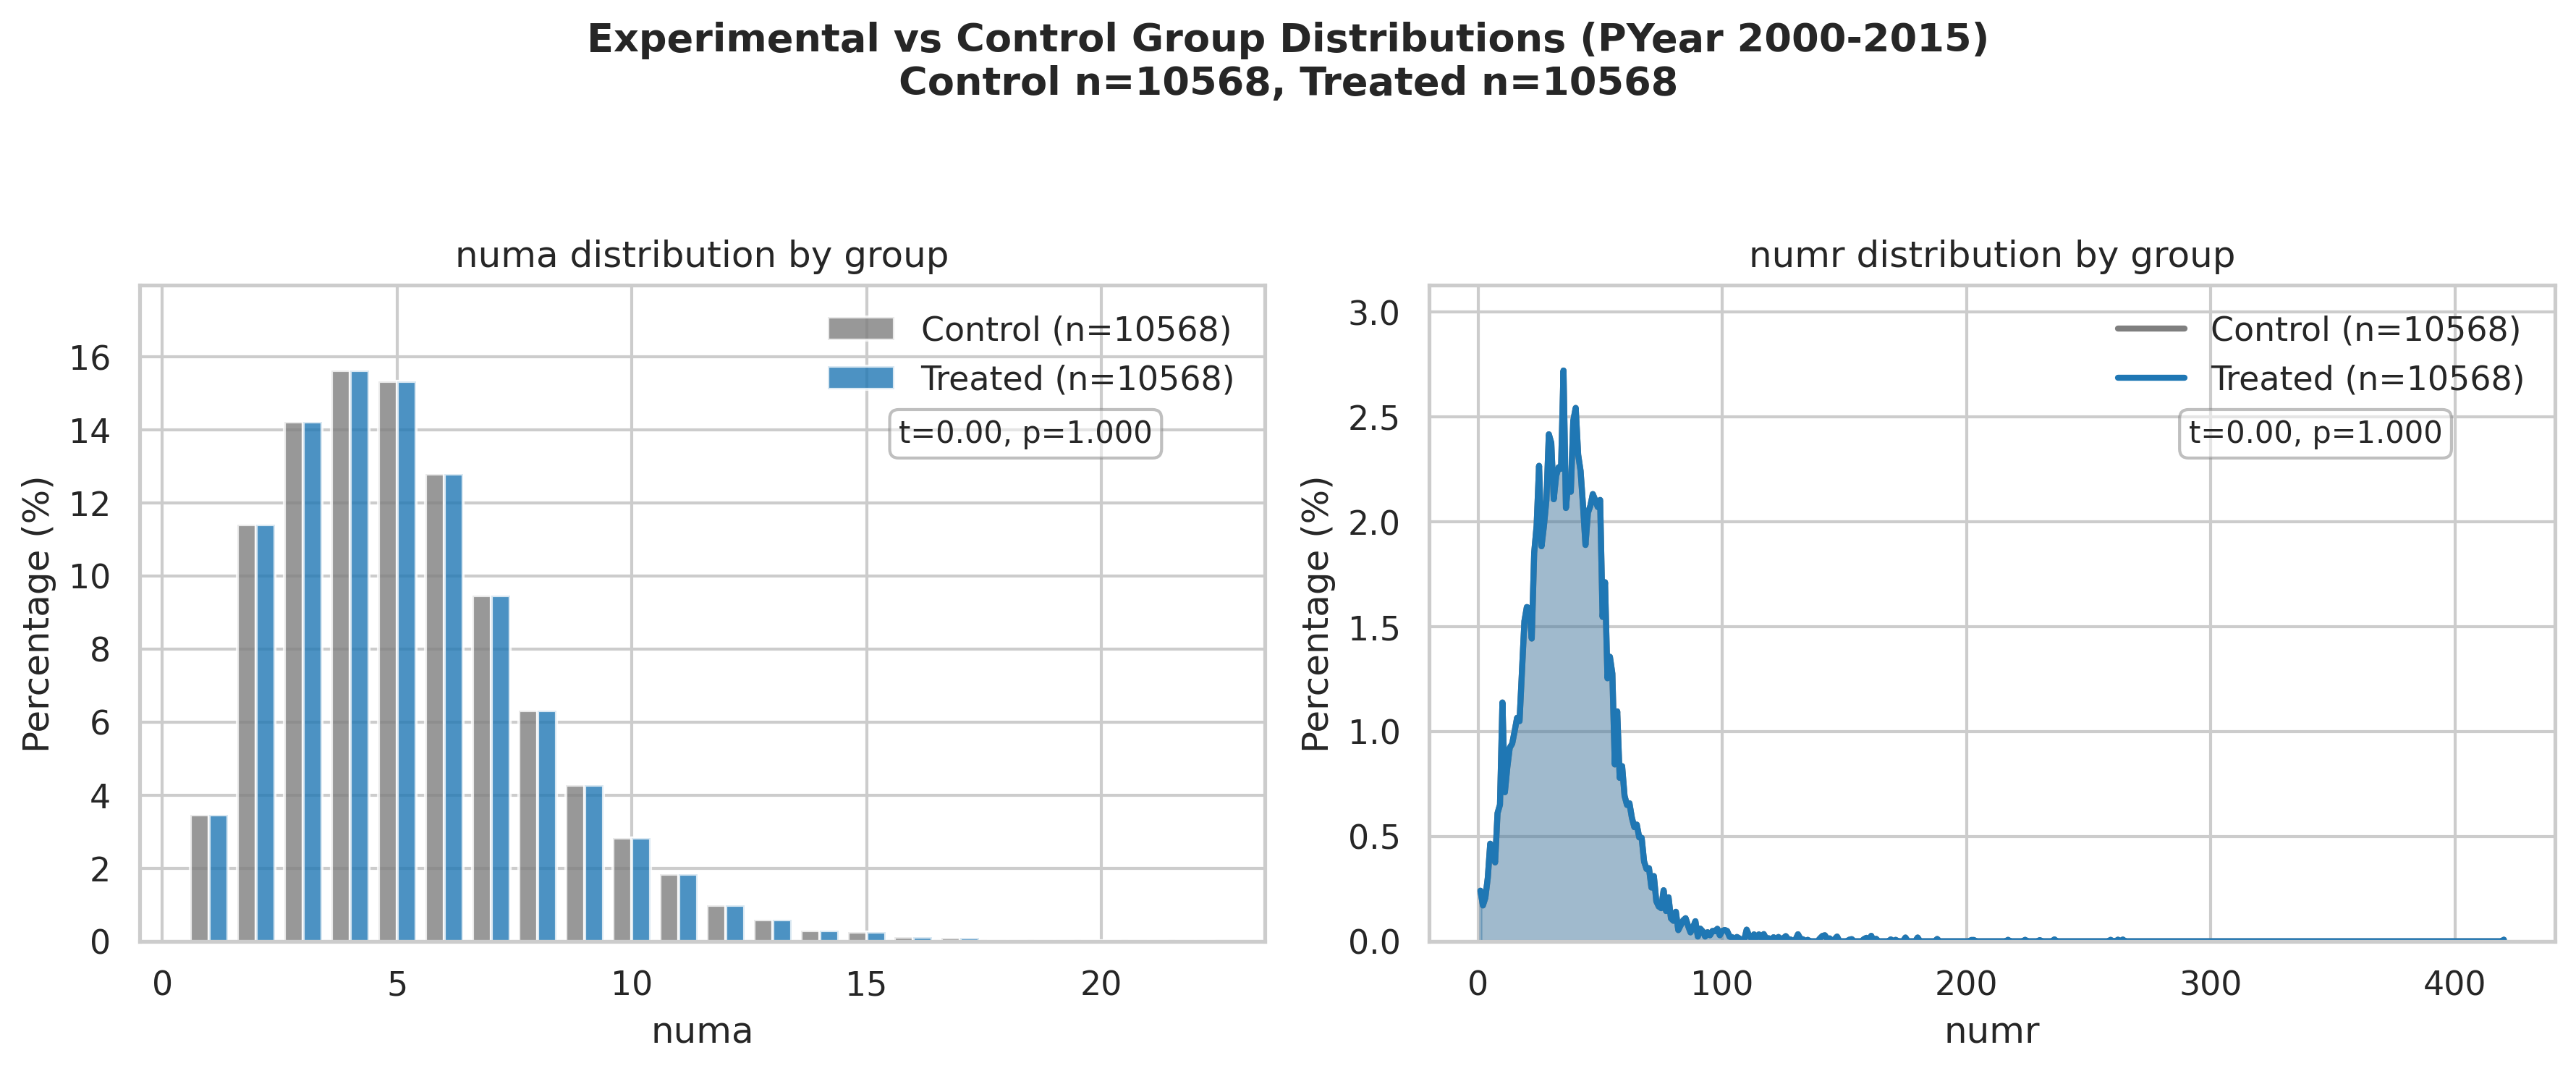

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

# 假设 panel_df 已经读入
# 只保留 PYear 2000-2015
df = panel_df[(panel_df['PYear'] >= 2000) & (panel_df['PYear'] <= 2015)]

# 设置图形风格：Nature 风格简洁
sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 11})

variables = ['numa', 'numr']

# 统计实验组和对照组唯一个体数量
n_control = df[df['group']==0]['paper_numid'].nunique()
n_treated = df[df['group']==1]['paper_numid'].nunique()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# Nature 风格颜色：浅灰 + 蓝色调
colors = ['#7f7f7f', '#1f77b4']

for ax, var in zip(axes, variables):
    if var == 'numa':
        # 柱状图
        bins = np.arange(df[var].min()-0.5, df[var].max()+1.5, 1)
        max_percent = 0
        for g, color, label in zip([0,1], colors, ['Control','Treated']):
            data = df[df['group']==g][var]
            counts, _ = np.histogram(data, bins=bins)
            counts_percent = counts / counts.sum() * 100
            ax.bar(bins[:-1]+0.5 + (0.2 if g==1 else -0.2), counts_percent, 
                   width=0.4, color=color, alpha=0.8, 
                   label=f"{label} (n={df[df['group']==g]['paper_numid'].nunique()})",
                   edgecolor="white")
            max_percent = max(max_percent, counts_percent.max())
        ax.set_ylim(0, max_percent*1.15)
    else:
        # 曲线 + 阴影图
        max_percent = 0
        for g, color, label in zip([0,1], colors, ['Control','Treated']):
            data = df[df['group']==g][var]
            counts, bins = np.histogram(data, bins=np.arange(data.min()-0.5, data.max()+1.5, 1))
            counts_percent = counts / counts.sum() * 100
            centers = bins[:-1] + 0.5
            ax.plot(centers, counts_percent, color=color, lw=2, label=f"{label} (n={df[df['group']==g]['paper_numid'].nunique()})")
            ax.fill_between(centers, counts_percent, color=color, alpha=0.3)
            max_percent = max(max_percent, counts_percent.max())
        ax.set_ylim(0, max_percent*1.15)
    
    # t 检验
    control = df[df['group']==0][var]
    treated = df[df['group']==1][var]
    t_stat, p_val = ttest_ind(treated, control, equal_var=False)
     # 将 t 检验标签放在右下角
    ax.text(0.90, 0.75, f"t={t_stat:.2f}, p={p_val:.3f}", 
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", alpha=0.5))

    
    ax.set_xlabel(var)
    ax.set_ylabel("Percentage (%)")
    ax.set_title(f"{var} distribution by group")
    ax.legend(frameon=False)

plt.suptitle(f"Experimental vs Control Group Distributions (PYear 2000-2015)\nControl n={n_control}, Treated n={n_treated}",
             fontsize=13, fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.92])
plt.show()


### PYear（2000-2015）

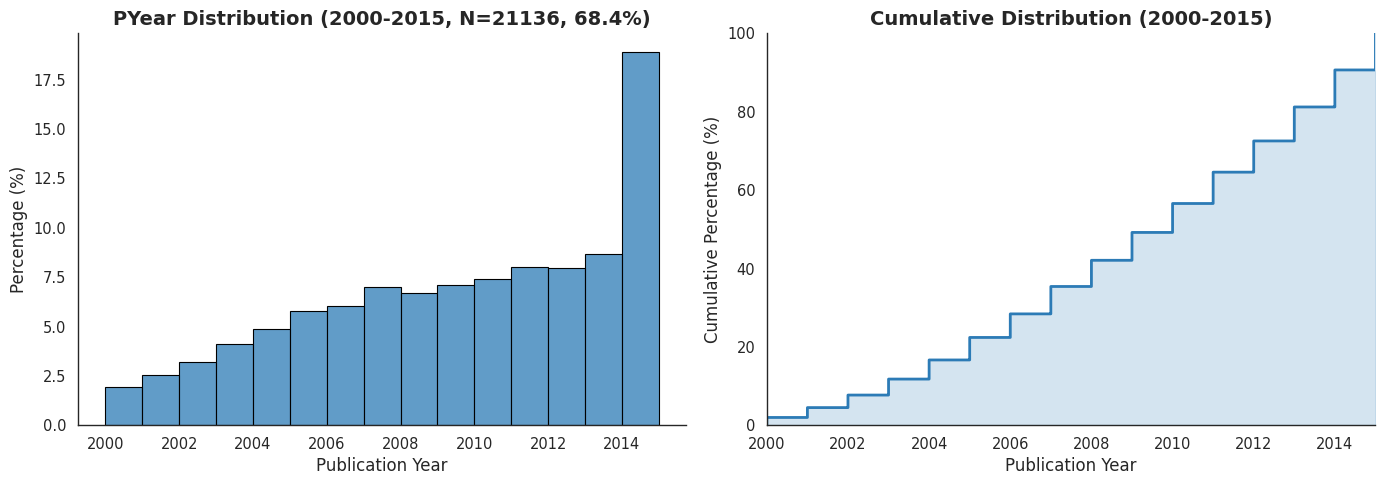

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 按 paper_numid 去重
unique_papers = panel_df.drop_duplicates(subset="paper_numid")

# 筛选 2000-2015 的数据
mask = (unique_papers["PYear"] >= 2000) & (unique_papers["PYear"] <= 2015)
subset = unique_papers.loc[mask]

# 样本数量
N_total = len(unique_papers)
N_subset = len(subset)
subset_ratio = N_subset / N_total * 100  # 百分比

# 设置Nature风格
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# 设置画布：柱状图 + 累积曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

# ---------------- 柱状图 ----------------
sns.histplot(
    subset["PYear"],
    bins=range(2000, 2016),  # 包括2015
    stat="percent",
    kde=False,
    color="#2c7bb6",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title(f"PYear Distribution (2000-2015, N={N_subset}, {subset_ratio:.1f}%)", fontsize=14, weight='bold')
axes[0].set_xlabel("Publication Year", fontsize=12)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# 在柱子上标注百分比
#counts, bins = np.histogram(subset["PYear"], bins=range(2000, 2016))
#percentages = counts / counts.sum() * 100
#for i, (count, pct) in enumerate(zip(counts, percentages)):
#    axes[0].text(bins[i]+0.5, pct + 0.5, f"{pct:.1f}%", ha='center', fontsize=10)

# ---------------- 累积分布曲线 ----------------
pyear_sorted = np.sort(subset["PYear"])
cdf_pyear = np.arange(1, len(pyear_sorted)+1) / len(pyear_sorted) * 100
axes[1].step(pyear_sorted, cdf_pyear, where='post', color="#2c7bb6", linewidth=2)
axes[1].fill_between(pyear_sorted, 0, cdf_pyear, step='post', color="#2c7bb6", alpha=0.2)  # 阴影
axes[1].set_title("Cumulative Distribution (2000-2015)", fontsize=14, weight='bold')
axes[1].set_xlabel("Publication Year", fontsize=12)
axes[1].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[1].set_xlim(2000, 2015)
axes[1].set_ylim(0, 100)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### T_PtoR and T_RtoN（2000-2015）

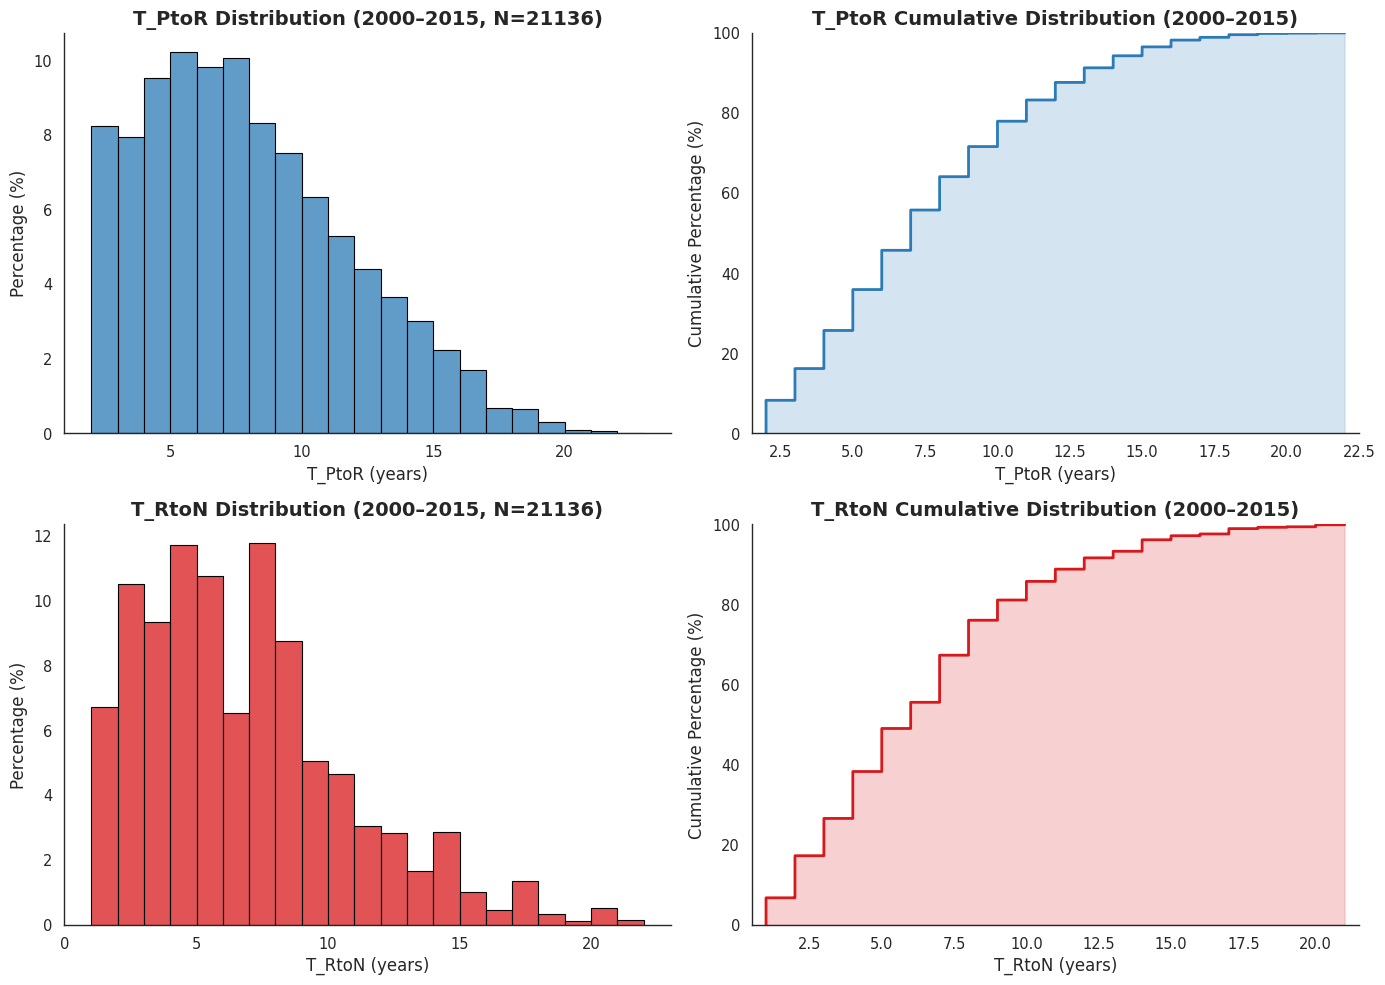

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 按 paper_numid 去重
unique_papers = panel_df.drop_duplicates(subset="paper_numid")

# 仅保留 2000–2015 的子集
subset = unique_papers[(unique_papers["PYear"] >= 2000) & (unique_papers["PYear"] <= 2015)]

# 样本数量
N = len(subset)

# 设置Nature风格
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# 设置画布：两个柱状图 + 两个累积分布曲线
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2布局
axes = axes.flatten()

# ---------------- T_PtoR 柱状图 ----------------
sns.histplot(
    subset["T_PtoR"], 
    bins=range(int(subset["T_PtoR"].min()), int(subset["T_PtoR"].max())+2),
    stat="percent",
    kde=False,
    color="#2c7bb6",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title(f"T_PtoR Distribution (2000–2015, N={N})", fontsize=14, weight='bold')
axes[0].set_xlabel("T_PtoR (years)", fontsize=12)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# ---------------- T_PtoR 累积分布 ----------------
t_ptor_sorted = np.sort(subset["T_PtoR"].dropna())
cdf_ptor = np.arange(1, len(t_ptor_sorted)+1) / len(t_ptor_sorted) * 100
axes[1].step(t_ptor_sorted, cdf_ptor, where='post', color="#2c7bb6", linewidth=2)
axes[1].fill_between(t_ptor_sorted, 0, cdf_ptor, step='post', color="#2c7bb6", alpha=0.2)
axes[1].set_title("T_PtoR Cumulative Distribution (2000–2015)", fontsize=14, weight='bold')
axes[1].set_xlabel("T_PtoR (years)", fontsize=12)
axes[1].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[1].set_xlim(t_ptor_sorted.min()-0.5, t_ptor_sorted.max()+0.5)
axes[1].set_ylim(0, 100)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# ---------------- T_RtoN 柱状图 ----------------
sns.histplot(
    subset["T_RtoN"], 
    bins=range(int(subset["T_RtoN"].min()), int(subset["T_RtoN"].max())+2),
    stat="percent",
    kde=False,
    color="#d7191c",
    edgecolor="black",
    ax=axes[2]
)
axes[2].set_title(f"T_RtoN Distribution (2000–2015, N={N})", fontsize=14, weight='bold')
axes[2].set_xlabel("T_RtoN (years)", fontsize=12)
axes[2].set_ylabel("Percentage (%)", fontsize=12)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# ---------------- T_RtoN 累积分布 ----------------
t_rton_sorted = np.sort(subset["T_RtoN"].dropna())
cdf_rton = np.arange(1, len(t_rton_sorted)+1) / len(t_rton_sorted) * 100
axes[3].step(t_rton_sorted, cdf_rton, where='post', color="#d7191c", linewidth=2)
axes[3].fill_between(t_rton_sorted, 0, cdf_rton, step='post', color="#d7191c", alpha=0.2)
axes[3].set_title("T_RtoN Cumulative Distribution (2000–2015)", fontsize=14, weight='bold')
axes[3].set_xlabel("T_RtoN (years)", fontsize=12)
axes[3].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[3].set_xlim(t_rton_sorted.min()-0.5, t_rton_sorted.max()+0.5)
axes[3].set_ylim(0, 100)
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### 回归结果

#### 各个回归结果汇总

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

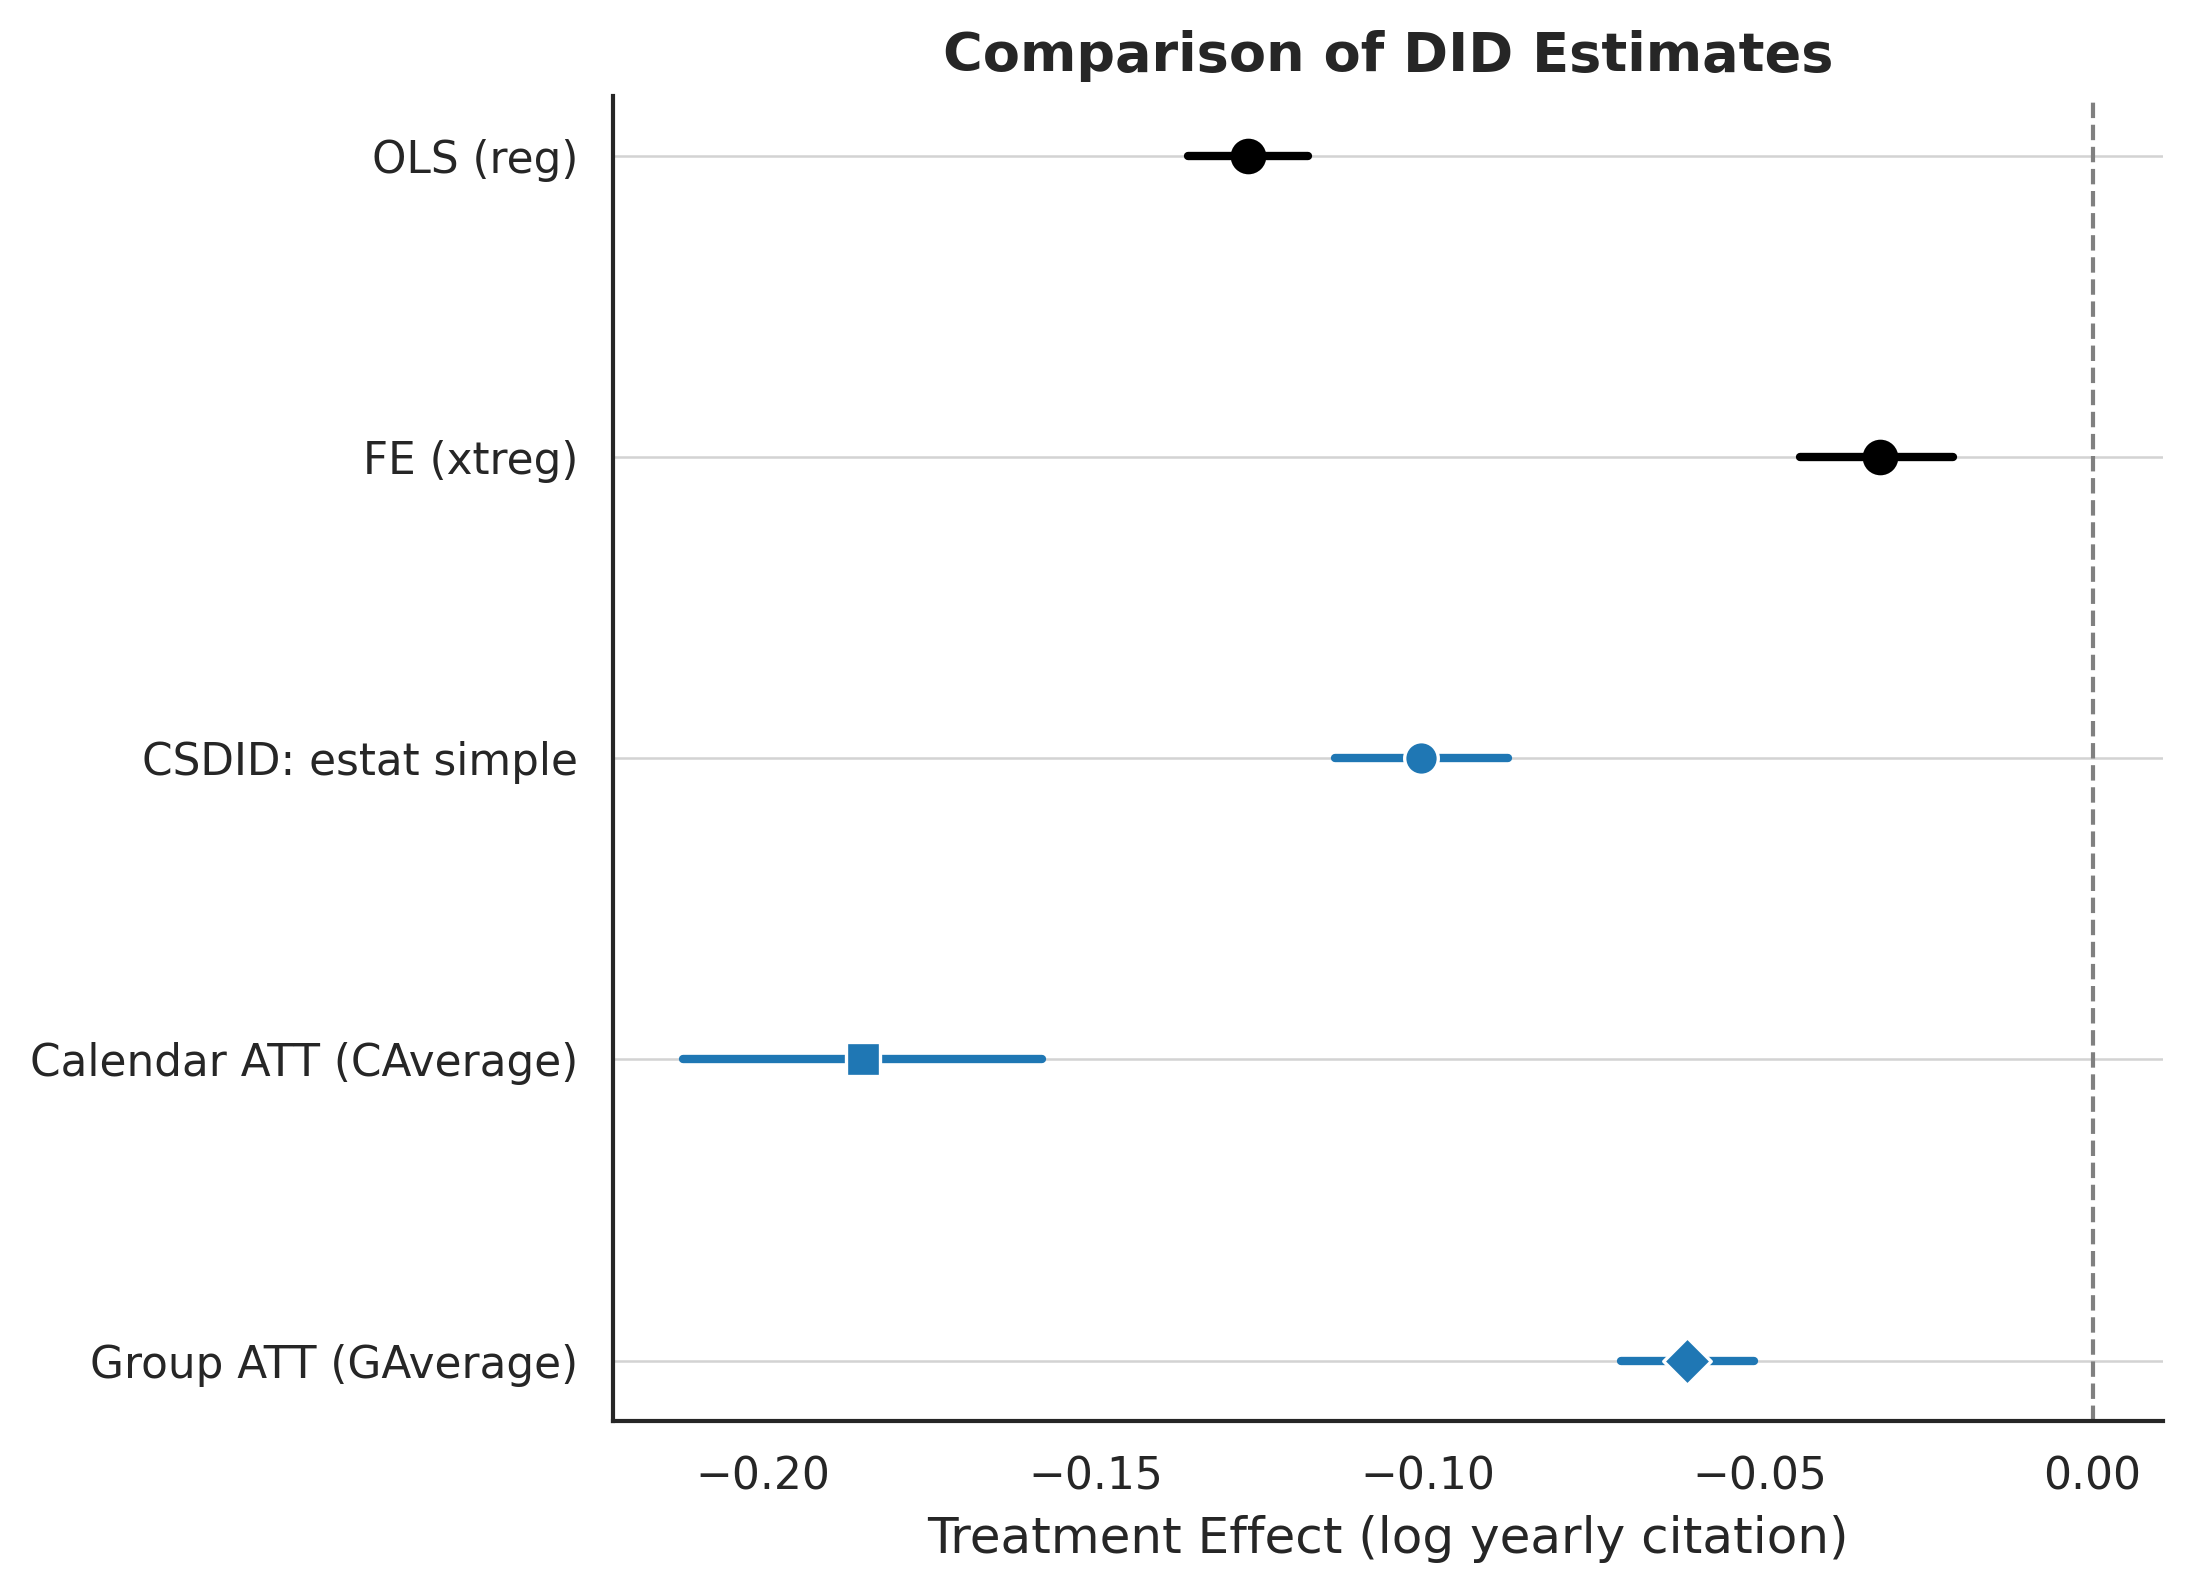

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# 分组方法和结果
groups = ["Traditional DID", "CSDID"]
methods = [
    "OLS (reg)",
    "FE (xtreg)",
    "estat simple",
    "Calendar ATT (CAverage)",
    "Group ATT (GAverage)"
]

coef = [-0.127, -0.032, -0.101, -0.185, -0.061]
lower = [-0.136, -0.044, -0.114, -0.212, -0.071]
upper = [-0.118, -0.021, -0.088, -0.158, -0.051]

# y 轴：从上到下排列
y = np.arange(len(methods))

plt.figure(figsize=(7.5, 5.5), dpi=300)

# 背景横线
for i in range(len(methods)):
    plt.axhline(y[i], color="lightgrey", lw=0.6, zorder=1)

# 分组颜色
colors = {
    "Traditional DID": "black",
    "CSDID": "#1f77b4"   # 蓝色
}

# 不同 marker 给 CSDID 三个方法
markers = ["o", "s", "D"]  # 圆、方、菱形

# 绘制
for i, method in enumerate(methods):
    if i < 2:  # 前两个是 Traditional DID
        group = "Traditional DID"
        plt.plot([lower[i], upper[i]], [y[i], y[i]], color=colors[group], lw=2)
        plt.scatter(coef[i], y[i], color=colors[group], s=60, zorder=3, marker="o")
    else:      # 后三个是 CSDID
        group = "CSDID"
        plt.plot([lower[i], upper[i]], [y[i], y[i]], color=colors[group], lw=2)
        plt.scatter(coef[i], y[i], color=colors[group], s=65, zorder=3, 
                    marker=markers[i-2], edgecolor="white", linewidth=0.8)

# 参考线（零效应）
plt.axvline(0, color="grey", linestyle="--", lw=1)

# Y 轴标签：在 CSDID 前插入一个分组标题
yticks = [
    "OLS (reg)",
    "FE (xtreg)",
    "CSDID: estat simple",
    "Calendar ATT (CAverage)",
    "Group ATT (GAverage)"
]
plt.yticks(y, yticks, fontsize=10.5)

# 反转顺序（上到下按顺序展示）
plt.gca().invert_yaxis()

# X 轴和标题
plt.xlabel("Treatment Effect (log yearly citation)", fontsize=12)
plt.title("Comparison of DID Estimates", fontsize=13, weight="bold")

# 去掉上右边框
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


#### CSDID  estat calendar

/tmp/ipykernel_2671689/1340301288.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm", len(periods)-1)
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times N

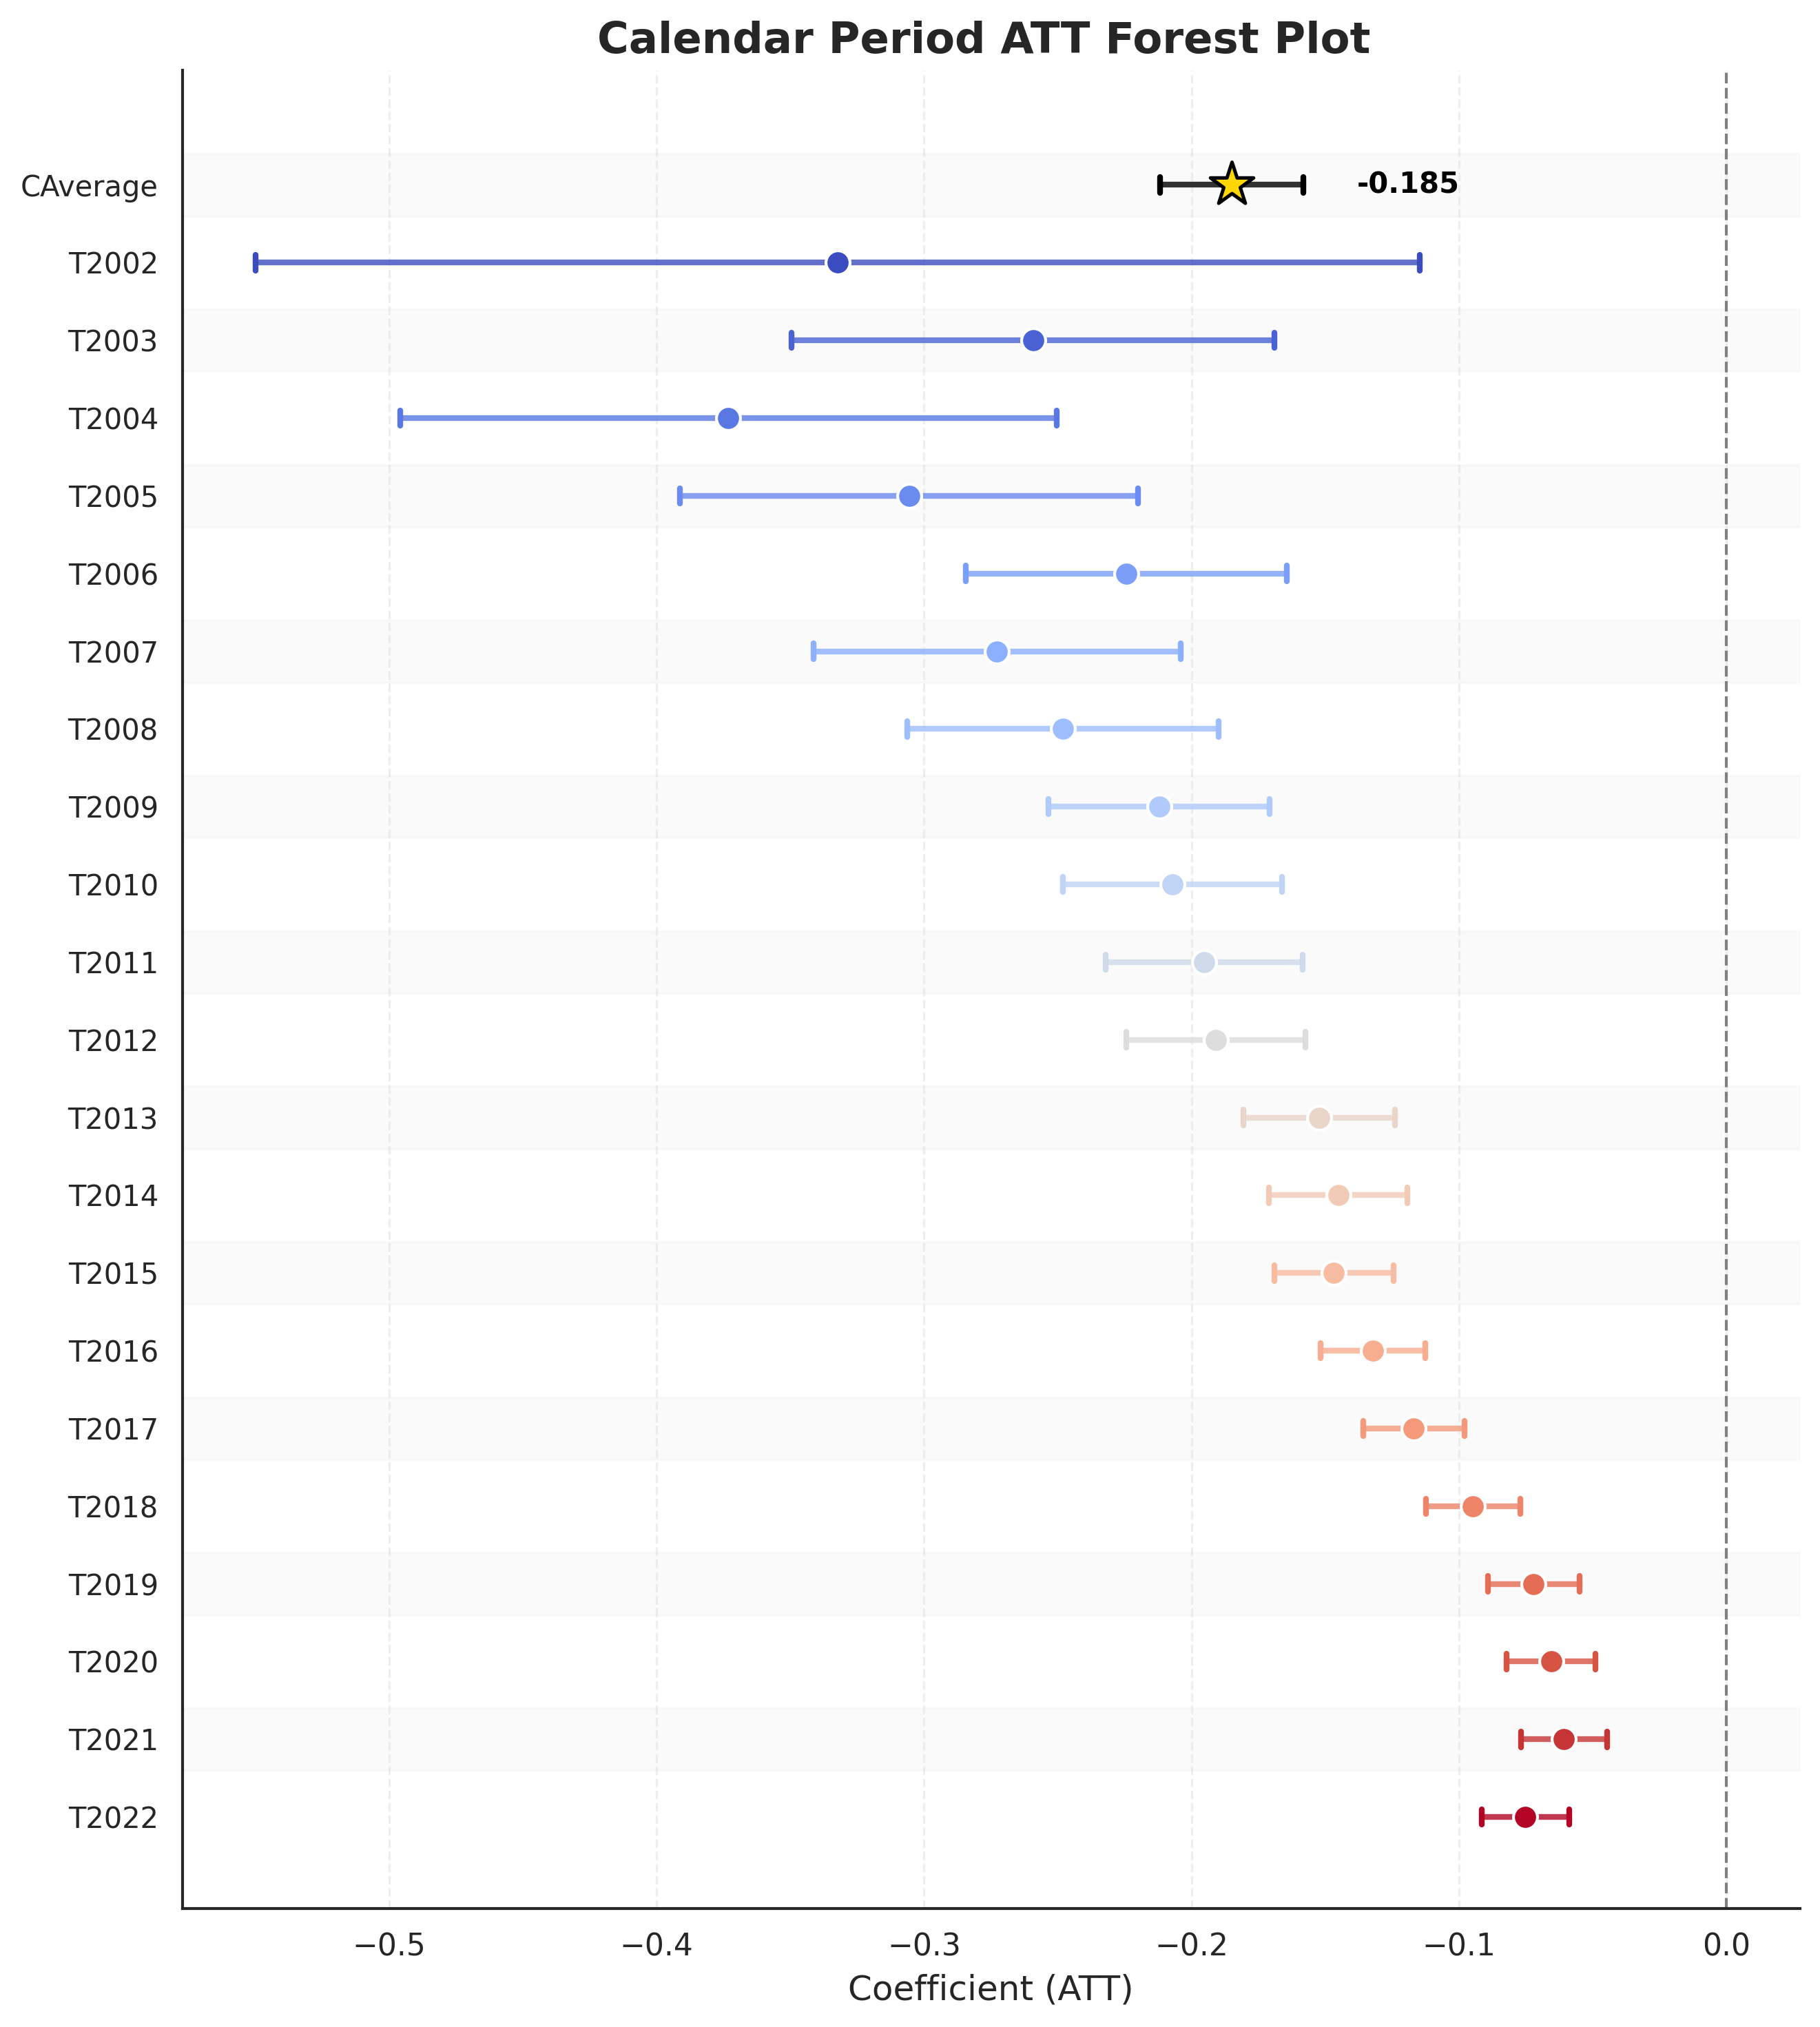

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# 数据
periods = ["CAverage","T2002","T2003","T2004","T2005","T2006","T2007","T2008","T2009",
           "T2010","T2011","T2012","T2013","T2014","T2015","T2016","T2017","T2018",
           "T2019","T2020","T2021","T2022"]

coef = [-0.1848848, -0.3322081, -0.2592702, -0.3731366, -0.3056335, -0.2243504,
        -0.2727112, -0.2481168, -0.2120506, -0.2071534, -0.1952281, -0.1908661,
        -0.1523646, -0.1451735, -0.1467721, -0.1322557, -0.1168599, -0.0948036,
        -0.0720915, -0.065573, -0.0608079, -0.0751538]

lower = [-0.2116994, -0.5498229, -0.349519, -0.4958514, -0.3913846, -0.2842784,
         -0.3413731, -0.3063963, -0.2533989, -0.2480565, -0.2320873, -0.2243578,
         -0.1806653, -0.171031, -0.1690753, -0.1517882, -0.1358724, -0.112466,
         -0.0891372, -0.0822582, -0.0769245, -0.0914065]

upper = [-0.1580701, -0.1145934, -0.1690214, -0.2504218, -0.2198825, -0.1644223,
         -0.2040493, -0.1898374, -0.1707024, -0.1662503, -0.1583689, -0.1573744,
         -0.1240639, -0.119316, -0.1244688, -0.1127231, -0.0978473, -0.0771412,
         -0.0550458, -0.0488877, -0.0446913, -0.058901]

y = np.arange(len(periods))

# 渐变颜色：年份用 coolwarm，CAverage 黑色
cmap = cm.get_cmap("coolwarm", len(periods)-1)
colors = ["black"] + [cmap(i) for i in range(len(periods)-1)]

plt.figure(figsize=(9, 10), dpi=300)

# 背景交替灰色横带
for i in range(len(periods)):
    if i % 2 == 0:
        plt.axhspan(i-0.4, i+0.4, color="lightgrey", alpha=0.1)

# 绘制森林图
for i in range(len(periods)):
    # CI 区间
    plt.plot([lower[i], upper[i]], [y[i], y[i]], color=colors[i], lw=2, alpha=0.8, solid_capstyle="round")
    plt.plot([lower[i], lower[i]], [y[i]-0.1, y[i]+0.1], color=colors[i], lw=2)
    plt.plot([upper[i], upper[i]], [y[i]-0.1, y[i]+0.1], color=colors[i], lw=2)

    # 中心点：CAverage 用五角星，其余用圆点
    if i == 0:
        plt.scatter(coef[i], y[i], marker="*", color="gold", s=250, edgecolor="black", linewidth=1.2, zorder=3)
        plt.text(upper[i]+0.02, y[i], f"{coef[i]:.3f}", va="center", fontsize=10, color="black", fontweight="bold")
    else:
        plt.scatter(coef[i], y[i], color=colors[i], s=70, edgecolor="white", linewidth=1, zorder=3)

# 参考线
plt.axvline(0, color="grey", linestyle="--", lw=1)

# 坐标轴 & 标签
plt.yticks(y, periods, fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient (ATT)", fontsize=12)
plt.title("Calendar Period ATT Forest Plot ", fontsize=15, fontweight="bold")

# 去掉上右边框
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


#### CSDID  estat group

/tmp/ipykernel_2671689/4190687425.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm", len(periods)-1)
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times N

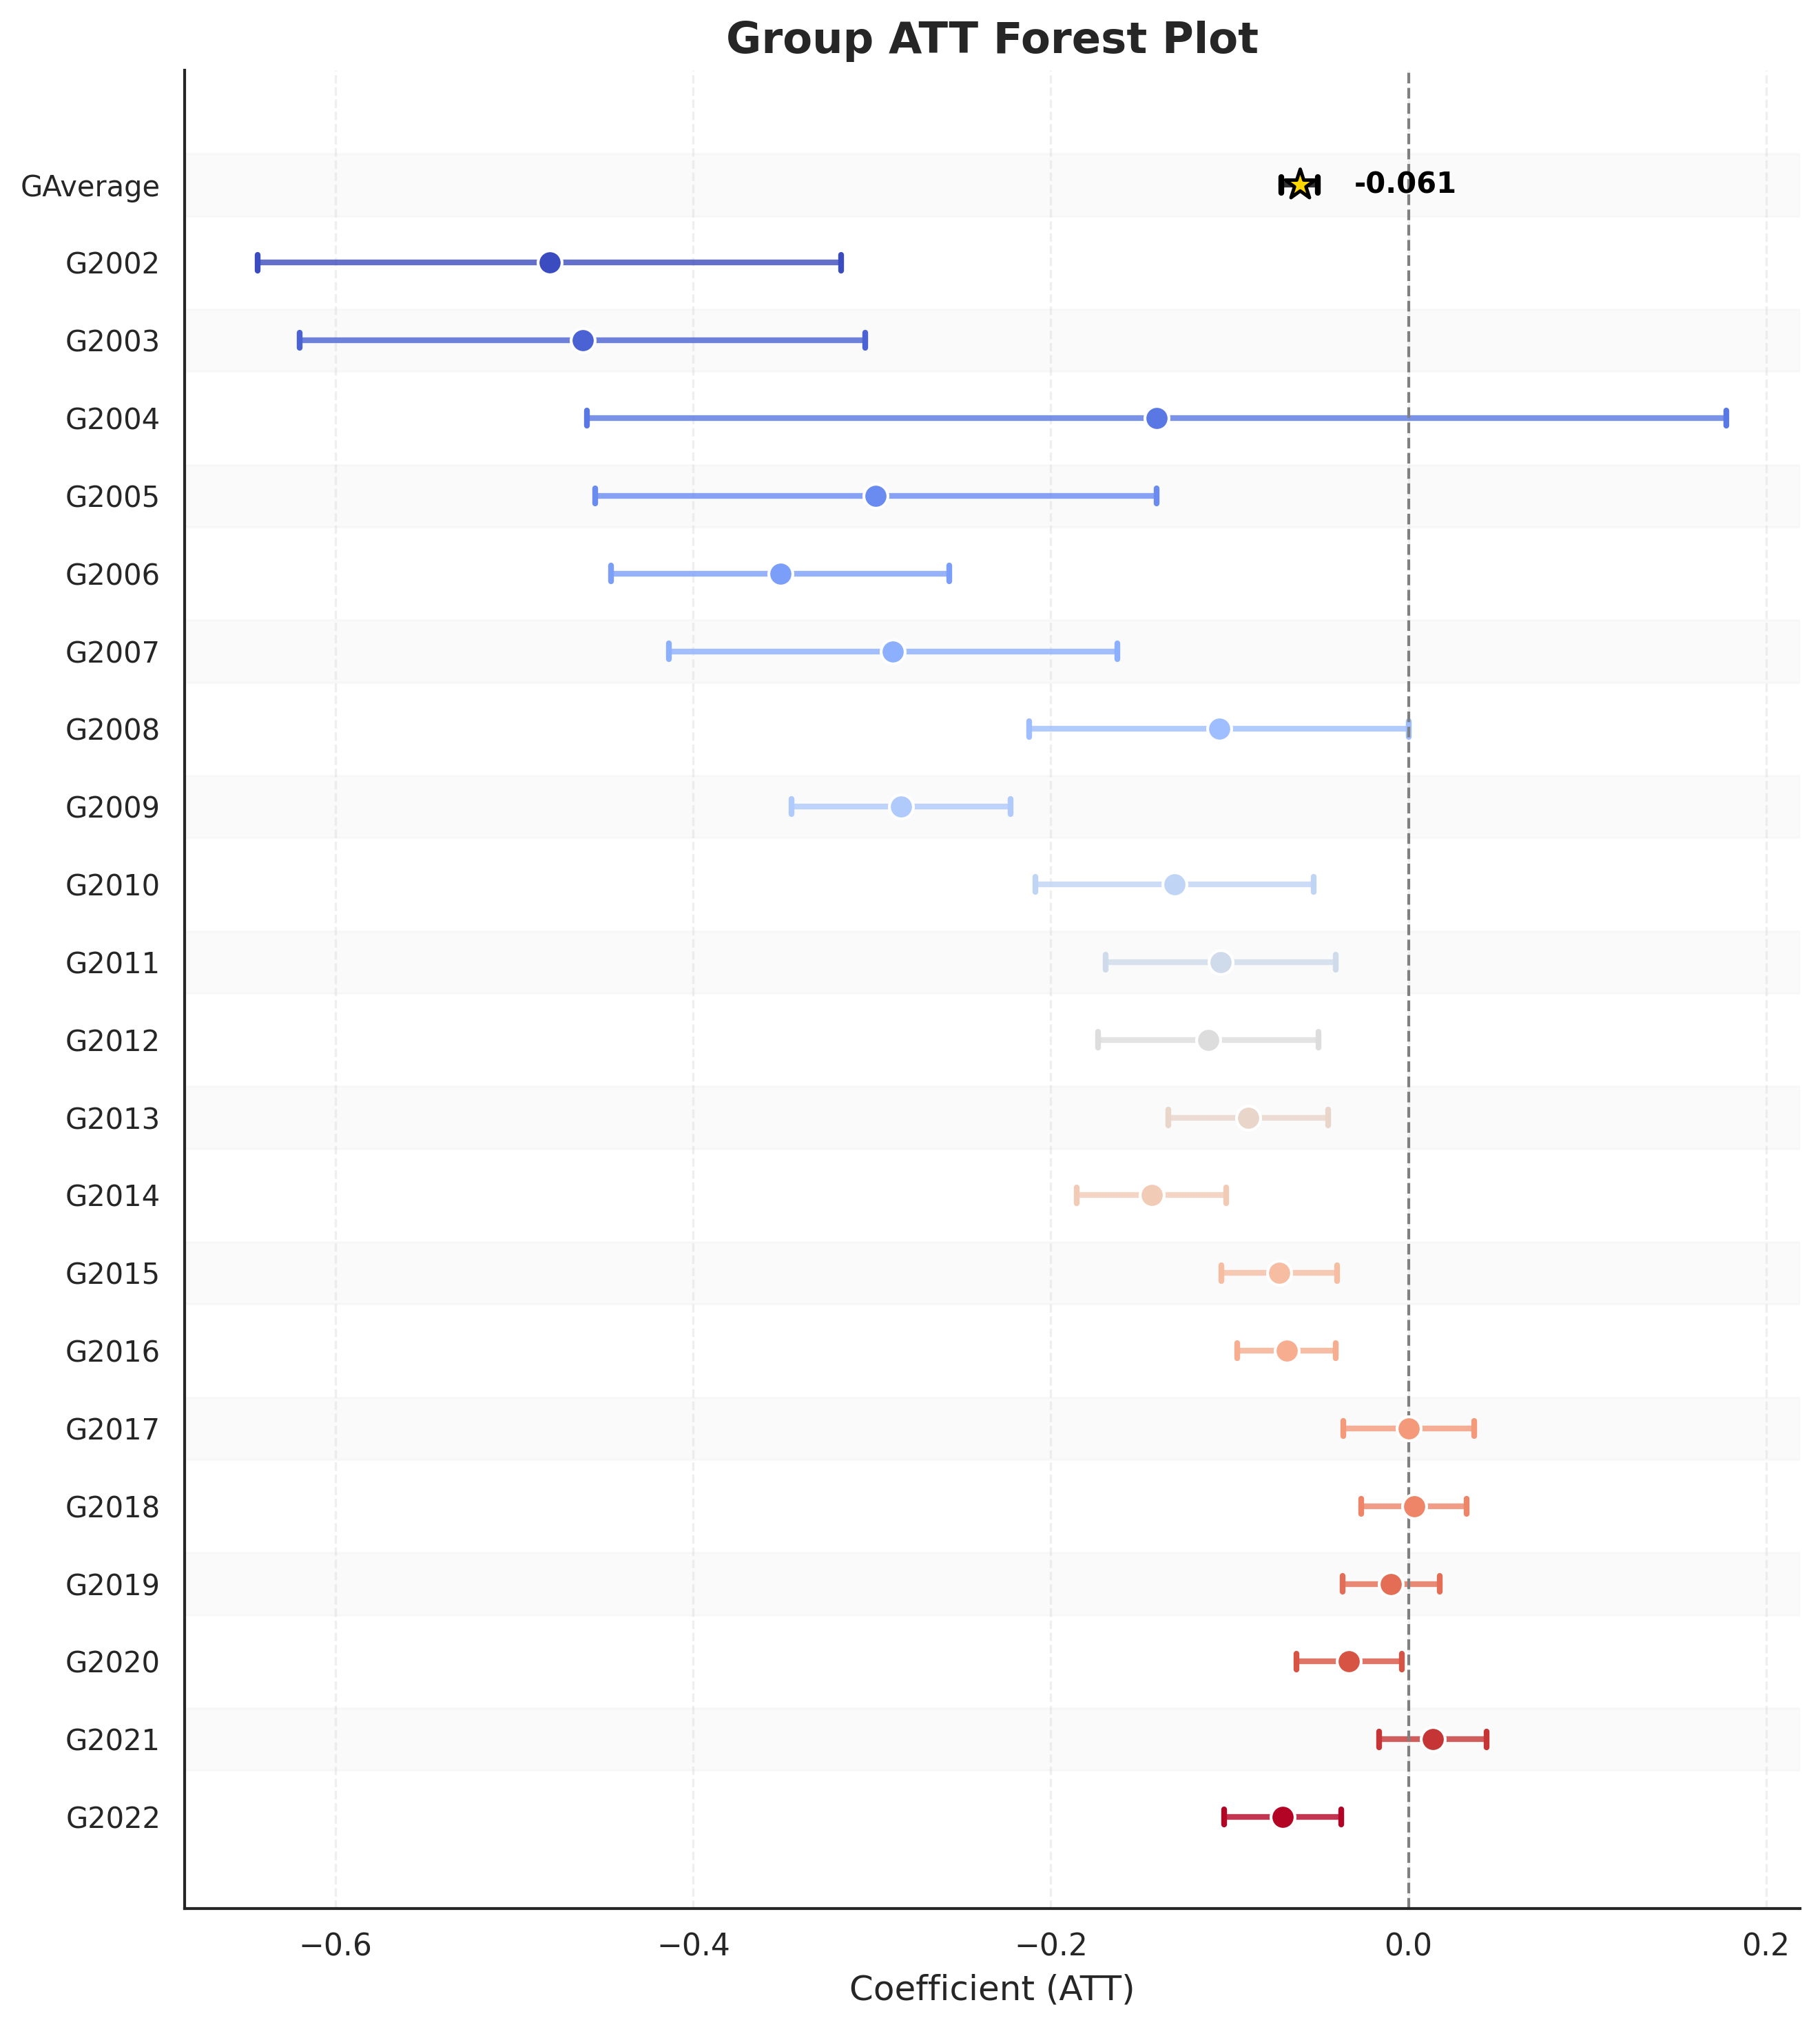

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# 数据
periods = ["GAverage","G2002","G2003","G2004","G2005","G2006","G2007","G2008","G2009",
           "G2010","G2011","G2012","G2013","G2014","G2015","G2016","G2017","G2018",
           "G2019","G2020","G2021","G2022"]

coef = [-0.0607474, -0.4804419, -0.461865, -0.1407864, -0.2979249, -0.3512864,
        -0.2882672, -0.1059289, -0.283949, -0.1307024, -0.1051604, -0.1121063,
        -0.0894928, -0.1436667, -0.072134, -0.0681877, 0.0001922, 0.0030754,
        -0.0097413, -0.0332572, 0.0135829, -0.0702429]

lower = [-0.0709919, -0.6435129, -0.6199475, -0.4595258, -0.4549723, -0.4458167,
         -0.413768, -0.2119282, -0.3452179, -0.2084771, -0.1694906, -0.1737408,
         -0.1341436, -0.1855929, -0.1045203, -0.095903, -0.0362993, -0.0263247,
         -0.0369555, -0.0626854, -0.0164067, -0.1030259]

upper = [-0.0505029, -0.3173709, -0.3037825, 0.1779529, -0.1408775, -0.2567561,
         -0.1627664, 0.0000704, -0.2226802, -0.0529278, -0.0408301, -0.0504719,
         -0.044842, -0.1017405, -0.0397477, -0.0404723, 0.0366837, 0.0324754,
         0.0174729, -0.003829, 0.0435725, -0.0374599]

y = np.arange(len(periods))

# 渐变颜色：年份用 coolwarm，GAverage 黑色
cmap = cm.get_cmap("coolwarm", len(periods)-1)
colors = ["black"] + [cmap(i) for i in range(len(periods)-1)]

plt.figure(figsize=(9, 10), dpi=300)

# 背景交替灰色横带
for i in range(len(periods)):
    if i % 2 == 0:
        plt.axhspan(i-0.4, i+0.4, color="lightgrey", alpha=0.1)

# 绘制森林图
for i in range(len(periods)):
    # CI 区间
    plt.plot([lower[i], upper[i]], [y[i], y[i]], color=colors[i], lw=2, alpha=0.8, solid_capstyle="round")
    plt.plot([lower[i], lower[i]], [y[i]-0.1, y[i]+0.1], color=colors[i], lw=2)
    plt.plot([upper[i], upper[i]], [y[i]-0.1, y[i]+0.1], color=colors[i], lw=2)

    # 中心点：GAverage 用五角星，其余用圆点
    if i == 0:
        plt.scatter(coef[i], y[i], marker="*", color="gold", s=120, edgecolor="black", linewidth=1.2, zorder=3)
        plt.text(upper[i]+0.02, y[i], f"{coef[i]:.3f}", va="center", fontsize=10, color="black", fontweight="bold")
    else:
        plt.scatter(coef[i], y[i], color=colors[i], s=70, edgecolor="white", linewidth=1, zorder=3)

# 参考线
plt.axvline(0, color="grey", linestyle="--", lw=1)

# 坐标轴 & 标签
plt.yticks(y, periods, fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient (ATT)", fontsize=12)
plt.title("Group ATT Forest Plot", fontsize=15, fontweight="bold")

# 去掉上右边框
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


### event研究（-2，12）

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

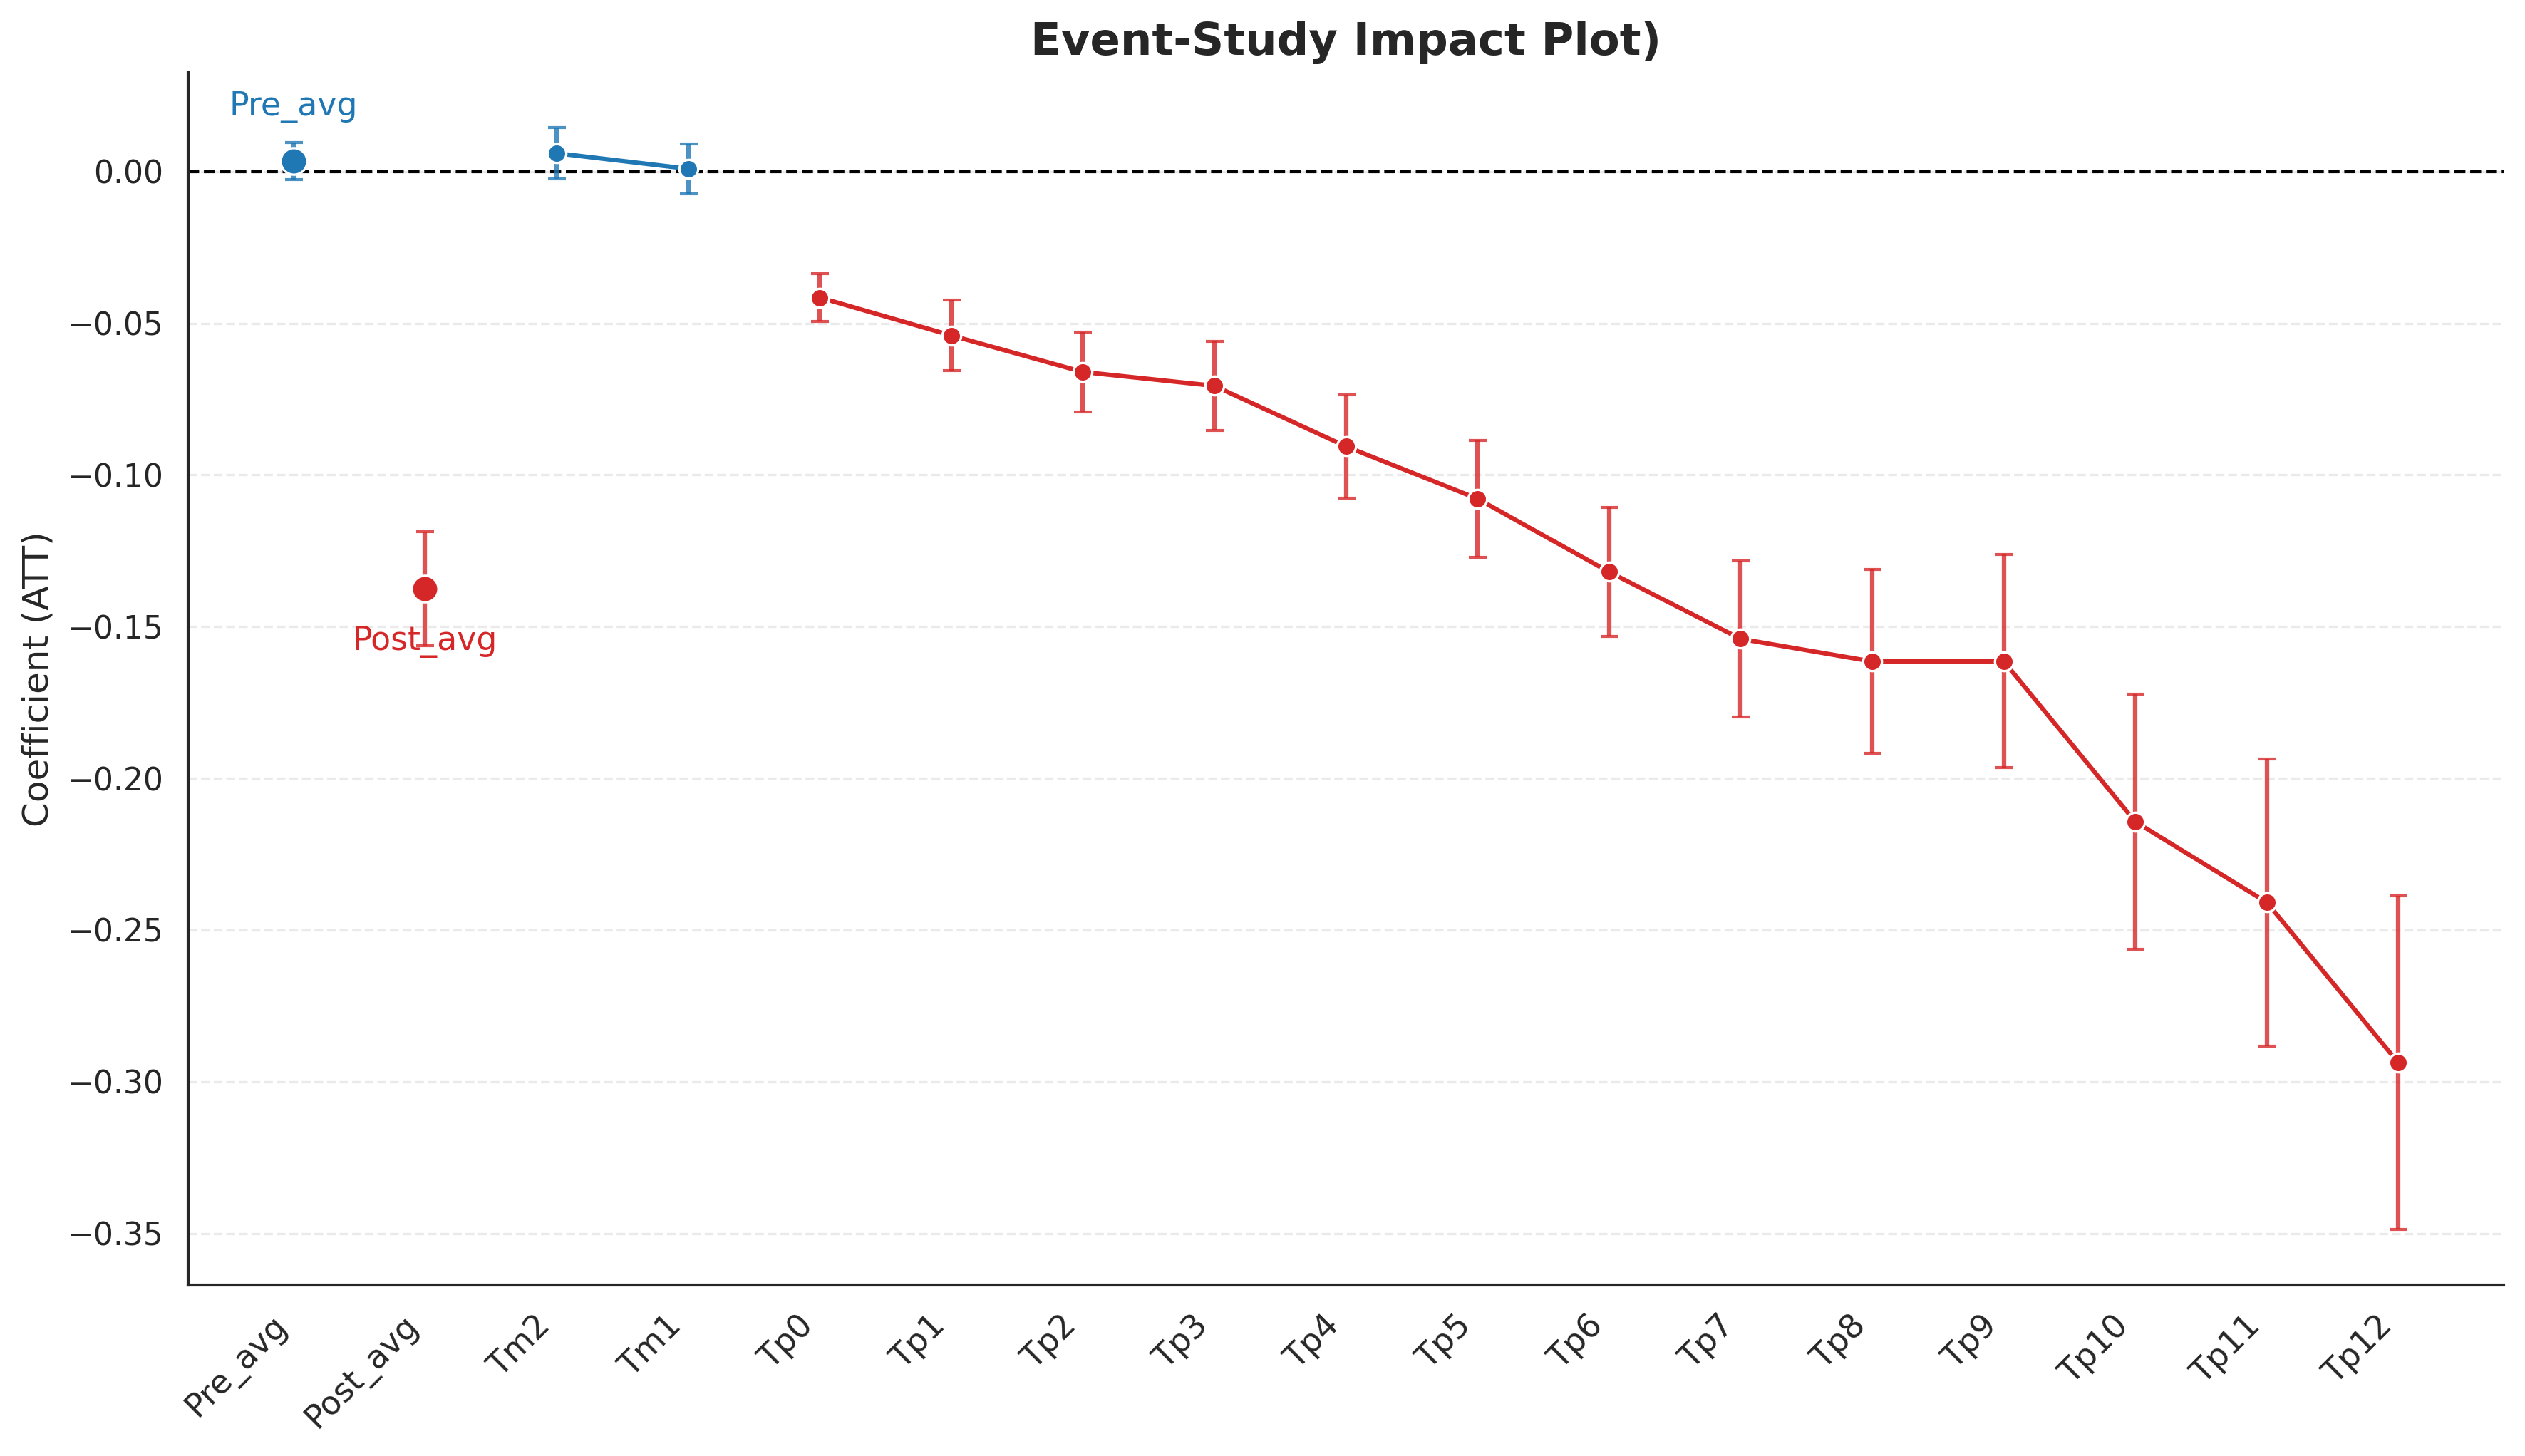

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
periods = ["Pre_avg", "Post_avg", "Tm2", "Tm1", "Tp0", "Tp1", "Tp2", "Tp3", "Tp4", 
           "Tp5", "Tp6", "Tp7", "Tp8", "Tp9", "Tp10", "Tp11", "Tp12"]

coef = [0.0034919, -0.1375836, 0.0060537, 0.00093, -0.0415221, -0.0540048, -0.0660551, -0.0706252,
        -0.0905793, -0.1078366, -0.131964, -0.1540448, -0.1614874, -0.1614197, -0.2142989,
        -0.2409047, -0.2938446]

lower = [-0.0026091, -0.1563603, -0.0023349, -0.0073156, -0.0494675, -0.065707, -0.0791785, -0.0853905,
         -0.1076762, -0.1271382, -0.1531724, -0.179792, -0.1918472, -0.1965115, -0.256263,
         -0.28822, -0.3488194]

upper = [0.0095928, -0.118807, 0.0144423, 0.0091756, -0.0335768, -0.0423025, -0.0529316, -0.05586,
         -0.0734824, -0.088535, -0.1107556, -0.1282976, -0.1311275, -0.126328, -0.1723348,
         -0.1935895, -0.2388697]

x = np.arange(len(periods))

# 颜色
pre_color = "#1f77b4"   # 深蓝
post_color = "#d62728"  # 深红

plt.figure(figsize=(12, 7), dpi=300)
plt.axhline(0, color="black", linestyle="--", linewidth=1)

# 画线条（趋势）
plt.plot(x[2:4], coef[2:4], color=pre_color, lw=1.5)   # Tm 部分
plt.plot(x[4:], coef[4:], color=post_color, lw=1.5)   # Tp 部分

# 效应点 + 置信区间
for i, label in enumerate(periods):
    color = pre_color if ("Tm" in label or label=="Pre_avg") else post_color
    size = 80 if label in ["Pre_avg", "Post_avg"] else 40
    
    plt.errorbar(x[i], coef[i],
                 yerr=[[coef[i]-lower[i]], [upper[i]-coef[i]]],
                 fmt='o', color=color, markersize=0, capsize=3, lw=1.5, alpha=0.8)
    plt.scatter(x[i], coef[i], color=color, s=size, edgecolor="white", zorder=3)

# 注释关键点
plt.text(x[0], coef[0]+0.015, "Pre_avg", color=pre_color, fontsize=11, ha="center")
plt.text(x[1], coef[1]-0.02, "Post_avg", color=post_color, fontsize=11, ha="center")

# 美化
plt.xticks(x, periods, rotation=45, ha="right", fontsize=11)
plt.ylabel("Coefficient (ATT)", fontsize=12)
plt.title("Event-Study Impact Plot)", fontsize=15, fontweight="bold")

# 优雅风格：去边框 + 添加网格
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


## 普通DID回归/因变量log_yearlycitation

## 普通DID回归/因变量yearlycitation

## Eventstudy